<a href="https://colab.research.google.com/github/Expan75/team20-adverserial-artists/blob/dev-mnist/GAN_U_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip install -q git+https://github.com/DeepTrackAI/deeplay.git
# %pip install deeplay
%pip install -q deeptrack --pre
%pip install -q multiprocess

import torch
from rich import print

# Define GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device("cpu"))

print(f"Torch version: {torch.__version__}\nCUDA version: {torch.version.cuda}\nDevice: {device}")

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.9/203.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.0/292.0 kB 2.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3

Torch version: 2.2.1+cu121
CUDA version: 12.1
Device: cuda:0

In [3]:
import deeplay as dl
import deeptrack as dt
import torch.nn as nn
import torchvision
import multiprocess as mp
from pathlib import Path
import os

In [4]:
DATA_PATH: Path = Path.cwd() / "data"
DATA_PATH.mkdir(exist_ok=True)
os.environ["DATA_PATH"] = str(DATA_PATH)

mnist_dataset_path: Path = DATA_PATH / "MNIST_dataset" / "mnist"

if not mnist_dataset_path.exists():
    !cd $DATA_PATH && git clone https://github.com/DeepTrackAI/MNIST_dataset

train_files = dt.sources.ImageFolder(
    root=str(mnist_dataset_path / "train"),
)
test_files = dt.sources.ImageFolder(
    root=str(mnist_dataset_path / "test"),
)
files = dt.sources.Join(train_files, test_files)

Cloning into 'MNIST_dataset'...
remote: Enumerating objects: 70019, done.
remote: Counting objects: 100% (70019/70019), done.
remote: Compressing objects: 100% (70014/70014), done.
remote: Total 70019 (delta 4), reused 70008 (delta 2), pack-reused 0
Receiving objects: 100% (70019/70019), 37.33 MiB | 20.39 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (70003/70003), done.


In [5]:
image_pipeline = (
    dt.LoadImage(files.path)
    >> dt.NormalizeMinMax()
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

label_pipeline = dt.Value(files.label_name[0]) >> int

In [6]:
train_dataset = dt.pytorch.Dataset(image_pipeline & label_pipeline,
                                  inputs=train_files)
test_dataset = dt.pytorch.Dataset(image_pipeline & label_pipeline,
                                  inputs=test_files)

train_loader = dl.DataLoader(test_dataset, batch_size=5, shuffle=True)
test_loader = dl.DataLoader(test_dataset, batch_size=5, shuffle=False)

In [31]:
from kornia.contrib import extract_tensor_patches, combine_tensor_patches
import numpy as np


class Generator(dl.UNet2d):
    def __init__(self, *args, **kwargs):
        self.patch_size = kwargs["channels"][0]
        super().__init__(*args, **kwargs)

    # def forward(self, input):
    #     _, _, height, width = input.shape

    #     if any(l < self.patch_size for l in (height, width)):
    #         raise ValueError(
    #             f"Image ({height}x{width}) is smaller than kernel size ({self.patch_size}x{self.patch_size})"
    #         )

    #     stride = [np.gcd(height, self.patch_size), np.gcd(width, self.patch_size)]
    #     input_patches = extract_tensor_patches(input=input, window_size=self.patch_size, stride=stride).movedim(1, 0)

    #     output_patches = torch.vmap(super().forward)(input_patches).movedim(0, 1)

    #     output = combine_tensor_patches(
    #         patches=output_patches, original_size=(height, width), window_size=self.patch_size, stride=stride
    #     )

    #     return output


generator_model = Generator(
    in_channels=1,
    channels=[16, 32],
    out_channels=1,
    skip=dl.Cat()
)
print(generator_model)

Generator(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Layer[Conv2d](in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
      (1): Conv2dBlock(
        (pool): Layer[MaxPool2d](kernel_size=2, stride=2)
        (layer): Layer[Conv2d](in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
    )
    (postprocess): Layer[Identity]()
  )
  (bottleneck): ConvolutionalNeuralNetwork(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (pool): Layer[MaxPool2d](kernel_size=2, stride=2)
        (layer): Layer[Conv2d](in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (upsample): Layer[ConvTranspose2d](kernel_size=2, stride=2, padding=0, in_channels=32, out_channels=32)
      )
    )
  )
  (decoder): ConvolutionalDecoder2d(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Layer[Conv2d](in_channels=64, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (upsample): Layer[ConvTranspose2d](kernel_size=2, stride=2, padding=0, in_channels=16, out_channels=16)
      )
      (1): Conv2dBlock(
        (layer): Layer[Conv2d](in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1)
        (activation): Layer[Identity]()
      )
    )
    (preprocess): Layer[Identity]()
  )
  (skip): Cat()
)

In [32]:
class Discriminator1(dl.DeeplayModule):
    def __init__(
            self,
            in_channels,
            hidden_channels_cnn,
            hidden_channels_mlp,
            out_channels_cnn,
            out_features
        ):
        super().__init__()

        self.cnn = dl.ConvolutionalNeuralNetwork(
            in_channels=in_channels,
            hidden_channels=hidden_channels_cnn,
            out_channels=out_channels_cnn,
            pool=nn.MaxPool2d(kernel_size=2),
            out_activation=nn.ReLU,
        )

        self.pool = dl.Layer(nn.MaxPool2d, kernel_size=2)
        self.flatten = dl.Layer(nn.Flatten)

        self.dense = dl.MultiLayerPerceptron(
            in_features=out_channels_cnn,
            hidden_features=hidden_channels_mlp,
            out_features=out_features,
            out_activation=nn.Identity,
        )
        self.dense[..., "layer#0"].configure(nn.LazyLinear)


    def forward(self, x):
        x = self.cnn(x)
        x = self.flatten(self.pool(x))
        x = self.dense(x)

        return torch.sigmoid(x)

discriminator_1 = Discriminator1(
    in_channels=1,
    hidden_channels_cnn=[16, 32],
    hidden_channels_mlp=[32, 32],
    out_channels_cnn=64,
    out_features=1
)
print(discriminator_1)

Discriminator1(
  (cnn): ConvolutionalNeuralNetwork(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Layer[Conv2d](in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
      (1): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Layer[Conv2d](in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
      (2): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Layer[Conv2d](in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
    )
  )
  (pool): Layer[MaxPool2d](kernel_size=2)
  (flatten): Layer[Flatten]()
  (dense): MultiLayerPerceptron(
    (blocks): LayerList(
      (0): LinearBlock(
        (layer): Layer[LazyLinear](out_features=32, bias=True)
        (activation): Layer[ReLU]()
      )
      (1): LinearBlock(
        (layer): Layer[Linear](in_features=32, out_features=32, bias=True)
        (activation): Layer[ReLU]()
      )
      (2): LinearBlock(
        (layer): Layer[Linear](in_features=32, out_features=1, bias=True)
        (activation): Layer[Identity]()
      )
    )
  )
)

In [37]:
import matplotlib.pyplot as plt
from kornia.utils import tensor_to_image
import torch.nn.functional as F

class GAN(dl.Application):
    def __init__(self, generator, discriminator_1, **kwargs):
        super().__init__(**kwargs)
        self.generator = generator
        self.discriminator_1 = discriminator_1

        self.automatic_optimization = False


    def configure_optimizers(self):
        generator_optimizer = self.create_optimizer_with_params(
            dl.Adam(), self.generator.parameters()
        )
        discriminator_1_optimizer = self.create_optimizer_with_params(
            dl.Adam(), self.discriminator_1.parameters()
        )

        return [generator_optimizer, discriminator_1_optimizer], []

    def forward(self, batch):
        return self.generator(batch)

    def adversarial_loss_1(self, input, target):
        return F.binary_cross_entropy_with_logits(input, target)

    def training_step(self, batch, batch_idx):
        self.train()
        input, target = batch
        print(f'epoch: {self.current_epoch}')

        gen_opt, disc_1_opt = self.optimizers()

        real_label = torch.ones(input.size(0), 1)
        real_label = real_label.type_as(input)

        fake_label = torch.zeros(input.size(0), 1)
        fake_label = fake_label.type_as(input)

        # Train generator
        self.toggle_optimizer(gen_opt)

        gen_output = self(input)
        disc_1_output_fake = self.discriminator_1(gen_output)


        fig, axs = plt.subplots(1, 5, figsize=((1 * 10, 5*10)))
        for ax, img in zip(axs.ravel(), [tensor_to_image(o) for o in input.clone().detach()]):
            ax.imshow(img.squeeze(), cmap="gray")
            ax.set_axis_off()
        plt.show()

        fig, axs = plt.subplots(1, 5, figsize=((1 * 10, 5*10)))
        for ax, img in zip(axs.ravel(), [tensor_to_image(o) for o in gen_output.clone().detach()]):
            ax.imshow(img.squeeze(), cmap="gray")
            ax.set_axis_off()
        plt.show()

        print(disc_1_output_fake)

        gen_loss = self.adversarial_loss_1(disc_1_output_fake, real_label)

        self.log("gen_loss", gen_loss, prog_bar=True)
        self.manual_backward(gen_loss)
        gen_opt.step()
        gen_opt.zero_grad()
        self.untoggle_optimizer(gen_opt)

        # Train discriminator 1
        self.toggle_optimizer(disc_1_opt)
        real_label = torch.ones(input.size(0), 1)
        real_label = real_label.type_as(input)

        fake_label = torch.zeros(input.size(0), 1)
        fake_label = fake_label.type_as(input)

        gen_output = self(input)
        disc_1_output_fake = self.discriminator_1(gen_output)
        disc_1_output_real = self.discriminator_1(input)

        fig, axs = plt.subplots(1, 5, figsize=((1 * 10, 5*10)))
        for ax, img in zip(axs.ravel(), [tensor_to_image(o) for o in input.clone().detach()]):
            ax.imshow(img.squeeze(), cmap="gray")
            ax.set_axis_off()
        plt.show()

        fig, axs = plt.subplots(1, 5, figsize=((1 * 10, 5*10)))
        for ax, img in zip(axs.ravel(), [tensor_to_image(o) for o in gen_output.clone().detach()]):
            ax.imshow(img.squeeze(), cmap="gray")
            ax.set_axis_off()
        plt.show()

        print(disc_1_output_fake)
        #raise

        disc_1_loss_real = self.adversarial_loss_1(disc_1_output_real, real_label)
        disc_1_loss_fake = self.adversarial_loss_1(disc_1_output_fake, fake_label)
        disc_1_loss = (disc_1_loss_real + disc_1_loss_fake) / 2

        self.log("disc_1_loss", disc_1_loss, prog_bar=True)
        self.manual_backward(disc_1_loss)
        disc_1_opt.step()
        disc_1_opt.zero_grad()
        self.untoggle_optimizer(disc_1_opt)


gan = GAN(
    generator=generator_model.create(),
    discriminator_1=discriminator_1.create()
)
print(gan)

GAN(
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (generator): Generator(
    (encoder): ConvolutionalEncoder2d(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (1): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
      )
      (postprocess): Identity()
    )
    (bottleneck): ConvolutionalNeuralNetwork(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
          (upsample): ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
        )
      )
    )
    (decoder): ConvolutionalDecoder2d(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (layer): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
          (upsample): ConvTranspose2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
        )
        (1): Conv2dBlock(
          (layer): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): Identity()
        )
      )
      (preprocess): Identity()
    )
    (skip): Cat()
  )
  (discriminator_1): Discriminator1(
    (cnn): ConvolutionalNeuralNetwork(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (1): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (2): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (dense): MultiLayerPerceptron(
      (blocks): LayerList(
        (0): LinearBlock(
          (layer): LazyLinear(in_features=0, out_features=32, bias=True)
          (activation): ReLU()
        )
        (1): LinearBlock(
          (layer): Linear(in_features=32, out_features=32, bias=True)
          (activation): ReLU()
        )
        (2): LinearBlock(
          (layer): Linear(in_features=32, out_features=1, bias=True)
          (activation): Identity()
        )
      )
    )
  )
)

┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name            ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ train_metrics   │ MetricCollection │      0 │
│ 1 │ val_metrics     │ MetricCollection │      0 │
│ 2 │ test_metrics    │ MetricCollection │      0 │
│ 3 │ generator       │ Generator        │ 28.7 K │
│ 4 │ discriminator_1 │ Discriminator1   │ 24.4 K │
└───┴─────────────────┴──────────────────┴────────┘

Trainable params: 53.1 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 53.1 K                                                                                               
Total estimated model params size (MB): 0

Output()

epoch: 0

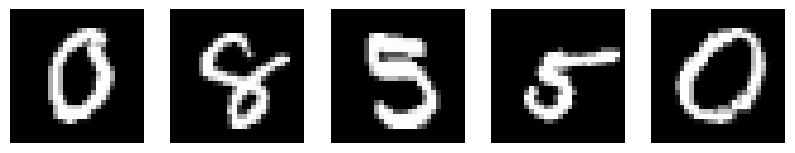

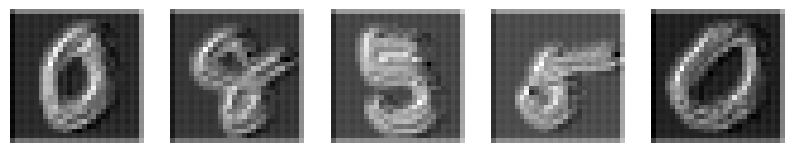

tensor([[0.4600],
        [0.4600],
        [0.4599],
        [0.4600],
        [0.4600]], device='cuda:0', grad_fn=<SigmoidBackward0>)

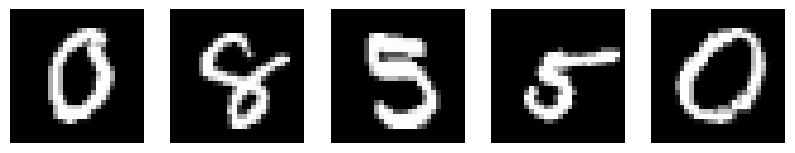

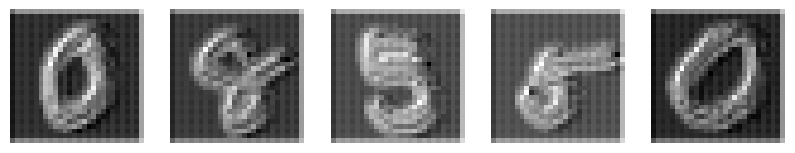

tensor([[0.4600],
        [0.4601],
        [0.4600],
        [0.4601],
        [0.4601]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

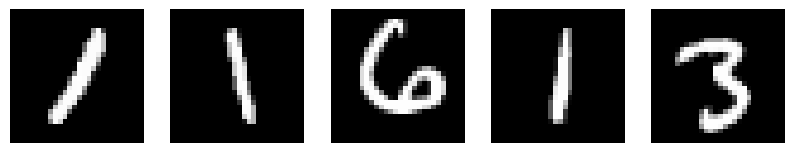

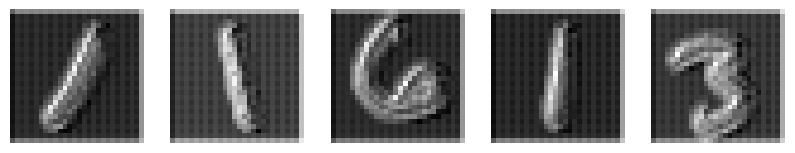

tensor([[0.4558],
        [0.4557],
        [0.4558],
        [0.4557],
        [0.4558]], device='cuda:0', grad_fn=<SigmoidBackward0>)

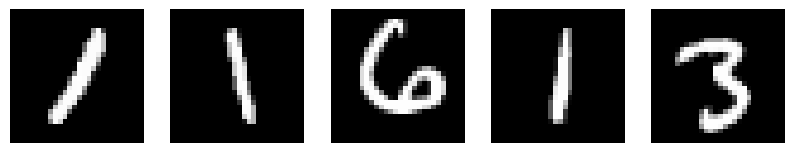

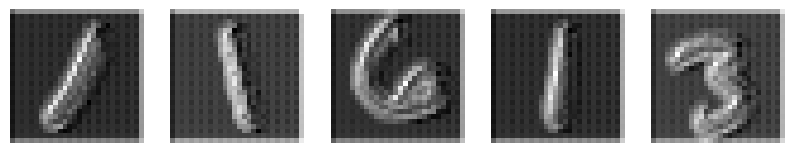

tensor([[0.4558],
        [0.4558],
        [0.4558],
        [0.4558],
        [0.4558]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

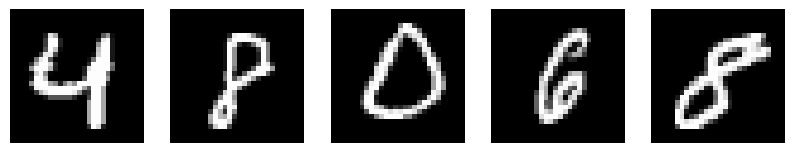

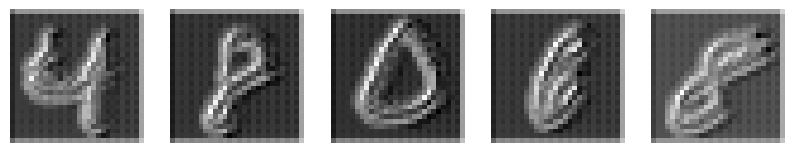

tensor([[0.4522],
        [0.4522],
        [0.4522],
        [0.4522],
        [0.4522]], device='cuda:0', grad_fn=<SigmoidBackward0>)

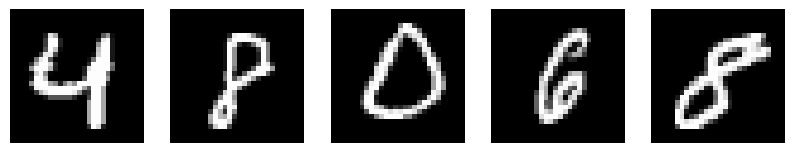

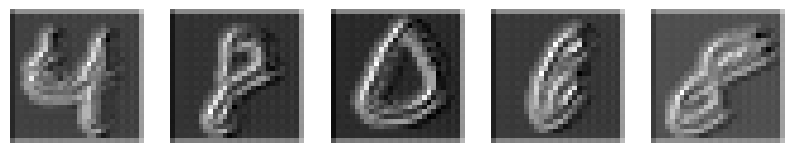

tensor([[0.4524],
        [0.4523],
        [0.4524],
        [0.4524],
        [0.4523]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

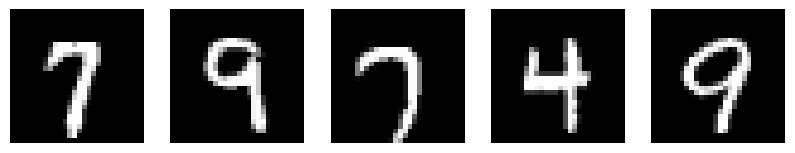

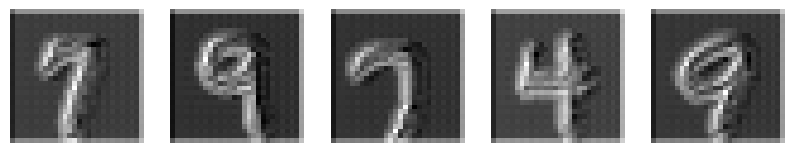

tensor([[0.4486],
        [0.4486],
        [0.4486],
        [0.4485],
        [0.4486]], device='cuda:0', grad_fn=<SigmoidBackward0>)

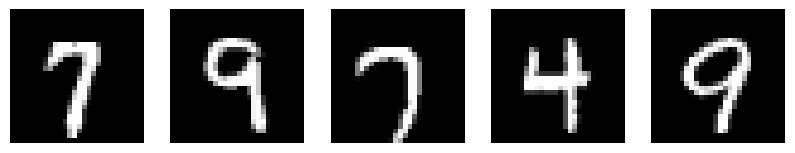

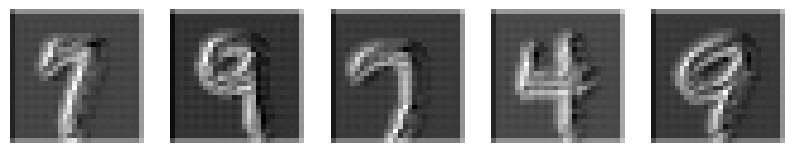

tensor([[0.4489],
        [0.4488],
        [0.4488],
        [0.4488],
        [0.4489]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

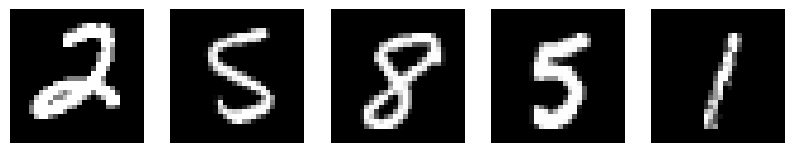

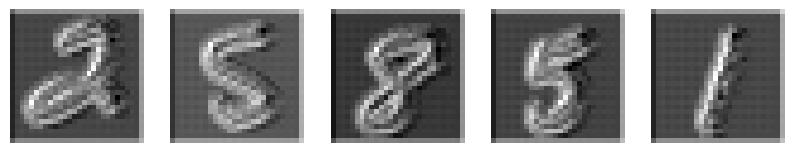

tensor([[0.4448],
        [0.4447],
        [0.4448],
        [0.4448],
        [0.4446]], device='cuda:0', grad_fn=<SigmoidBackward0>)

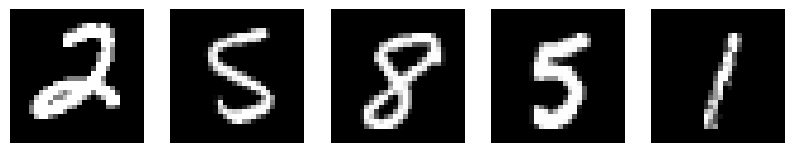

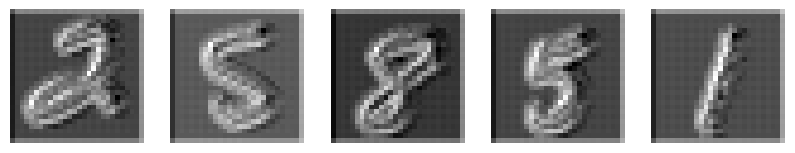

tensor([[0.4451],
        [0.4451],
        [0.4452],
        [0.4452],
        [0.4450]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

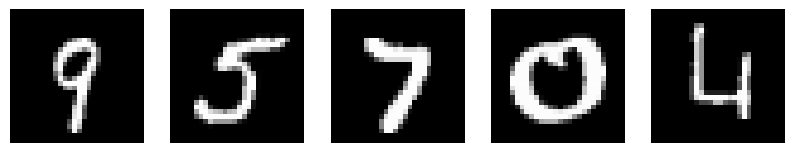

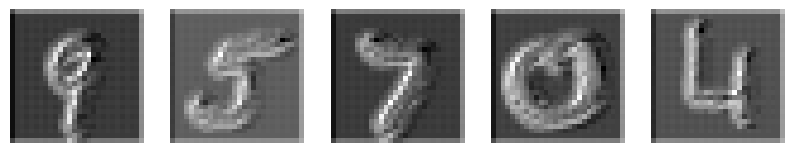

tensor([[0.4407],
        [0.4407],
        [0.4407],
        [0.4408],
        [0.4406]], device='cuda:0', grad_fn=<SigmoidBackward0>)

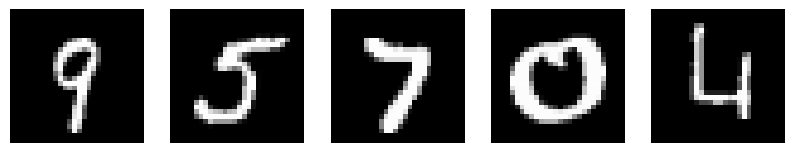

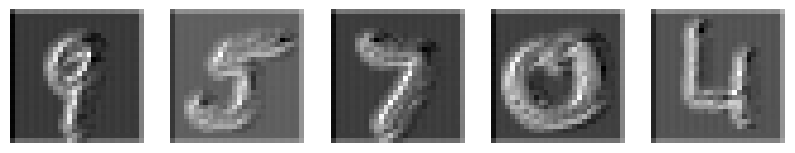

tensor([[0.4412],
        [0.4412],
        [0.4412],
        [0.4413],
        [0.4411]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

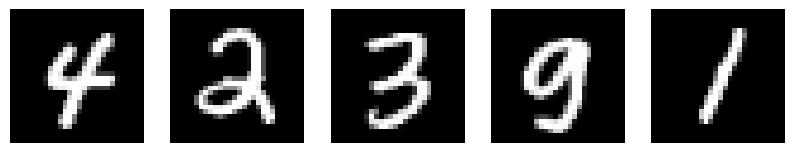

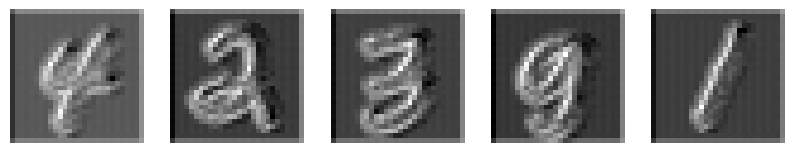

tensor([[0.4363],
        [0.4362],
        [0.4362],
        [0.4364],
        [0.4360]], device='cuda:0', grad_fn=<SigmoidBackward0>)

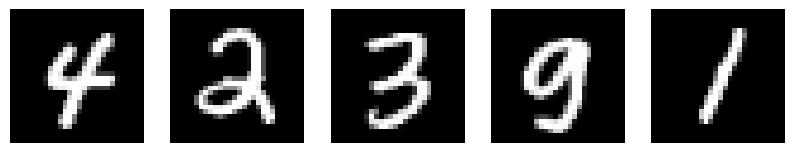

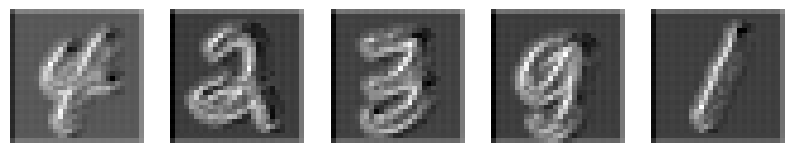

tensor([[0.4372],
        [0.4370],
        [0.4369],
        [0.4372],
        [0.4368]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

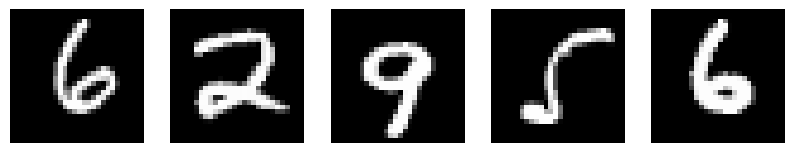

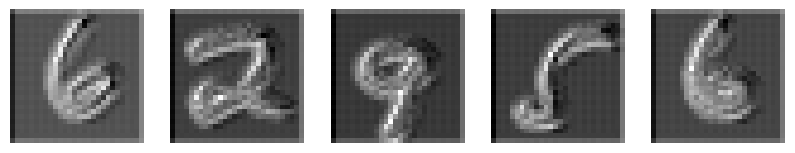

tensor([[0.4311],
        [0.4313],
        [0.4312],
        [0.4307],
        [0.4312]], device='cuda:0', grad_fn=<SigmoidBackward0>)

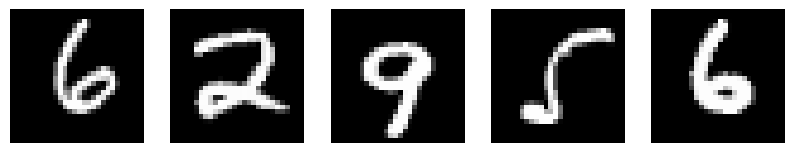

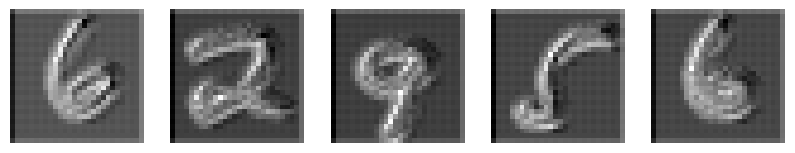

tensor([[0.4324],
        [0.4327],
        [0.4325],
        [0.4319],
        [0.4325]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

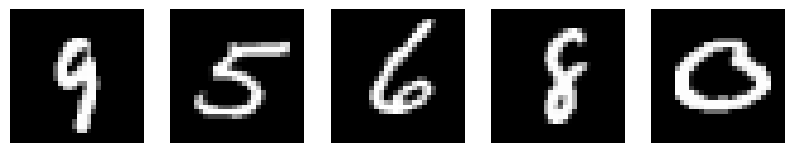

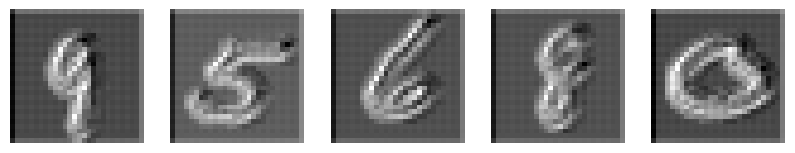

tensor([[0.4242],
        [0.4240],
        [0.4244],
        [0.4242],
        [0.4244]], device='cuda:0', grad_fn=<SigmoidBackward0>)

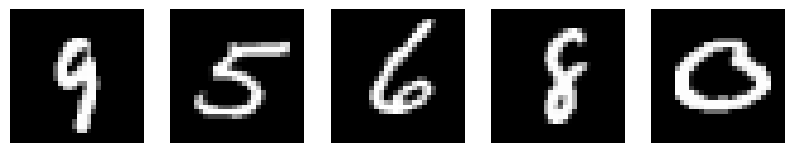

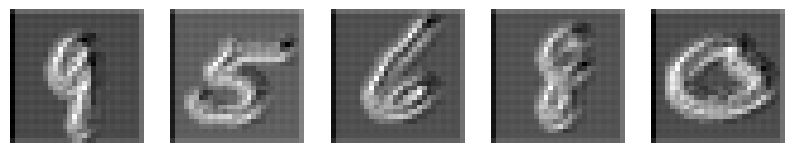

tensor([[0.4257],
        [0.4255],
        [0.4264],
        [0.4257],
        [0.4262]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

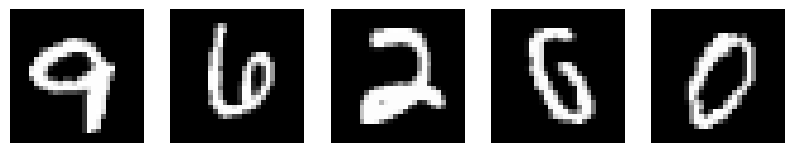

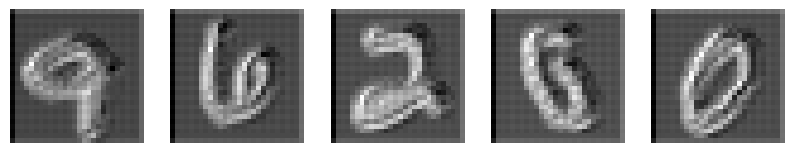

tensor([[0.4163],
        [0.4159],
        [0.4164],
        [0.4160],
        [0.4163]], device='cuda:0', grad_fn=<SigmoidBackward0>)

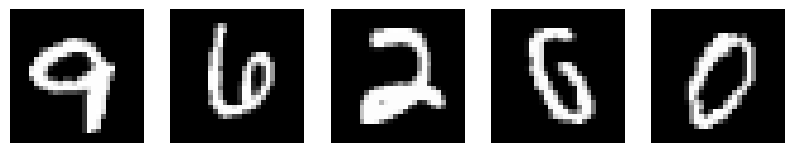

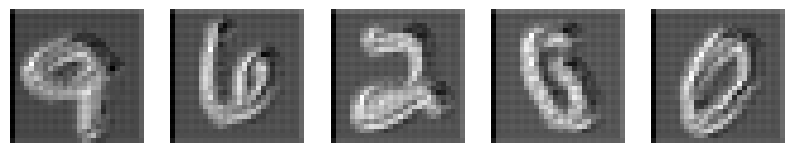

tensor([[0.4184],
        [0.4179],
        [0.4184],
        [0.4180],
        [0.4185]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

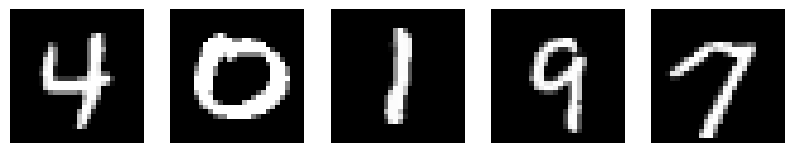

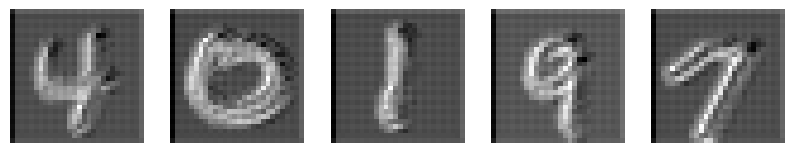

tensor([[0.4060],
        [0.4068],
        [0.4055],
        [0.4061],
        [0.4064]], device='cuda:0', grad_fn=<SigmoidBackward0>)

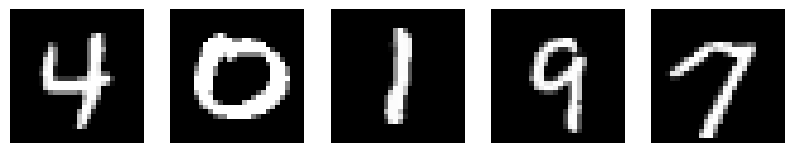

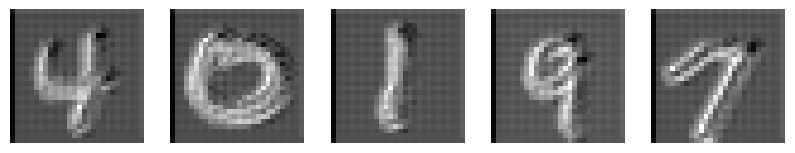

tensor([[0.4081],
        [0.4093],
        [0.4073],
        [0.4081],
        [0.4085]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

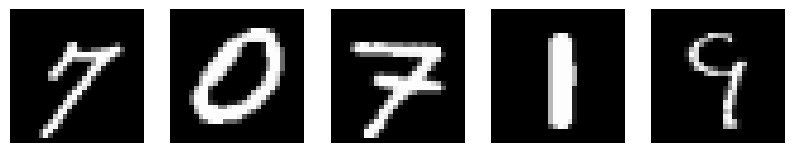

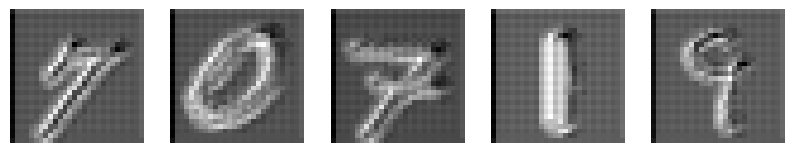

tensor([[0.3954],
        [0.3963],
        [0.3957],
        [0.3952],
        [0.3944]], device='cuda:0', grad_fn=<SigmoidBackward0>)

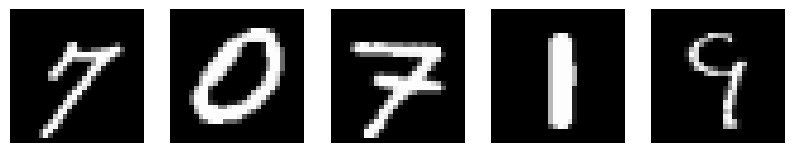

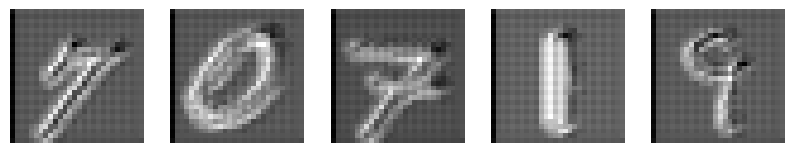

tensor([[0.3979],
        [0.3993],
        [0.3985],
        [0.3974],
        [0.3964]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

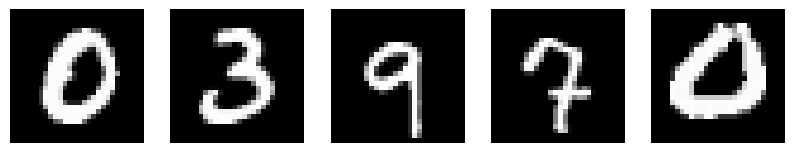

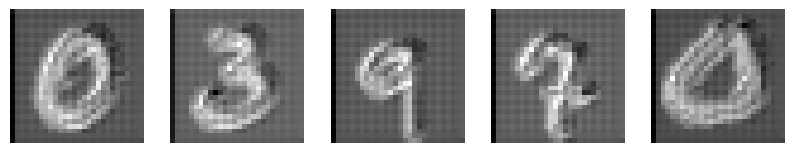

tensor([[0.3842],
        [0.3834],
        [0.3830],
        [0.3829],
        [0.3845]], device='cuda:0', grad_fn=<SigmoidBackward0>)

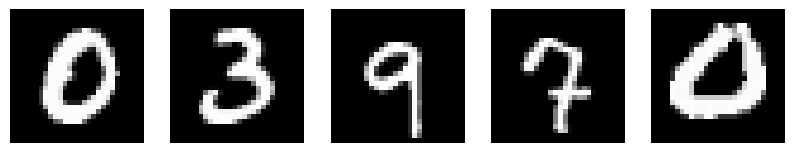

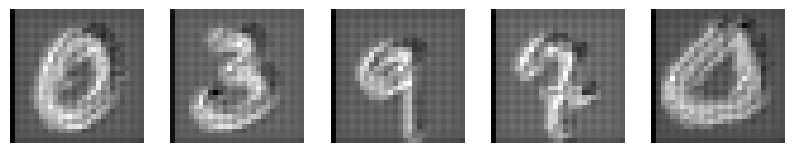

tensor([[0.3889],
        [0.3871],
        [0.3856],
        [0.3855],
        [0.3896]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

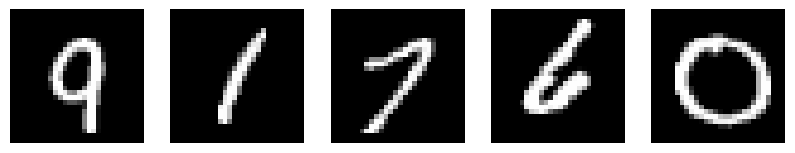

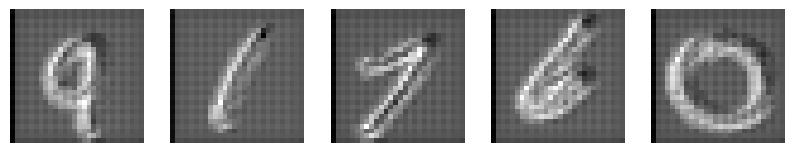

tensor([[0.3683],
        [0.3679],
        [0.3681],
        [0.3688],
        [0.3680]], device='cuda:0', grad_fn=<SigmoidBackward0>)

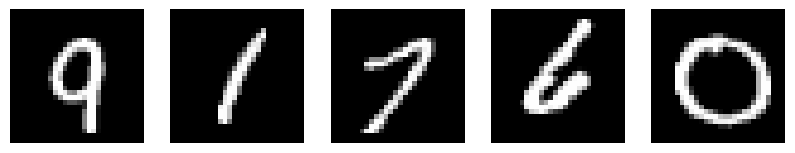

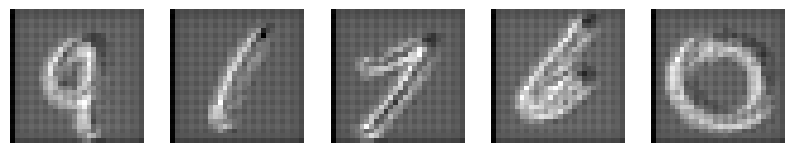

tensor([[0.3719],
        [0.3703],
        [0.3716],
        [0.3730],
        [0.3712]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

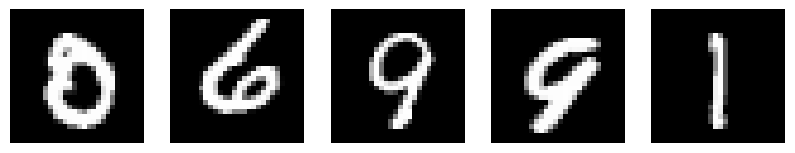

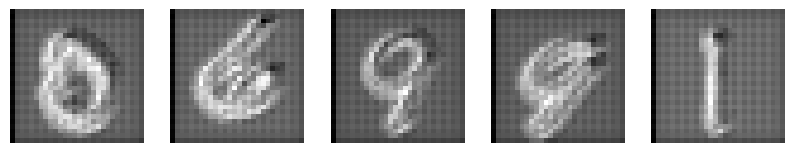

tensor([[0.3544],
        [0.3525],
        [0.3517],
        [0.3536],
        [0.3507]], device='cuda:0', grad_fn=<SigmoidBackward0>)

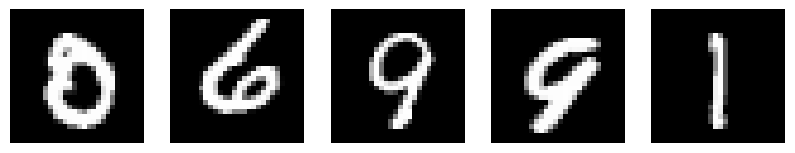

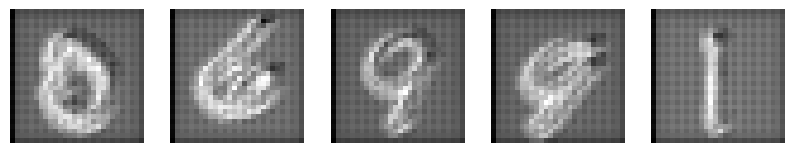

tensor([[0.3778],
        [0.3681],
        [0.3624],
        [0.3724],
        [0.3534]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

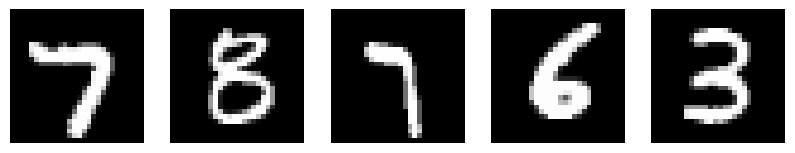

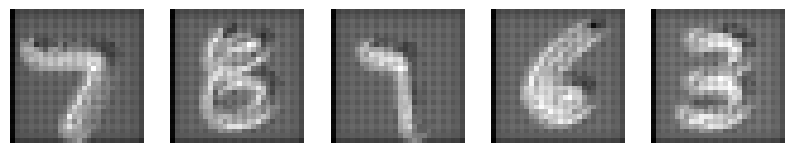

tensor([[0.3386],
        [0.3381],
        [0.3324],
        [0.3424],
        [0.3398]], device='cuda:0', grad_fn=<SigmoidBackward0>)

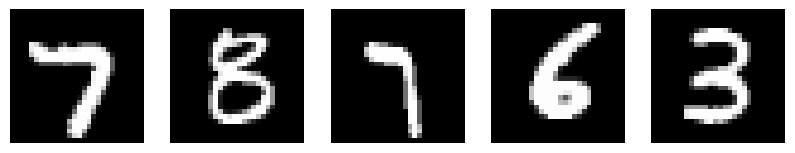

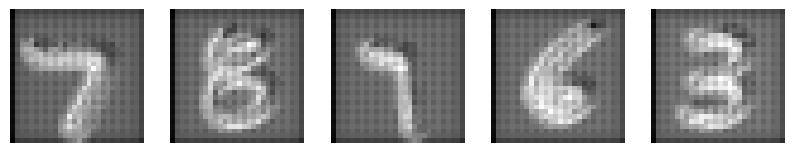

tensor([[0.3642],
        [0.3693],
        [0.3449],
        [0.3758],
        [0.3699]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

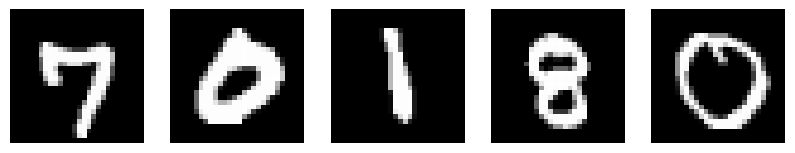

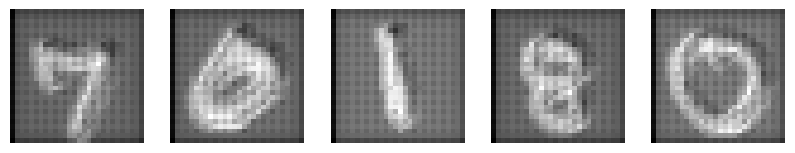

tensor([[0.3224],
        [0.3544],
        [0.3112],
        [0.3354],
        [0.3124]], device='cuda:0', grad_fn=<SigmoidBackward0>)

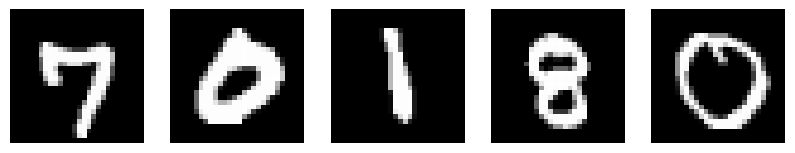

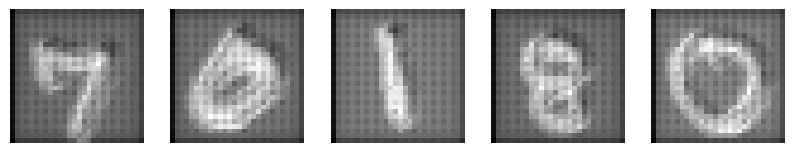

tensor([[0.3659],
        [0.4160],
        [0.3318],
        [0.3871],
        [0.3491]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

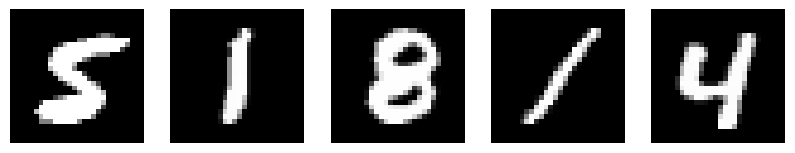

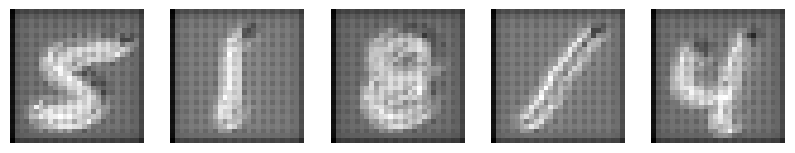

tensor([[0.3482],
        [0.2868],
        [0.3623],
        [0.2862],
        [0.3165]], device='cuda:0', grad_fn=<SigmoidBackward0>)

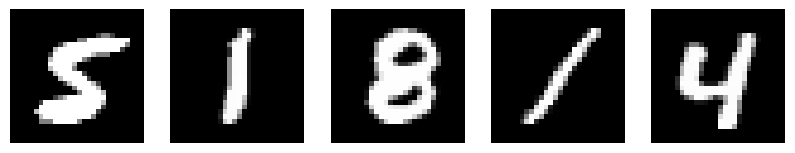

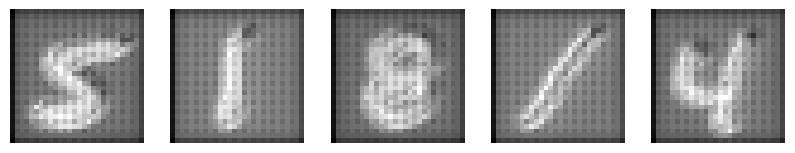

tensor([[0.4429],
        [0.3284],
        [0.4617],
        [0.3290],
        [0.3946]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

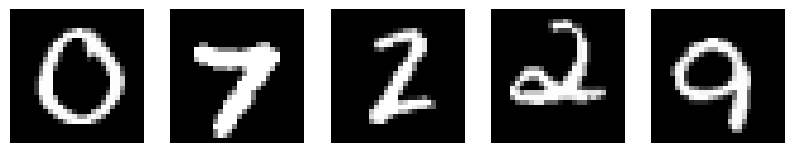

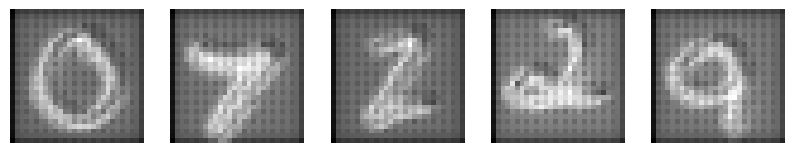

tensor([[0.2978],
        [0.3361],
        [0.2983],
        [0.2913],
        [0.2940]], device='cuda:0', grad_fn=<SigmoidBackward0>)

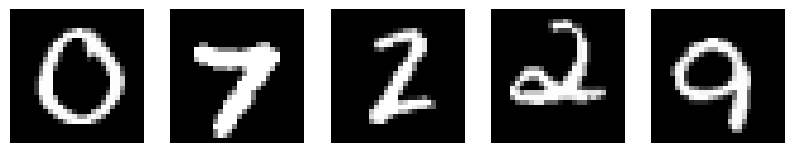

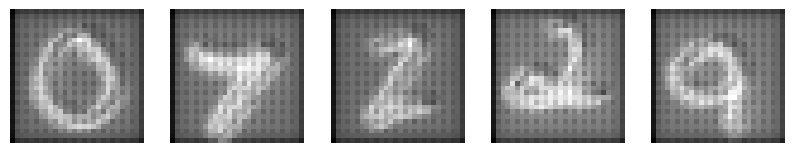

tensor([[0.4037],
        [0.4558],
        [0.4046],
        [0.3924],
        [0.3961]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

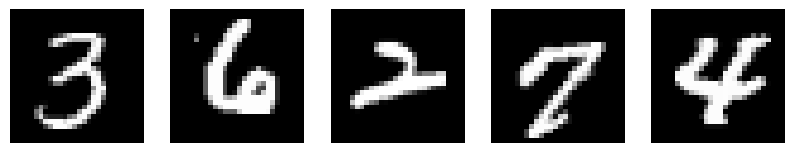

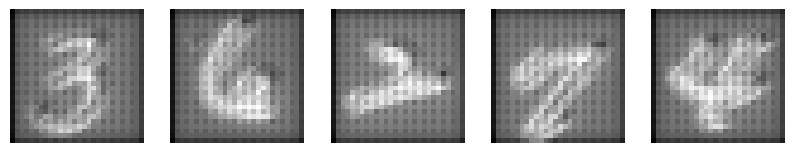

tensor([[0.2765],
        [0.3137],
        [0.2885],
        [0.2879],
        [0.3379]], device='cuda:0', grad_fn=<SigmoidBackward0>)

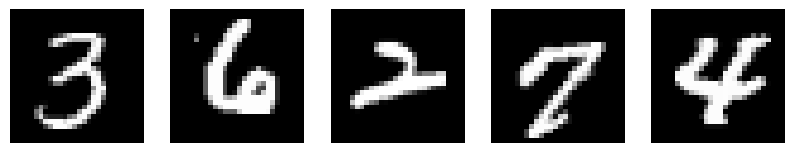

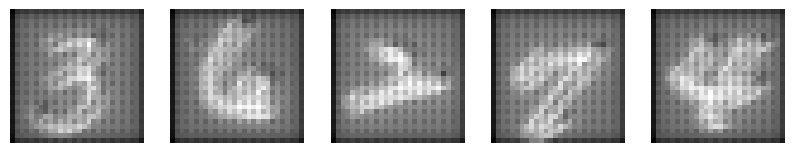

tensor([[0.4084],
        [0.4609],
        [0.4256],
        [0.4256],
        [0.4986]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

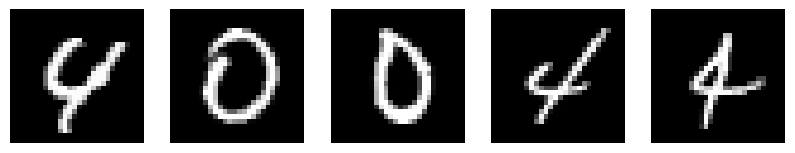

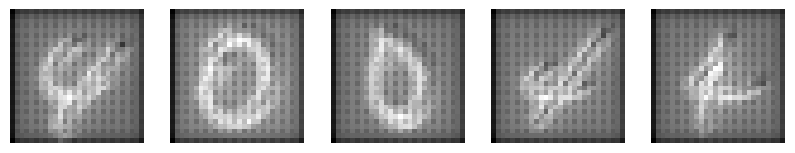

tensor([[0.2602],
        [0.2412],
        [0.2448],
        [0.2336],
        [0.2477]], device='cuda:0', grad_fn=<SigmoidBackward0>)

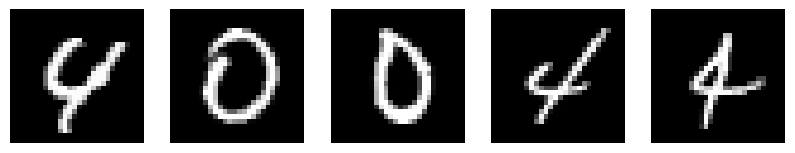

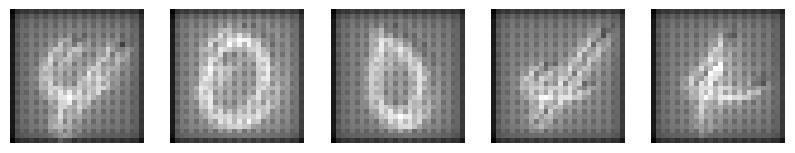

tensor([[0.4057],
        [0.3697],
        [0.3761],
        [0.3602],
        [0.3887]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

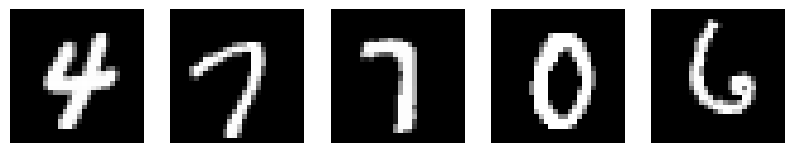

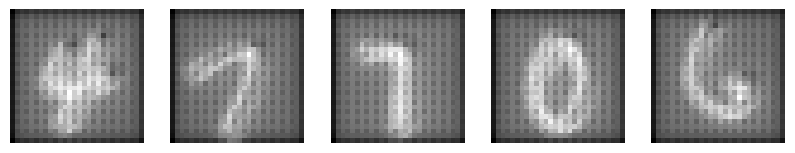

tensor([[0.2443],
        [0.1863],
        [0.1874],
        [0.2289],
        [0.1889]], device='cuda:0', grad_fn=<SigmoidBackward0>)

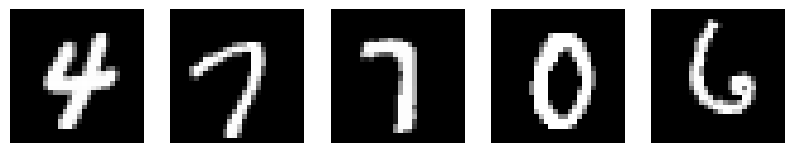

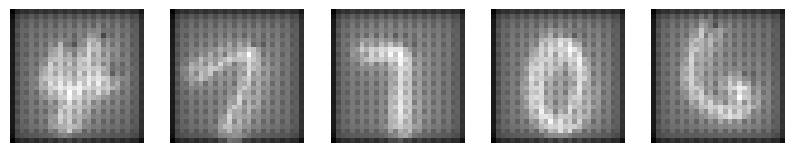

tensor([[0.3786],
        [0.2774],
        [0.2834],
        [0.3513],
        [0.2829]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

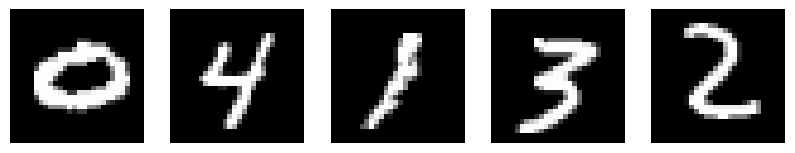

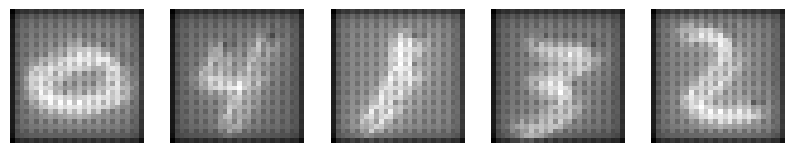

tensor([[0.1265],
        [0.1214],
        [0.1146],
        [0.1331],
        [0.1112]], device='cuda:0', grad_fn=<SigmoidBackward0>)

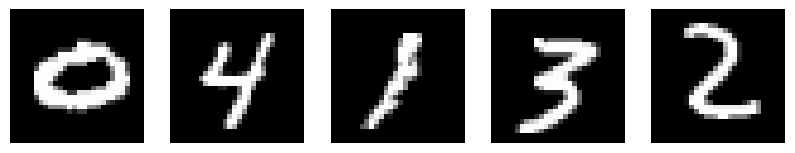

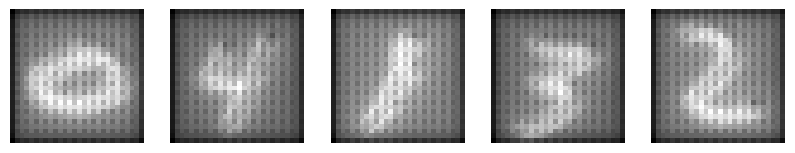

tensor([[0.1632],
        [0.1580],
        [0.1441],
        [0.1762],
        [0.1393]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

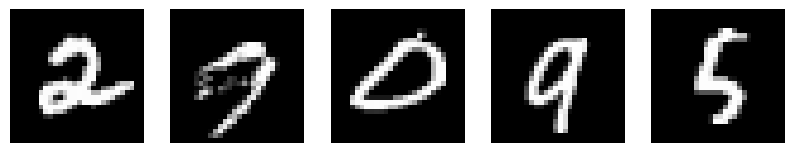

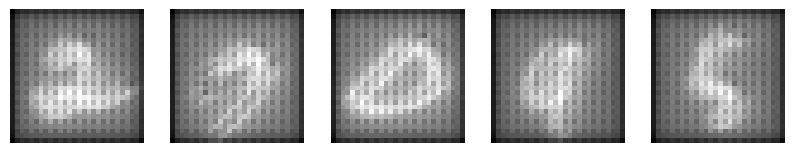

tensor([[0.0384],
        [0.0415],
        [0.0355],
        [0.0399],
        [0.0407]], device='cuda:0', grad_fn=<SigmoidBackward0>)

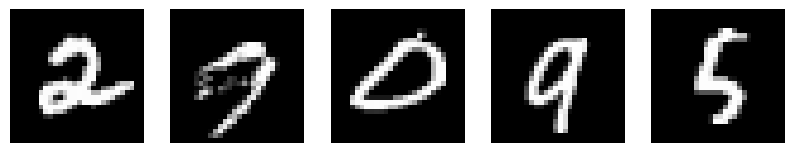

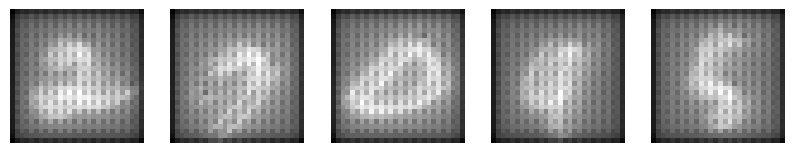

tensor([[0.0347],
        [0.0386],
        [0.0316],
        [0.0365],
        [0.0375]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

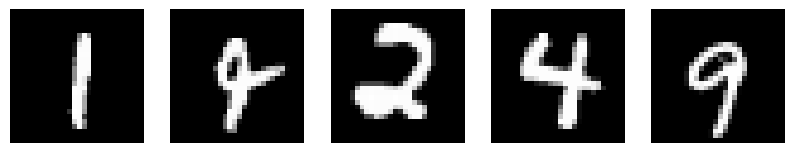

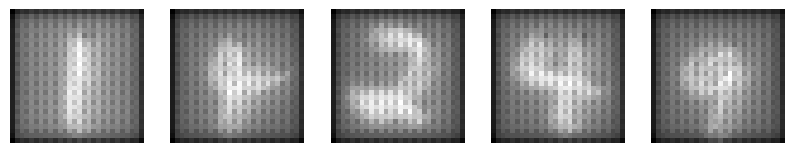

tensor([[0.0131],
        [0.0095],
        [0.0063],
        [0.0077],
        [0.0092]], device='cuda:0', grad_fn=<SigmoidBackward0>)

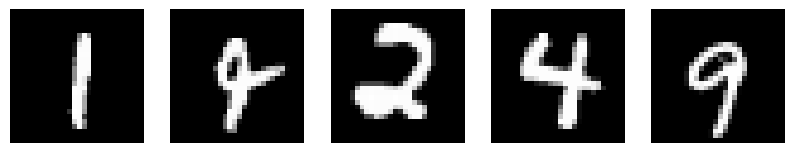

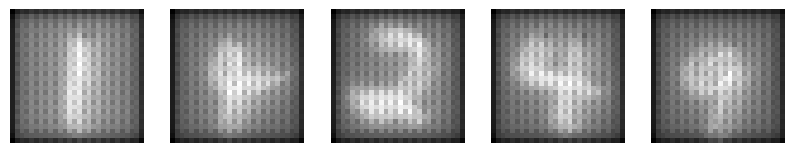

tensor([[0.0080],
        [0.0057],
        [0.0036],
        [0.0044],
        [0.0055]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

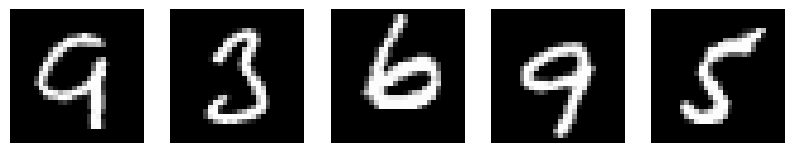

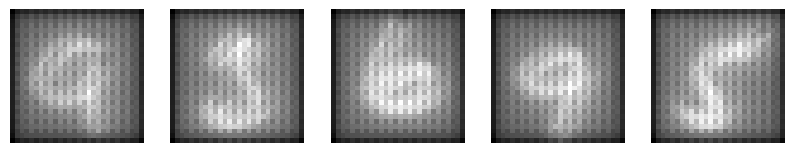

tensor([[0.0015],
        [0.0017],
        [0.0012],
        [0.0015],
        [0.0018]], device='cuda:0', grad_fn=<SigmoidBackward0>)

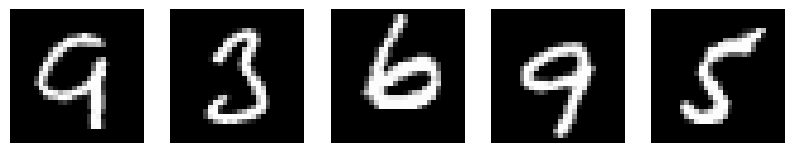

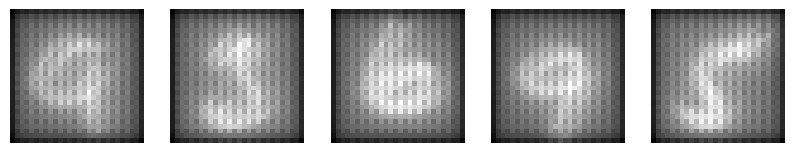

tensor([[0.0006],
        [0.0007],
        [0.0005],
        [0.0006],
        [0.0008]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

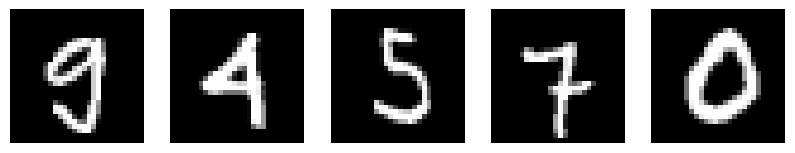

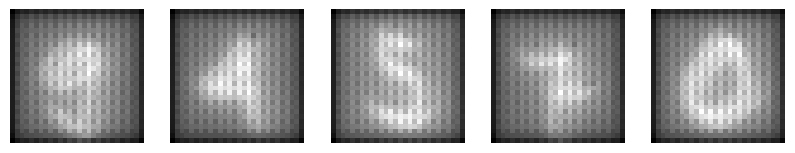

tensor([[0.0002],
        [0.0003],
        [0.0005],
        [0.0004],
        [0.0002]], device='cuda:0', grad_fn=<SigmoidBackward0>)

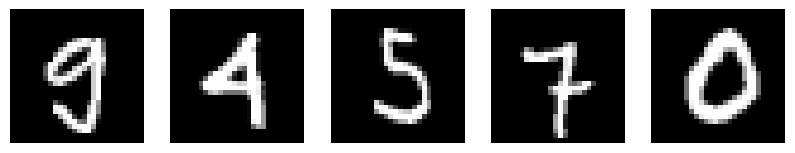

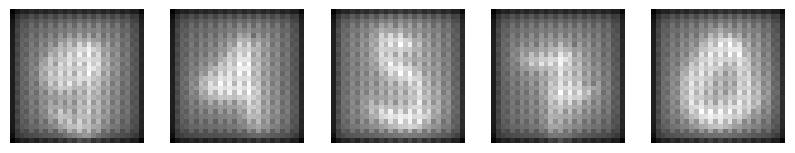

tensor([[7.8532e-05],
        [9.4199e-05],
        [1.7180e-04],
        [1.5257e-04],
        [6.3926e-05]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

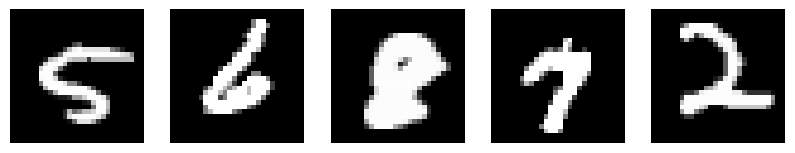

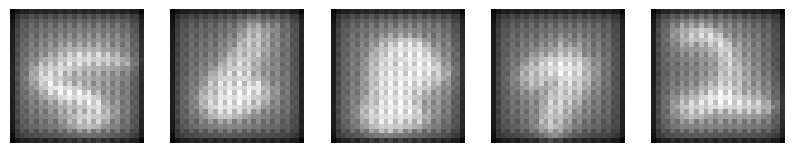

tensor([[3.1212e-05],
        [2.0261e-05],
        [1.6201e-05],
        [2.7547e-05],
        [2.4001e-05]], device='cuda:0', grad_fn=<SigmoidBackward0>)

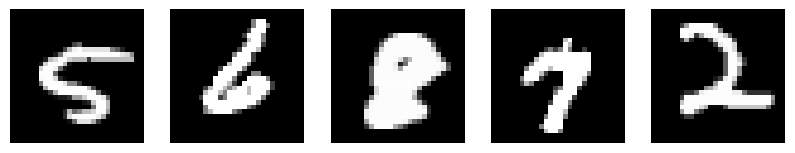

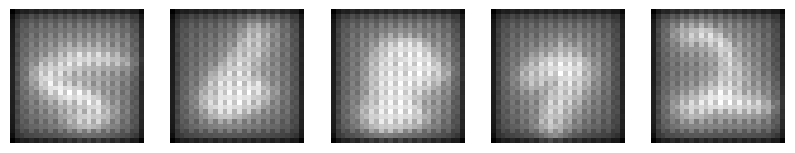

tensor([[8.8477e-06],
        [5.4341e-06],
        [4.2452e-06],
        [7.6601e-06],
        [6.6601e-06]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

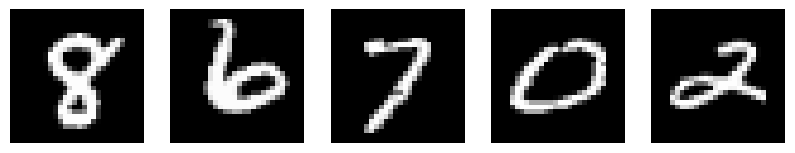

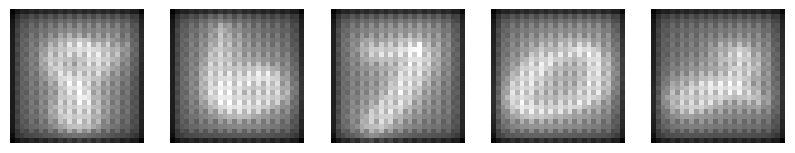

tensor([[2.7054e-06],
        [3.1019e-06],
        [9.4022e-06],
        [4.7717e-06],
        [5.1669e-06]], device='cuda:0', grad_fn=<SigmoidBackward0>)

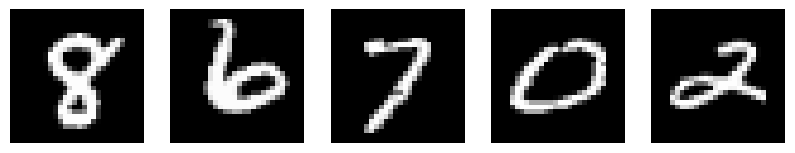

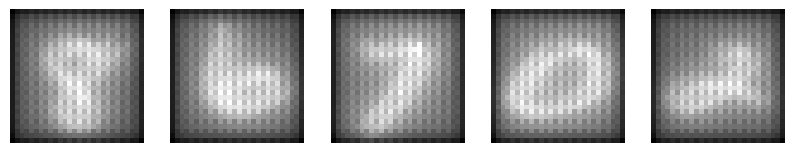

tensor([[6.4164e-07],
        [7.4360e-07],
        [2.6236e-06],
        [1.2101e-06],
        [1.3291e-06]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

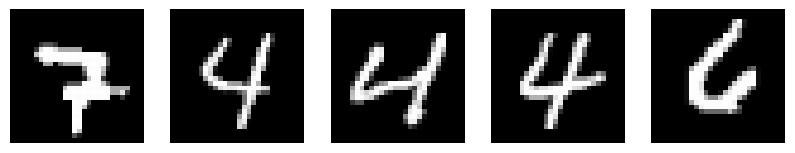

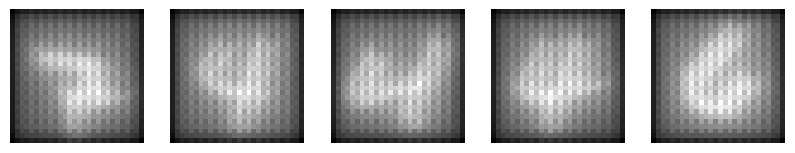

tensor([[4.8862e-07],
        [1.1714e-06],
        [5.4224e-07],
        [4.4192e-07],
        [4.4712e-07]], device='cuda:0', grad_fn=<SigmoidBackward0>)

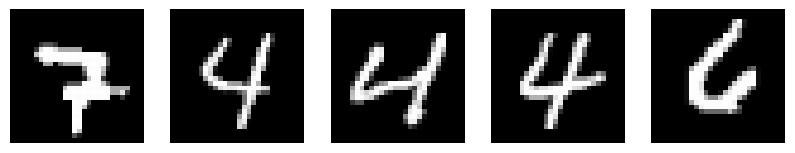

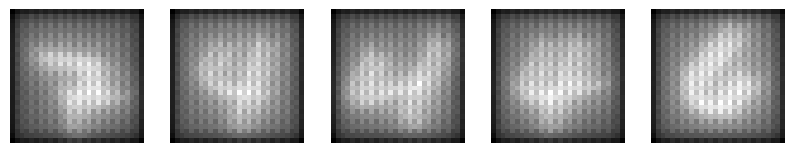

tensor([[1.1149e-07],
        [2.9307e-07],
        [1.2420e-07],
        [9.8498e-08],
        [1.0067e-07]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

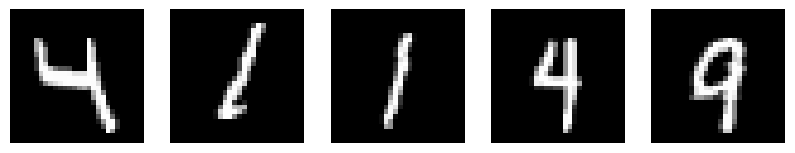

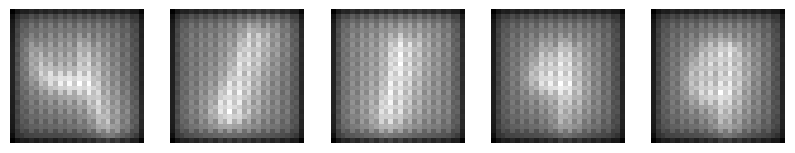

tensor([[1.5493e-07],
        [5.7244e-07],
        [1.2284e-06],
        [2.0939e-07],
        [1.2263e-07]], device='cuda:0', grad_fn=<SigmoidBackward0>)

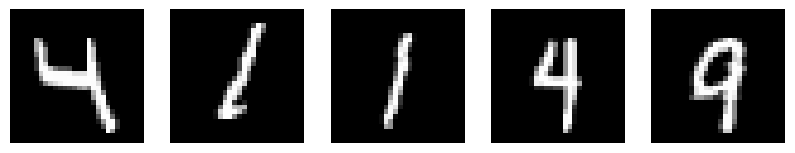

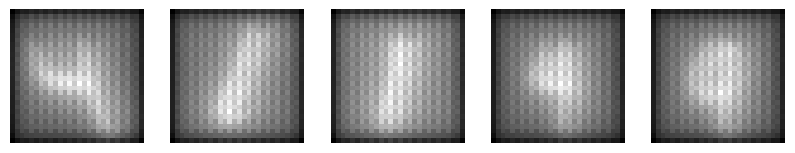

tensor([[3.6366e-08],
        [1.5532e-07],
        [3.5997e-07],
        [5.0601e-08],
        [2.7960e-08]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

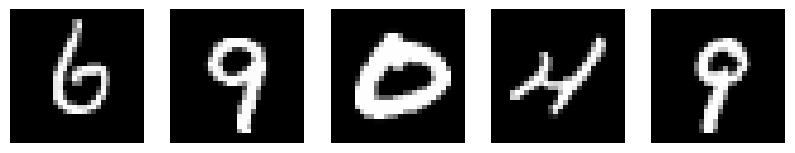

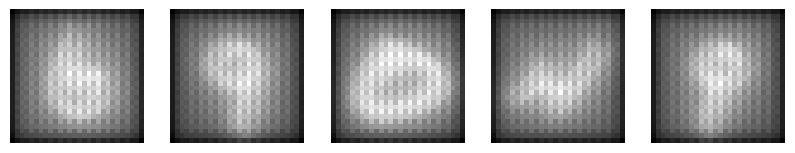

tensor([[2.2305e-08],
        [9.0710e-09],
        [1.4860e-09],
        [2.3069e-08],
        [1.4427e-08]], device='cuda:0', grad_fn=<SigmoidBackward0>)

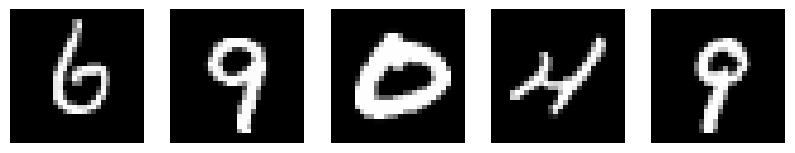

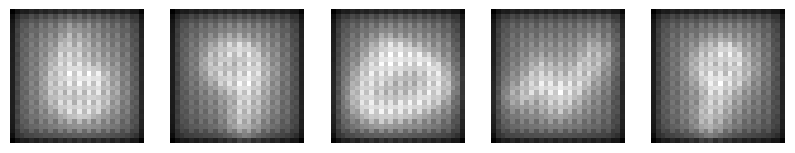

tensor([[5.0785e-09],
        [1.9041e-09],
        [2.6466e-10],
        [5.2813e-09],
        [3.1483e-09]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

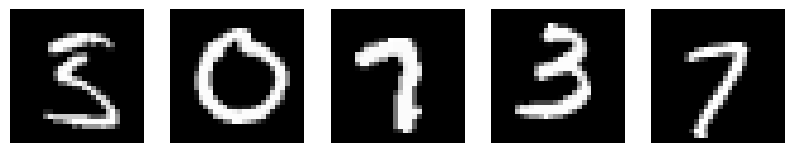

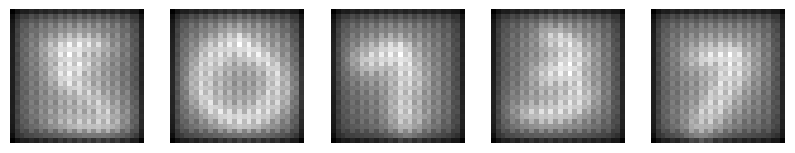

tensor([[2.6223e-09],
        [7.0410e-10],
        [2.1211e-09],
        [1.0279e-09],
        [5.5998e-09]], device='cuda:0', grad_fn=<SigmoidBackward0>)

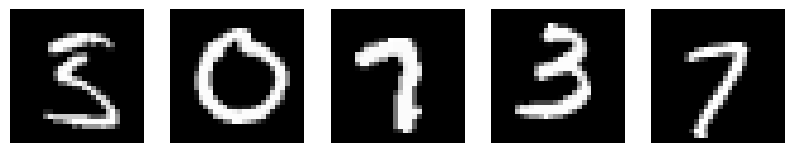

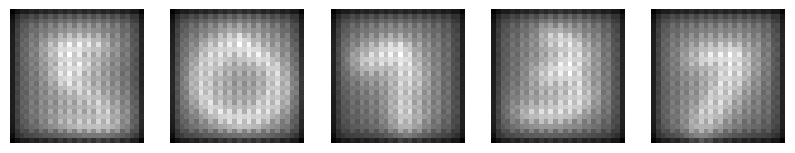

tensor([[5.8091e-10],
        [1.4019e-10],
        [4.6494e-10],
        [2.1179e-10],
        [1.3329e-09]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

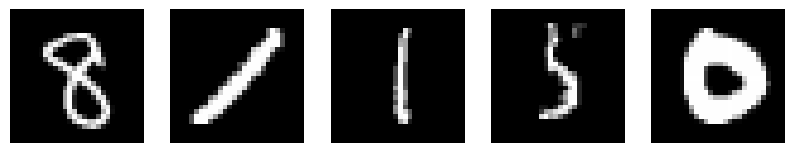

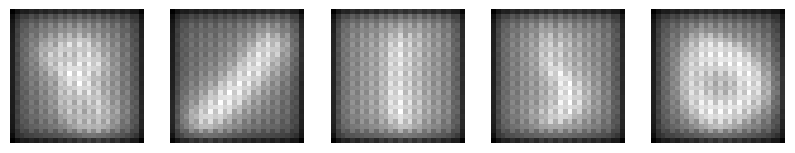

tensor([[4.7683e-10],
        [8.9766e-10],
        [2.7983e-08],
        [6.9476e-09],
        [2.3930e-11]], device='cuda:0', grad_fn=<SigmoidBackward0>)

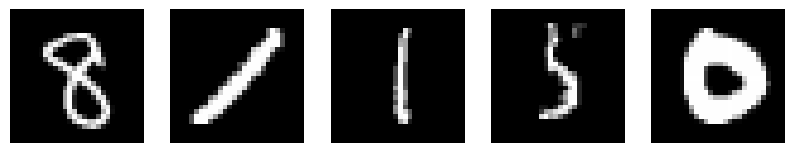

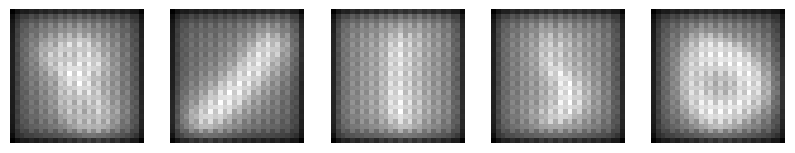

tensor([[1.0731e-10],
        [2.1407e-10],
        [8.7010e-09],
        [1.9344e-09],
        [4.3648e-12]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

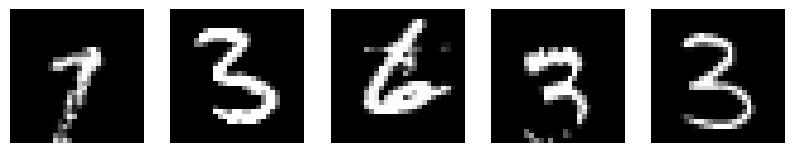

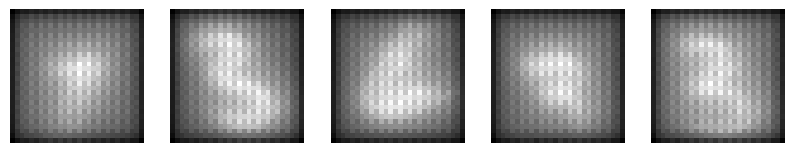

tensor([[1.0959e-09],
        [1.0107e-11],
        [1.4153e-11],
        [1.3532e-10],
        [2.0892e-10]], device='cuda:0', grad_fn=<SigmoidBackward0>)

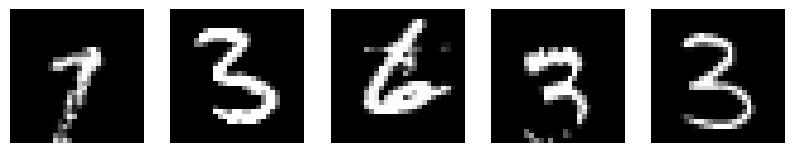

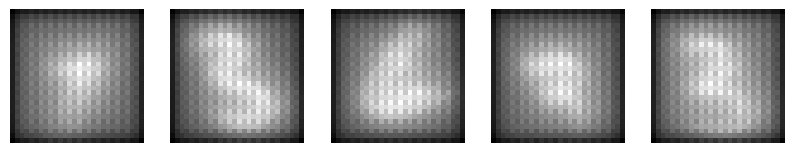

tensor([[3.0618e-10],
        [2.0501e-12],
        [2.9266e-12],
        [3.2798e-11],
        [5.2068e-11]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

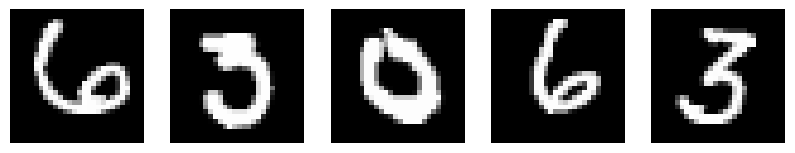

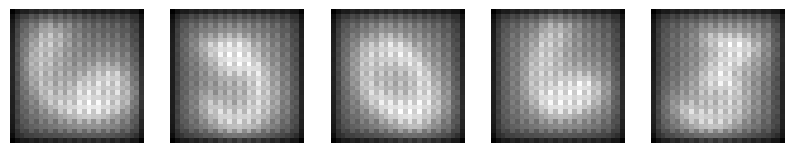

tensor([[1.1203e-11],
        [5.1262e-12],
        [1.8973e-12],
        [1.6678e-11],
        [8.8865e-12]], device='cuda:0', grad_fn=<SigmoidBackward0>)

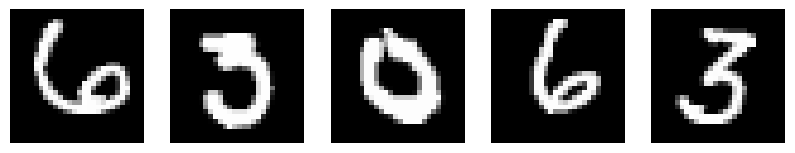

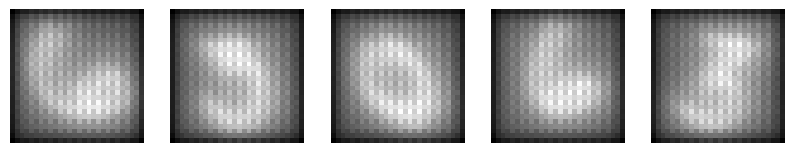

tensor([[2.6744e-12],
        [1.1710e-12],
        [4.0487e-13],
        [4.0827e-12],
        [2.0906e-12]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

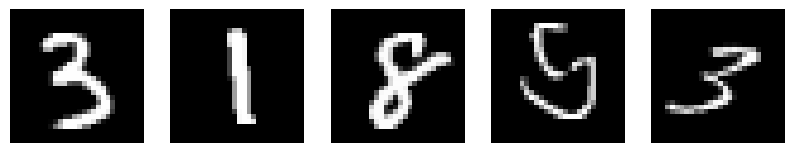

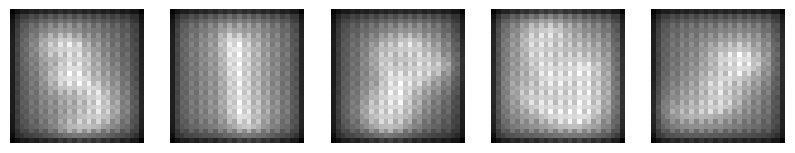

tensor([[4.9965e-12],
        [1.4467e-10],
        [1.6062e-12],
        [5.9468e-11],
        [7.8374e-11]], device='cuda:0', grad_fn=<SigmoidBackward0>)

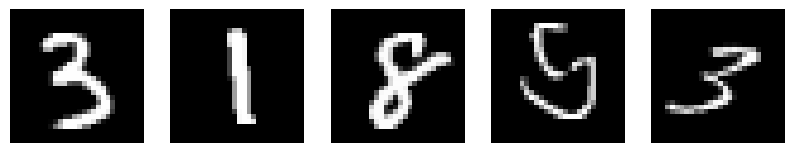

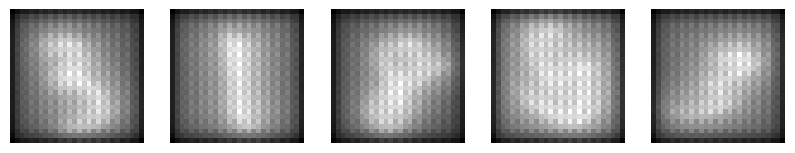

tensor([[1.3101e-12],
        [4.6057e-11],
        [3.9329e-13],
        [1.7891e-11],
        [2.4174e-11]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

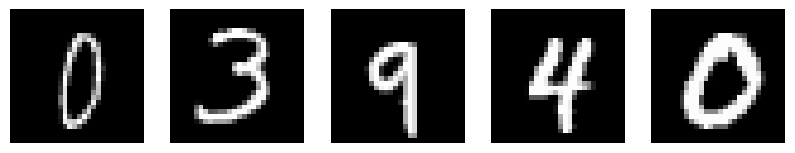

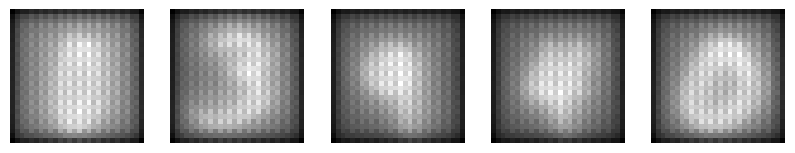

tensor([[8.8683e-11],
        [5.1065e-12],
        [3.4816e-12],
        [8.9754e-13],
        [4.7234e-13]], device='cuda:0', grad_fn=<SigmoidBackward0>)

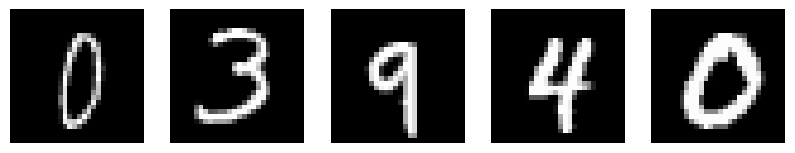

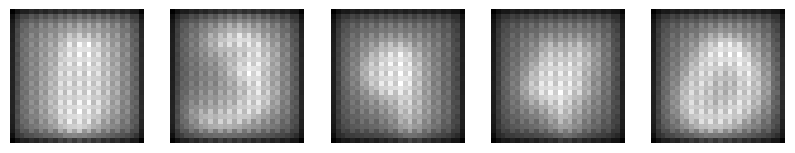

tensor([[3.0640e-11],
        [1.5384e-12],
        [1.0183e-12],
        [2.4612e-13],
        [1.2495e-13]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

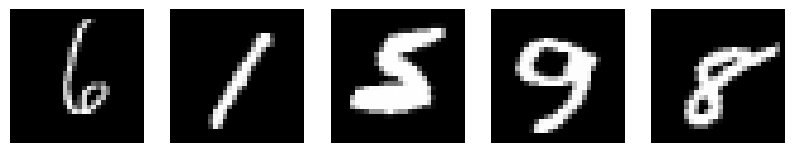

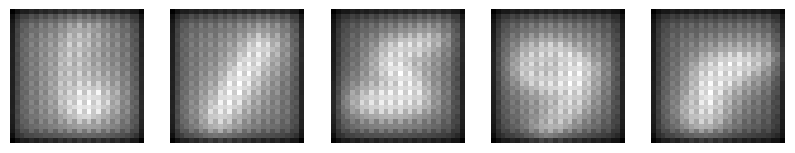

tensor([[8.4934e-11],
        [2.8466e-11],
        [4.4925e-14],
        [1.1446e-13],
        [5.2068e-13]], device='cuda:0', grad_fn=<SigmoidBackward0>)

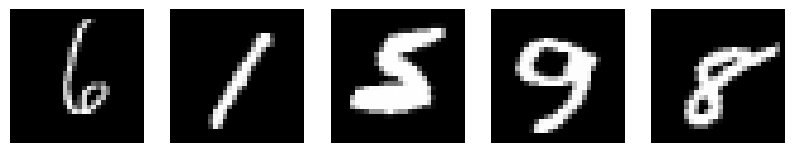

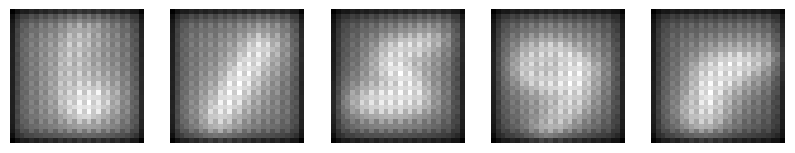

tensor([[3.2602e-11],
        [1.0428e-11],
        [1.2222e-14],
        [3.2217e-14],
        [1.5748e-13]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

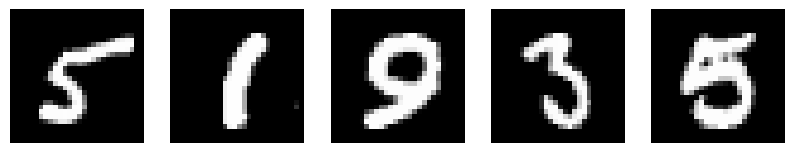

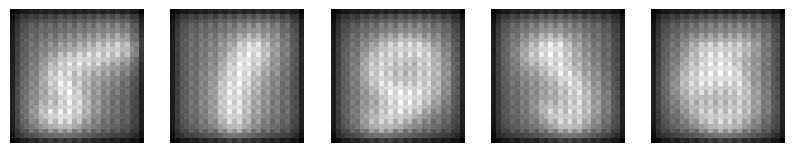

tensor([[8.9314e-13],
        [4.8247e-12],
        [4.7941e-14],
        [8.3338e-13],
        [3.3465e-14]], device='cuda:0', grad_fn=<SigmoidBackward0>)

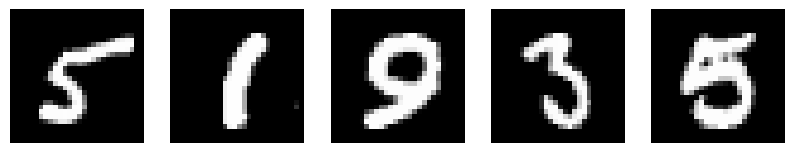

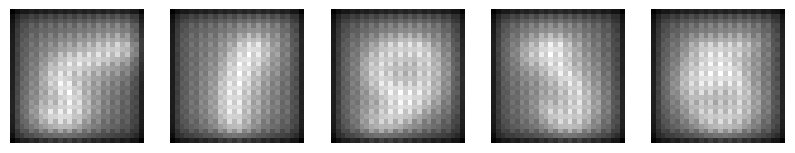

tensor([[3.0997e-13],
        [1.8021e-12],
        [1.4705e-14],
        [2.8818e-13],
        [1.0086e-14]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

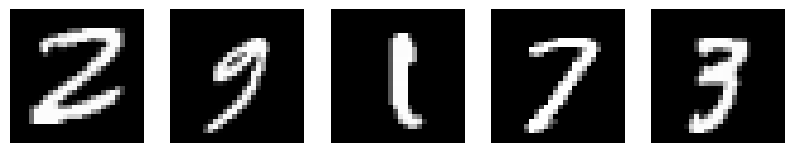

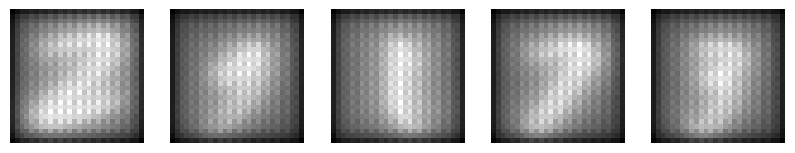

tensor([[4.1847e-14],
        [1.2983e-12],
        [1.6821e-11],
        [5.2484e-13],
        [4.6270e-13]], device='cuda:0', grad_fn=<SigmoidBackward0>)

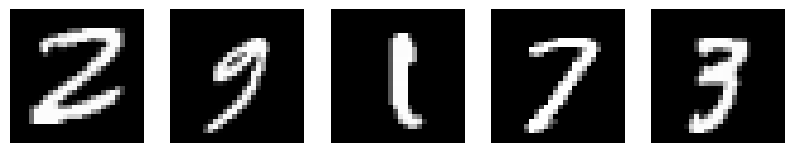

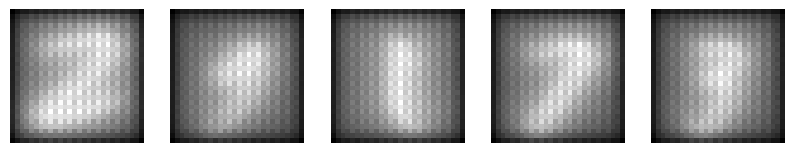

tensor([[1.4381e-14],
        [5.0605e-13],
        [7.2201e-12],
        [1.9928e-13],
        [1.7323e-13]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

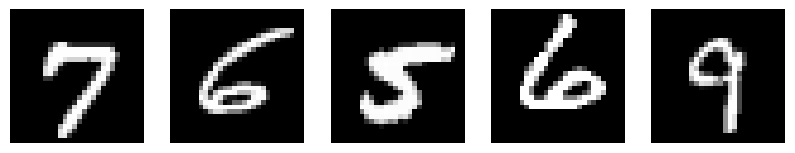

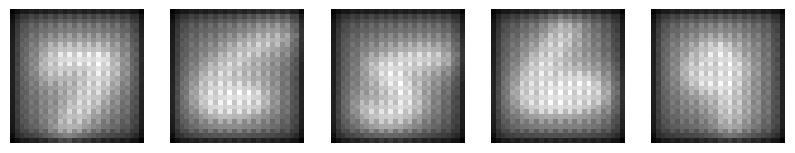

tensor([[5.9321e-13],
        [2.6190e-13],
        [1.2701e-13],
        [2.8283e-14],
        [1.7059e-12]], device='cuda:0', grad_fn=<SigmoidBackward0>)

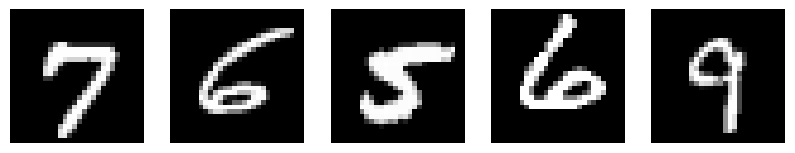

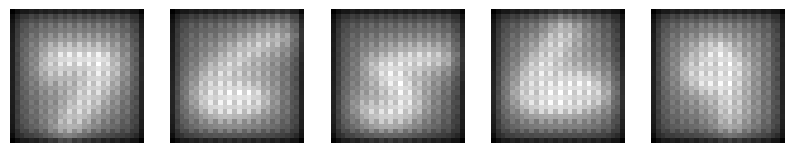

tensor([[2.4664e-13],
        [1.0602e-13],
        [4.9803e-14],
        [1.0556e-14],
        [7.3469e-13]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

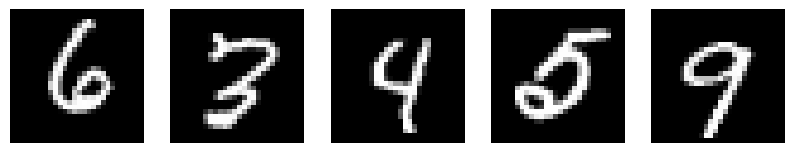

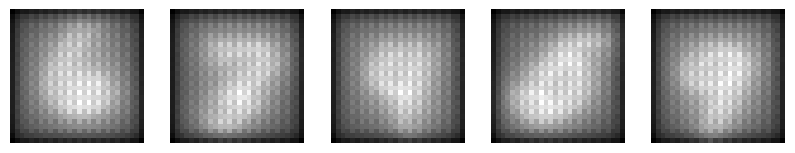

tensor([[9.0586e-13],
        [7.1003e-13],
        [5.1153e-12],
        [1.1685e-13],
        [8.1565e-13]], device='cuda:0', grad_fn=<SigmoidBackward0>)

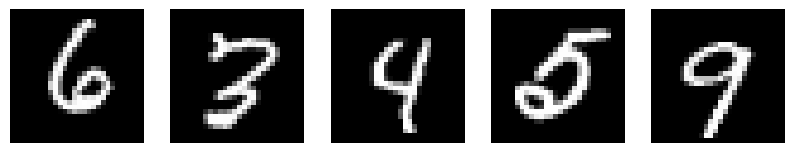

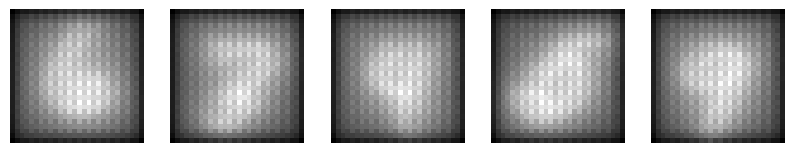

tensor([[4.1301e-13],
        [3.2145e-13],
        [2.4610e-12],
        [4.9934e-14],
        [3.7148e-13]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

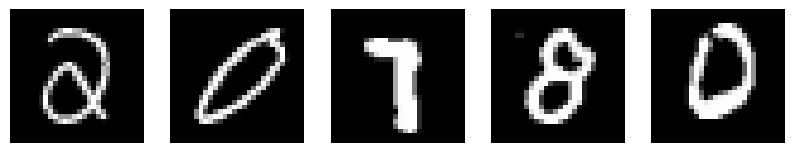

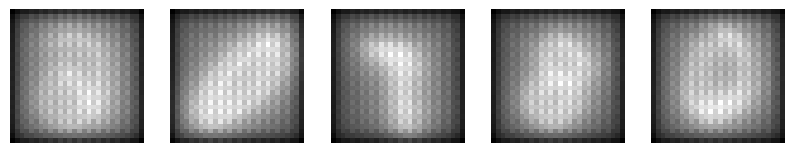

tensor([[4.0101e-12],
        [2.1250e-12],
        [3.3992e-12],
        [2.5262e-13],
        [7.3372e-13]], device='cuda:0', grad_fn=<SigmoidBackward0>)

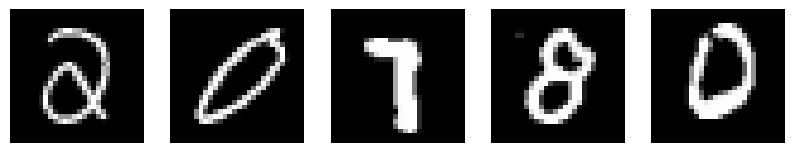

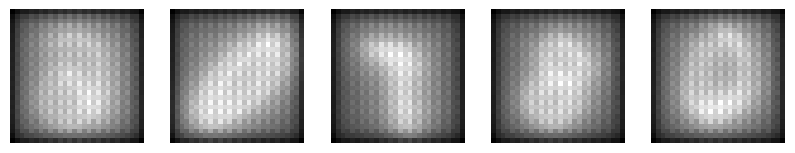

tensor([[2.0477e-12],
        [1.0681e-12],
        [1.7316e-12],
        [1.1904e-13],
        [3.5757e-13]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

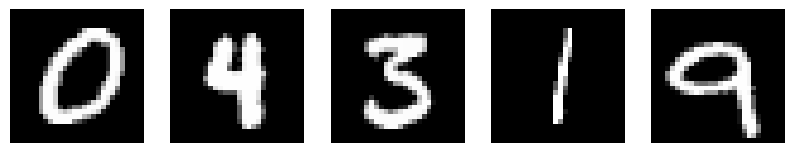

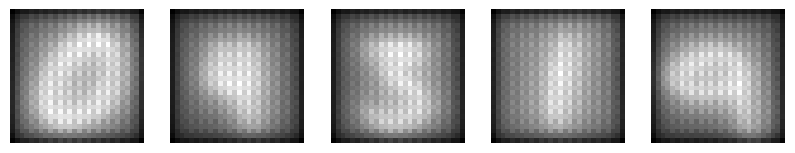

tensor([[8.1860e-13],
        [1.1591e-12],
        [9.6077e-13],
        [4.7420e-10],
        [8.9973e-13]], device='cuda:0', grad_fn=<SigmoidBackward0>)

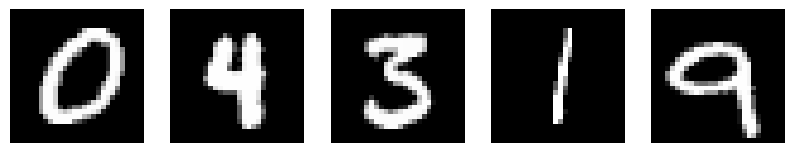

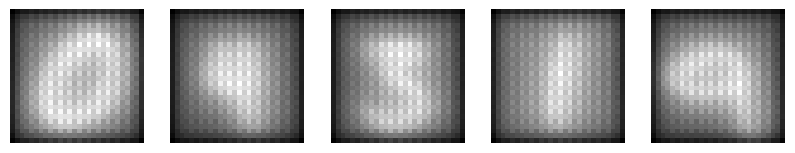

tensor([[4.2697e-13],
        [6.0949e-13],
        [5.0227e-13],
        [2.9223e-10],
        [4.7096e-13]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

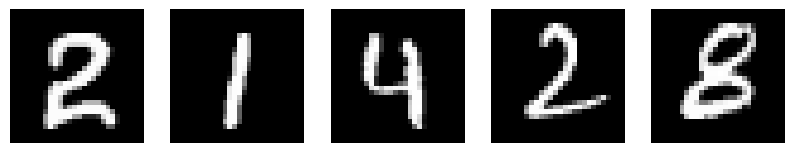

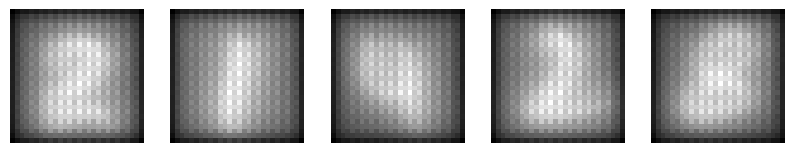

tensor([[1.5957e-12],
        [4.7398e-10],
        [2.6885e-11],
        [2.1803e-11],
        [1.0019e-12]], device='cuda:0', grad_fn=<SigmoidBackward0>)

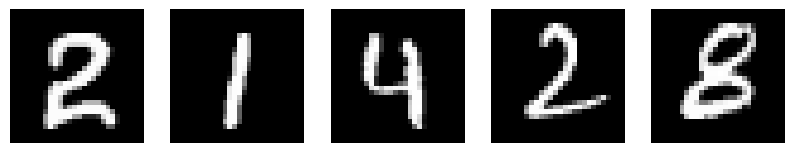

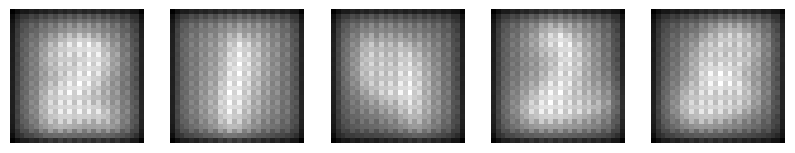

tensor([[8.9544e-13],
        [3.0407e-10],
        [1.6112e-11],
        [1.3035e-11],
        [5.5654e-13]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

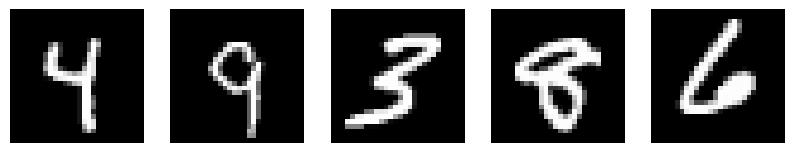

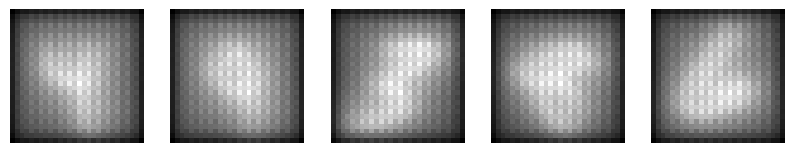

tensor([[3.7060e-10],
        [4.8666e-10],
        [2.6361e-11],
        [3.6669e-12],
        [1.9112e-11]], device='cuda:0', grad_fn=<SigmoidBackward0>)

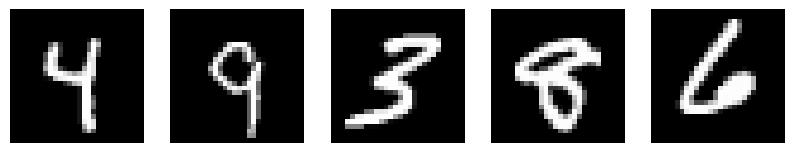

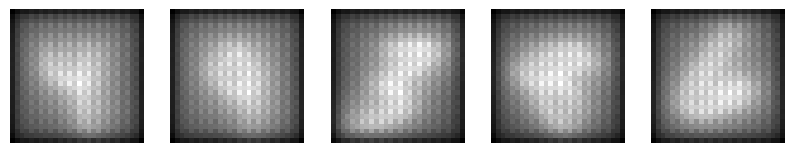

tensor([[2.4518e-10],
        [3.2441e-10],
        [1.6524e-11],
        [2.1978e-12],
        [1.1902e-11]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

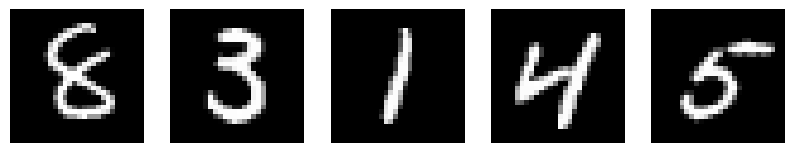

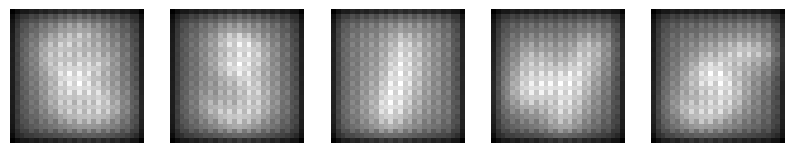

tensor([[1.5987e-10],
        [3.0467e-10],
        [1.2555e-08],
        [2.2047e-10],
        [8.3406e-10]], device='cuda:0', grad_fn=<SigmoidBackward0>)

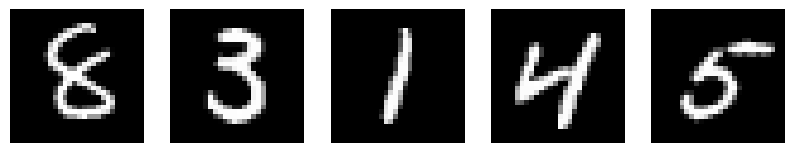

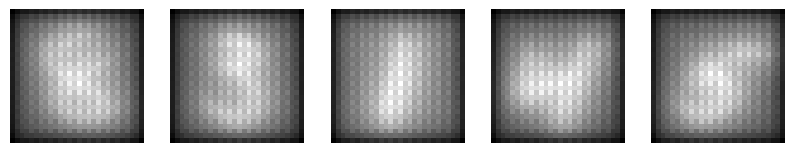

tensor([[1.0790e-10],
        [2.0836e-10],
        [9.2273e-09],
        [1.4960e-10],
        [5.8117e-10]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

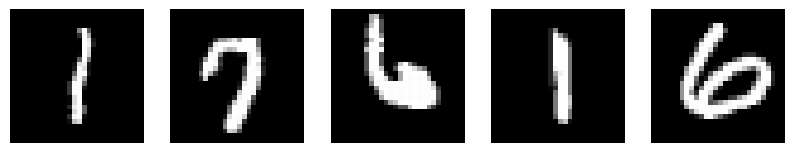

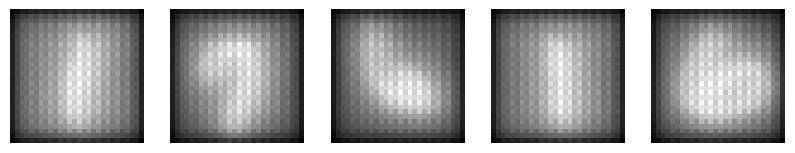

tensor([[1.4334e-07],
        [3.9894e-09],
        [2.5848e-09],
        [1.0912e-07],
        [4.8521e-10]], device='cuda:0', grad_fn=<SigmoidBackward0>)

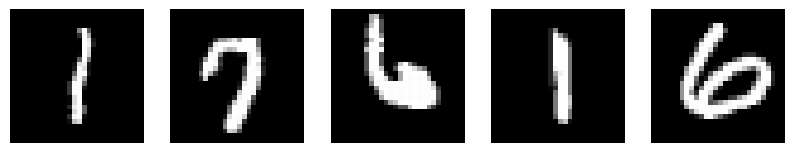

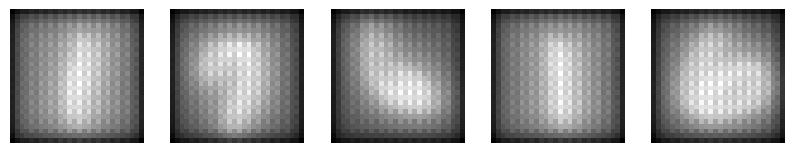

tensor([[1.1269e-07],
        [2.9393e-09],
        [1.8912e-09],
        [8.5283e-08],
        [3.4442e-10]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

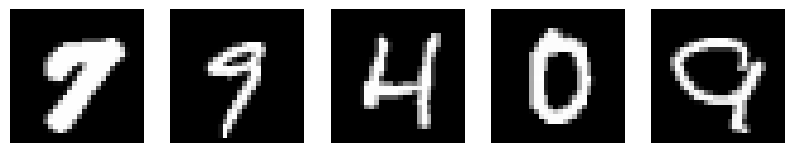

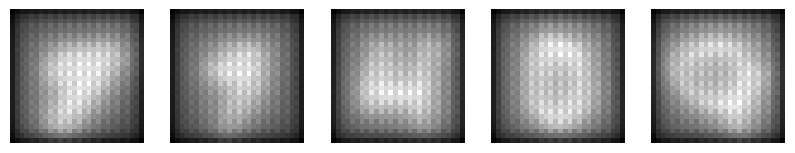

tensor([[1.4096e-08],
        [6.9450e-08],
        [7.5555e-08],
        [2.8619e-08],
        [3.7052e-08]], device='cuda:0', grad_fn=<SigmoidBackward0>)

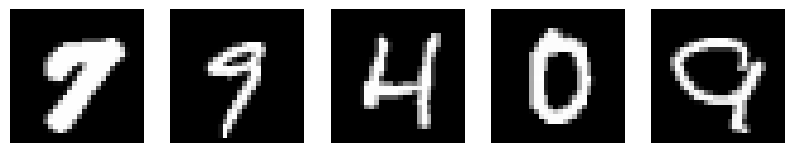

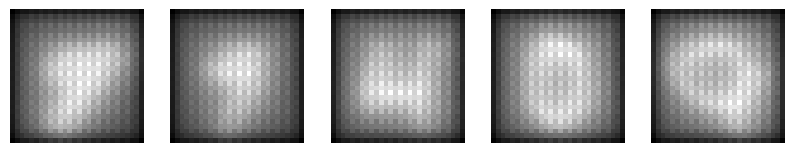

tensor([[1.0852e-08],
        [5.4895e-08],
        [5.9799e-08],
        [2.2294e-08],
        [2.9021e-08]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

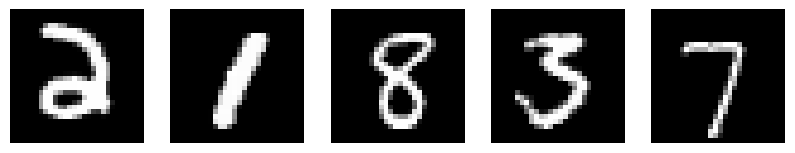

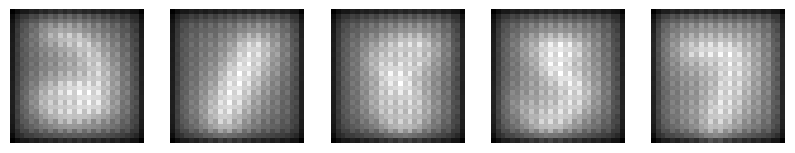

tensor([[3.5046e-07],
        [2.0727e-06],
        [7.2007e-07],
        [7.1016e-07],
        [6.3316e-06]], device='cuda:0', grad_fn=<SigmoidBackward0>)

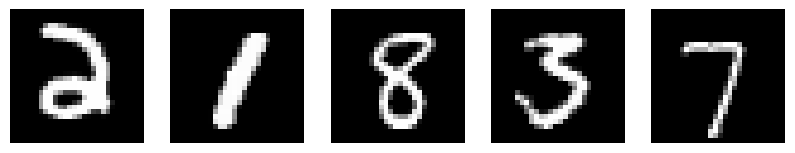

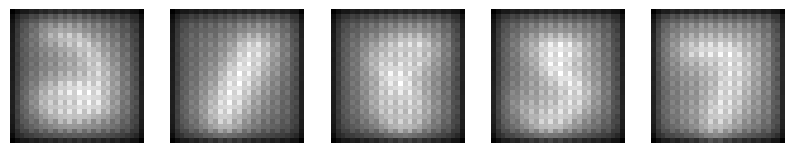

tensor([[2.8870e-07],
        [1.7514e-06],
        [5.9909e-07],
        [5.9039e-07],
        [5.4432e-06]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

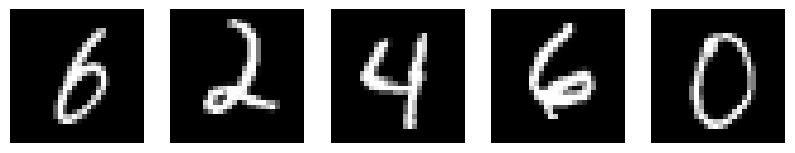

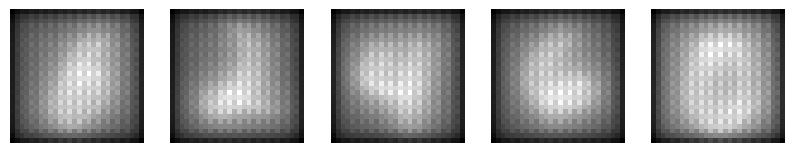

tensor([[3.1259e-05],
        [2.5536e-05],
        [1.9386e-05],
        [1.4580e-05],
        [3.9964e-05]], device='cuda:0', grad_fn=<SigmoidBackward0>)

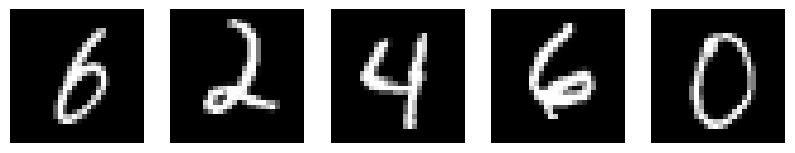

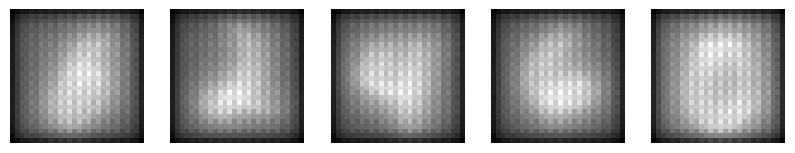

tensor([[2.7740e-05],
        [2.2610e-05],
        [1.7092e-05],
        [1.2806e-05],
        [3.5573e-05]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

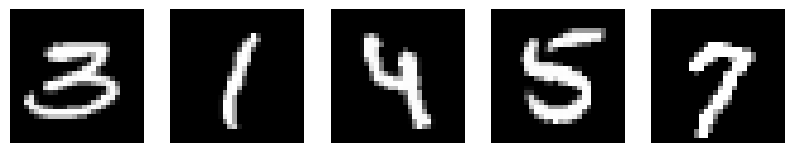

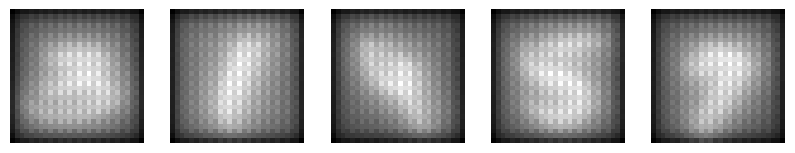

tensor([[0.0001],
        [0.0008],
        [0.0003],
        [0.0001],
        [0.0002]], device='cuda:0', grad_fn=<SigmoidBackward0>)

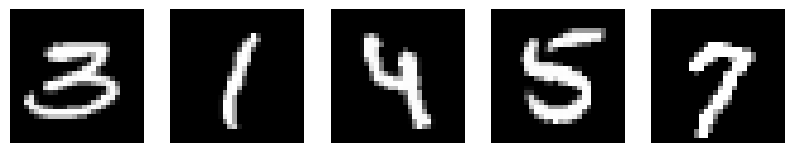

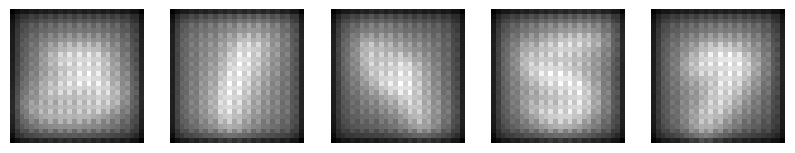

tensor([[0.0001],
        [0.0007],
        [0.0003],
        [0.0001],
        [0.0002]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

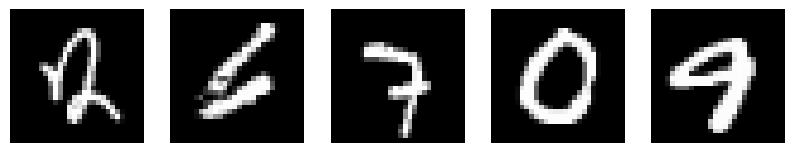

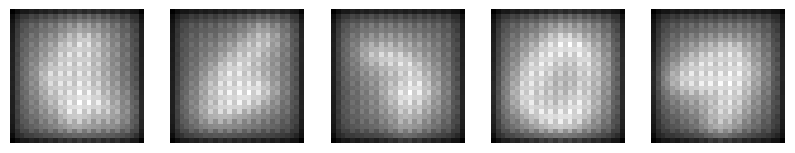

tensor([[0.0031],
        [0.0029],
        [0.0050],
        [0.0018],
        [0.0016]], device='cuda:0', grad_fn=<SigmoidBackward0>)

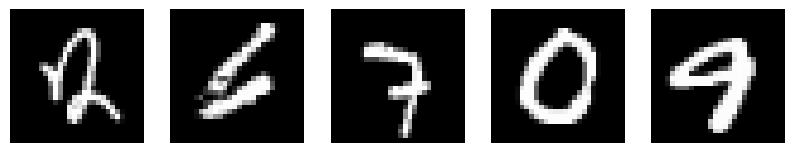

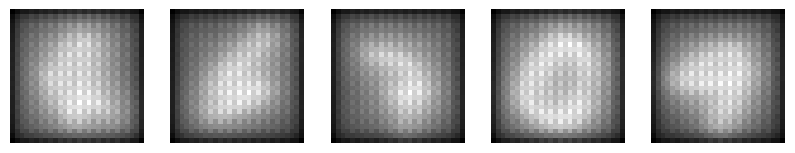

tensor([[0.0031],
        [0.0029],
        [0.0049],
        [0.0017],
        [0.0016]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

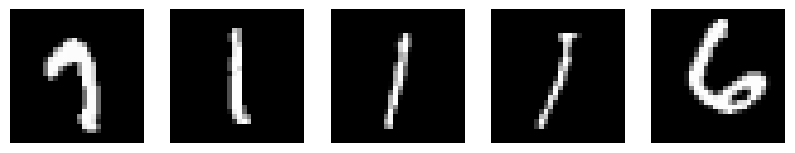

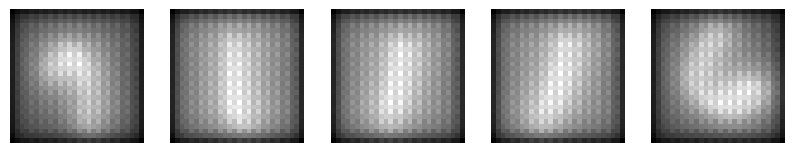

tensor([[0.0321],
        [0.0505],
        [0.0504],
        [0.0486],
        [0.0267]], device='cuda:0', grad_fn=<SigmoidBackward0>)

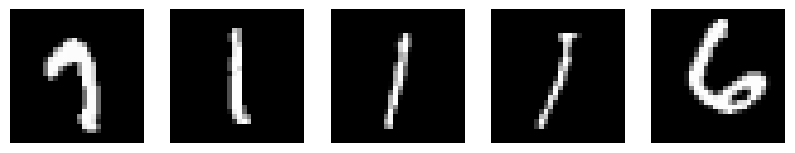

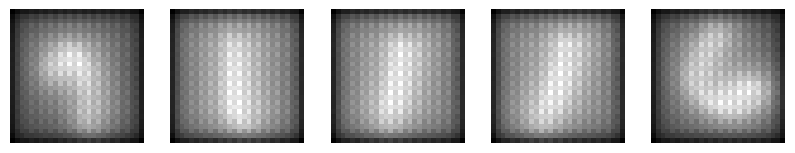

tensor([[0.0356],
        [0.0550],
        [0.0549],
        [0.0531],
        [0.0299]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

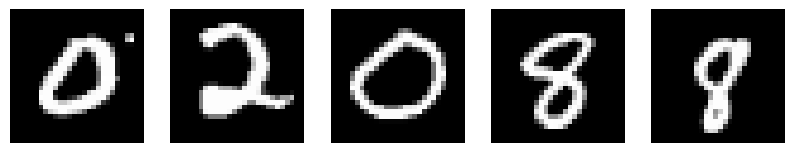

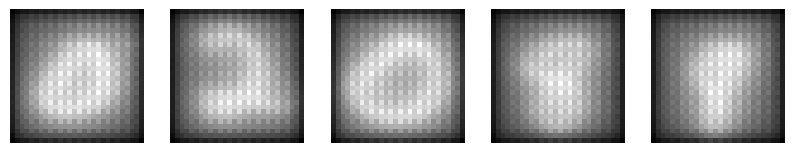

tensor([[0.0682],
        [0.0653],
        [0.0633],
        [0.0673],
        [0.0856]], device='cuda:0', grad_fn=<SigmoidBackward0>)

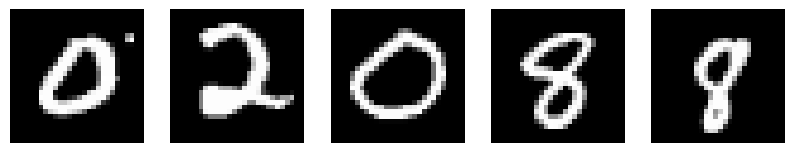

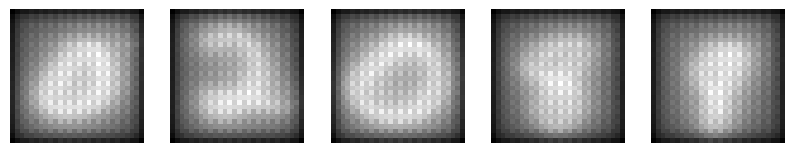

tensor([[0.0806],
        [0.0772],
        [0.0754],
        [0.0797],
        [0.0989]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

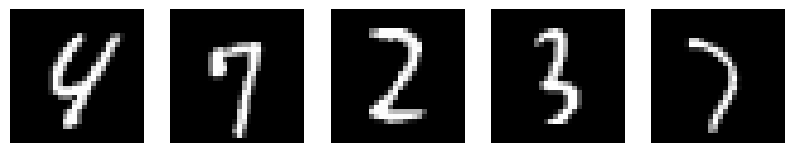

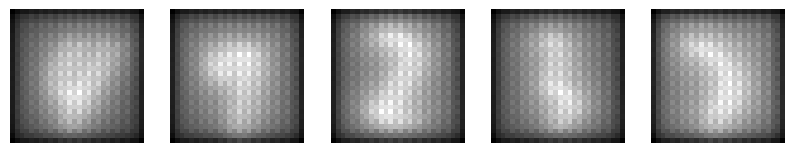

tensor([[0.0953],
        [0.1049],
        [0.0930],
        [0.1079],
        [0.1200]], device='cuda:0', grad_fn=<SigmoidBackward0>)

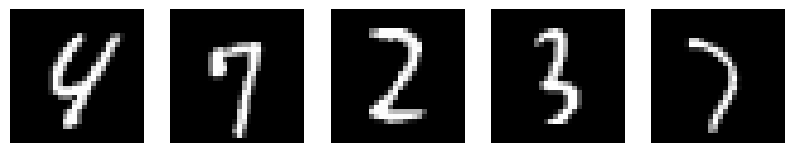

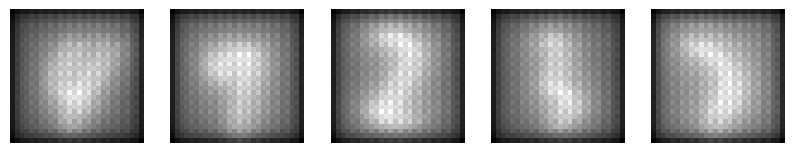

tensor([[0.1175],
        [0.1274],
        [0.1146],
        [0.1303],
        [0.1429]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

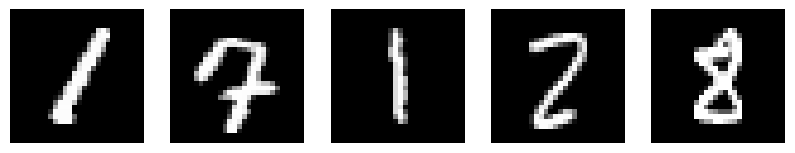

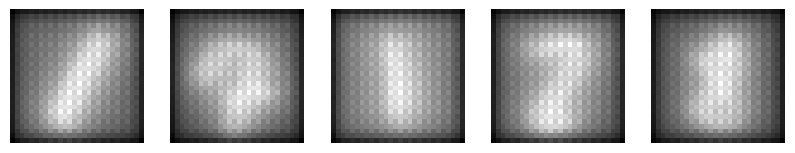

tensor([[0.0777],
        [0.0551],
        [0.0999],
        [0.0685],
        [0.0567]], device='cuda:0', grad_fn=<SigmoidBackward0>)

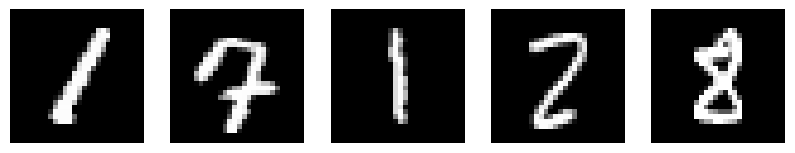

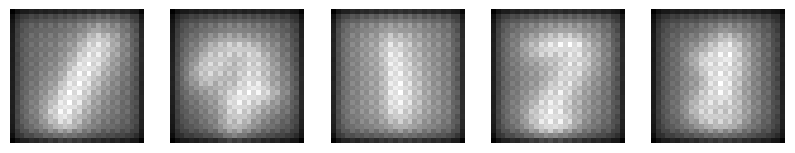

tensor([[0.1040],
        [0.0781],
        [0.1279],
        [0.0936],
        [0.0798]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

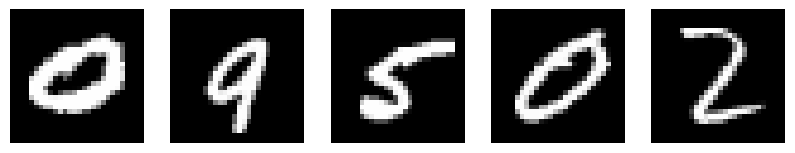

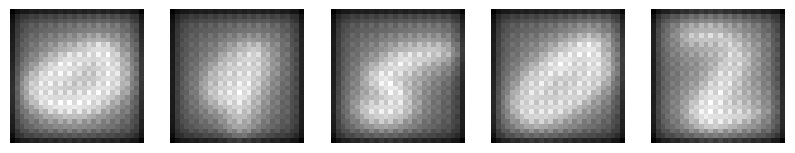

tensor([[0.0246],
        [0.0390],
        [0.0368],
        [0.0326],
        [0.0457]], device='cuda:0', grad_fn=<SigmoidBackward0>)

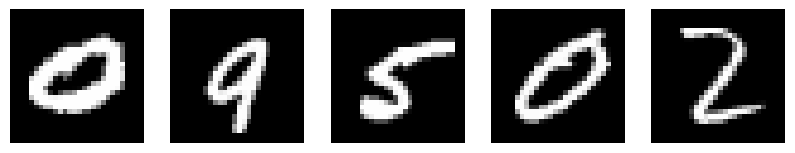

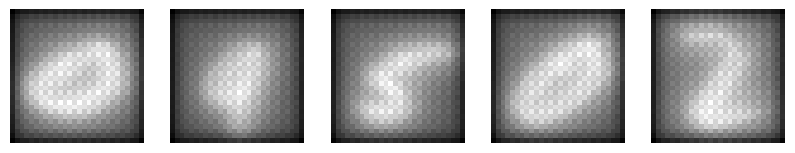

tensor([[0.0414],
        [0.0608],
        [0.0578],
        [0.0527],
        [0.0695]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

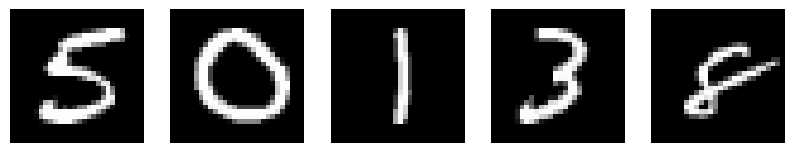

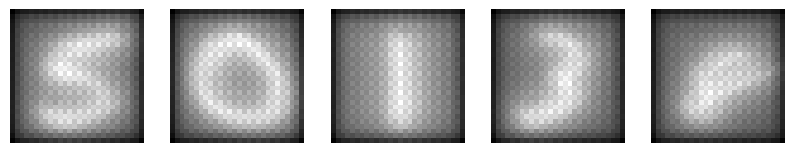

tensor([[0.0211],
        [0.0184],
        [0.0521],
        [0.0287],
        [0.0317]], device='cuda:0', grad_fn=<SigmoidBackward0>)

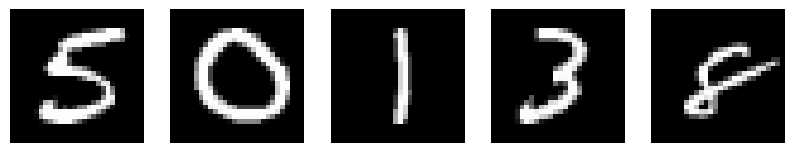

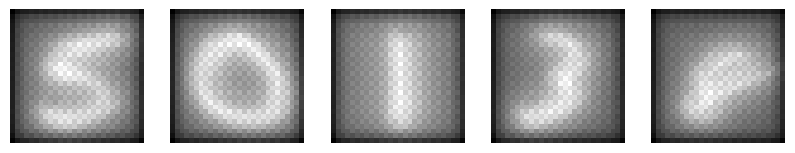

tensor([[0.0380],
        [0.0337],
        [0.0802],
        [0.0491],
        [0.0538]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

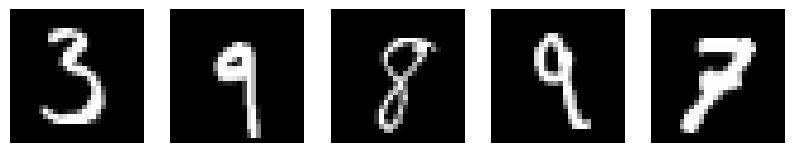

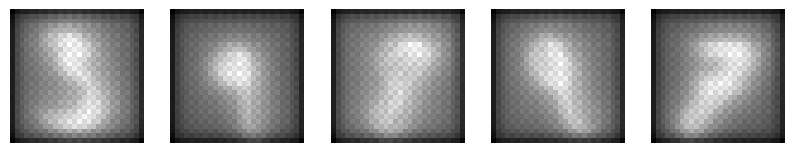

tensor([[0.0195],
        [0.0252],
        [0.0293],
        [0.0244],
        [0.0157]], device='cuda:0', grad_fn=<SigmoidBackward0>)

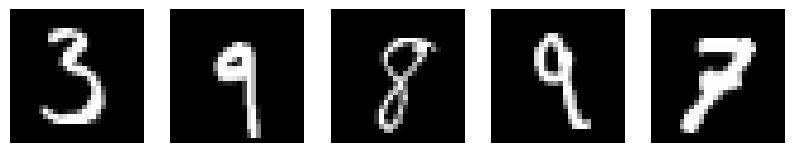

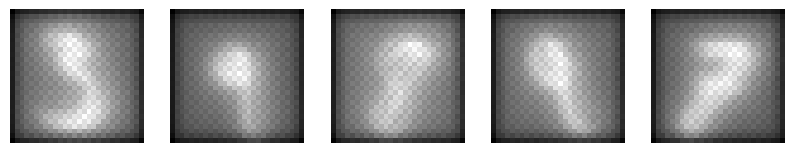

tensor([[0.0361],
        [0.0448],
        [0.0513],
        [0.0438],
        [0.0300]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

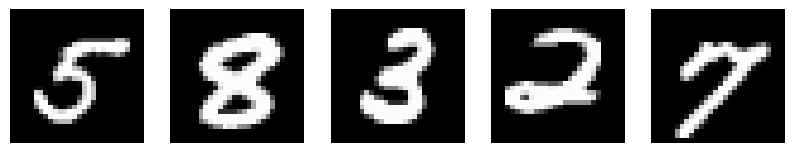

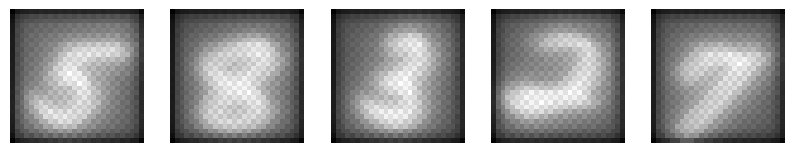

tensor([[0.0131],
        [0.0056],
        [0.0083],
        [0.0080],
        [0.0109]], device='cuda:0', grad_fn=<SigmoidBackward0>)

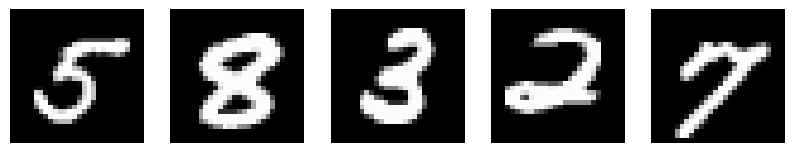

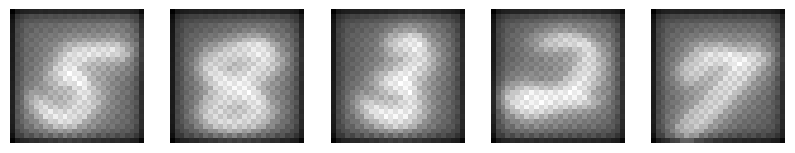

tensor([[0.0251],
        [0.0121],
        [0.0171],
        [0.0162],
        [0.0217]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

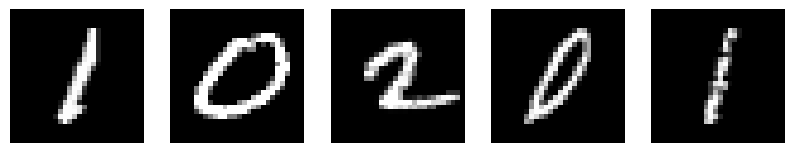

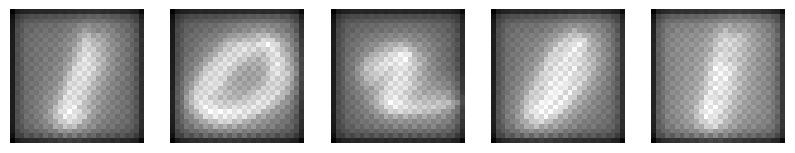

tensor([[0.0219],
        [0.0081],
        [0.0128],
        [0.0147],
        [0.0298]], device='cuda:0', grad_fn=<SigmoidBackward0>)

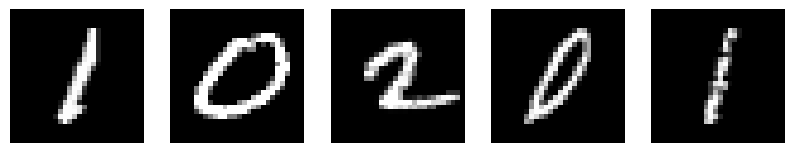

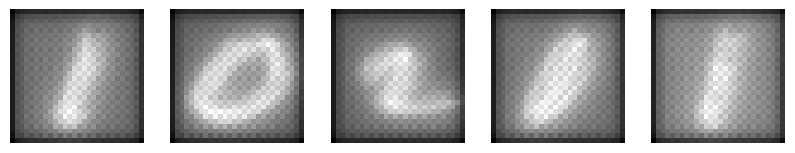

tensor([[0.0388],
        [0.0166],
        [0.0246],
        [0.0280],
        [0.0505]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

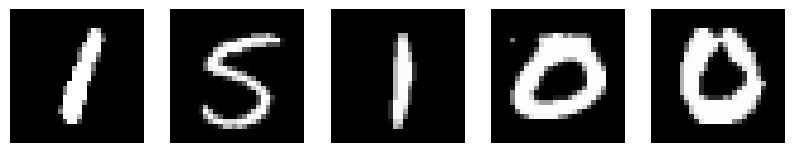

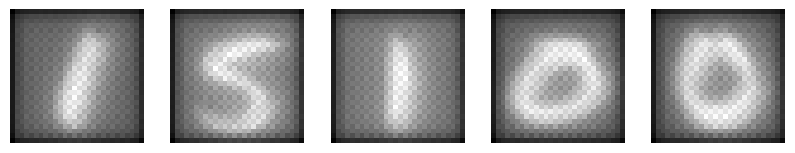

tensor([[0.0156],
        [0.0123],
        [0.0247],
        [0.0045],
        [0.0043]], device='cuda:0', grad_fn=<SigmoidBackward0>)

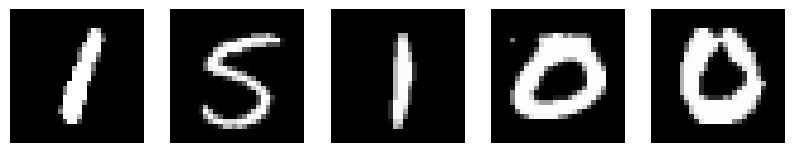

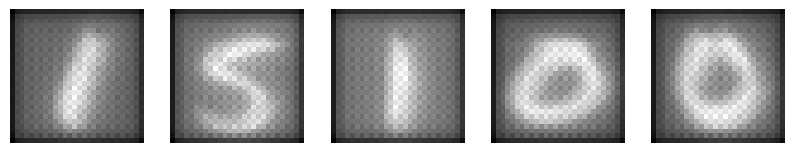

tensor([[0.0287],
        [0.0238],
        [0.0425],
        [0.0097],
        [0.0092]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

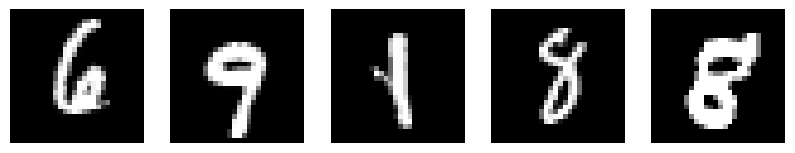

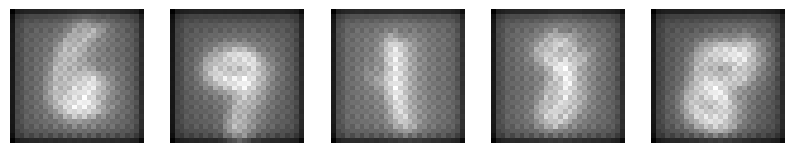

tensor([[0.0120],
        [0.0101],
        [0.0228],
        [0.0144],
        [0.0060]], device='cuda:0', grad_fn=<SigmoidBackward0>)

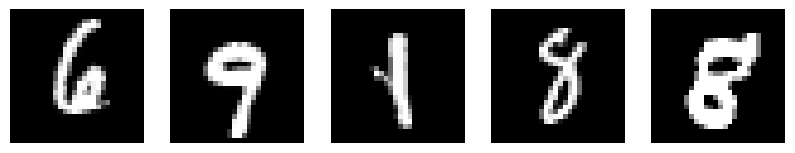

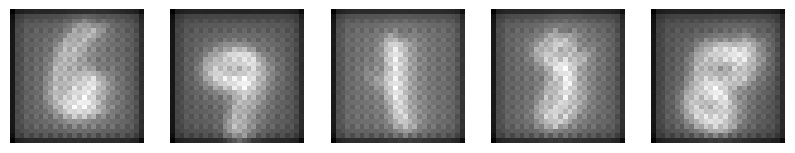

tensor([[0.0234],
        [0.0200],
        [0.0405],
        [0.0277],
        [0.0128]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

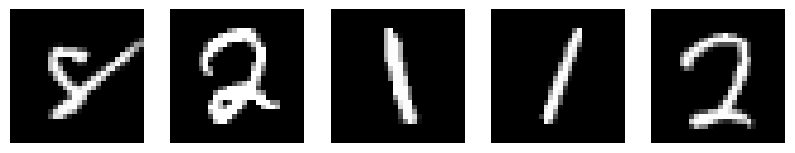

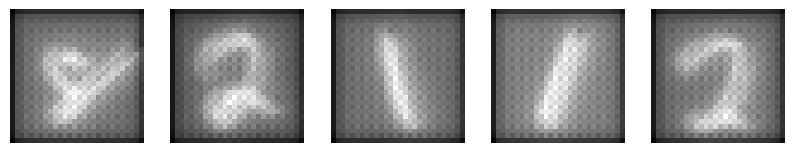

tensor([[0.0207],
        [0.0104],
        [0.0300],
        [0.0351],
        [0.0209]], device='cuda:0', grad_fn=<SigmoidBackward0>)

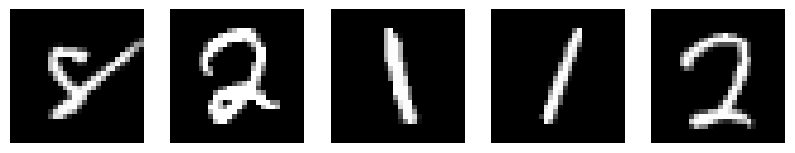

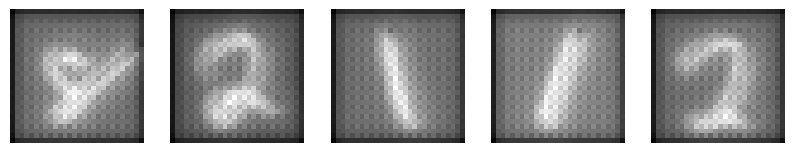

tensor([[0.0396],
        [0.0218],
        [0.0530],
        [0.0614],
        [0.0399]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

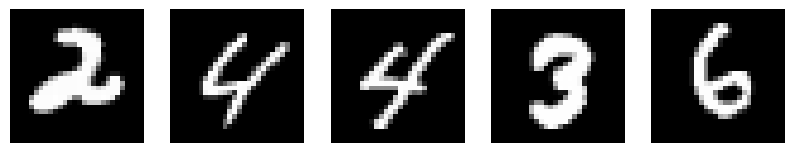

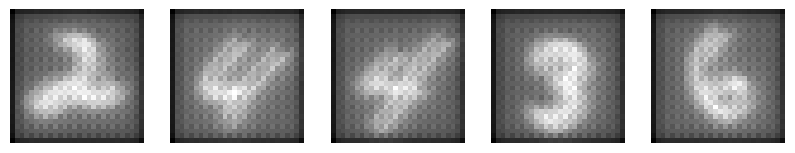

tensor([[0.0117],
        [0.0241],
        [0.0222],
        [0.0144],
        [0.0207]], device='cuda:0', grad_fn=<SigmoidBackward0>)

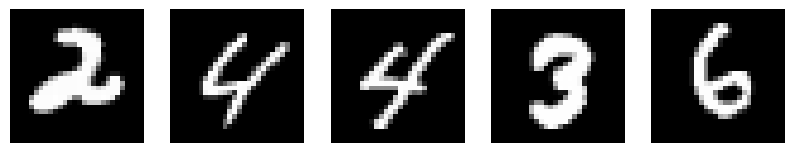

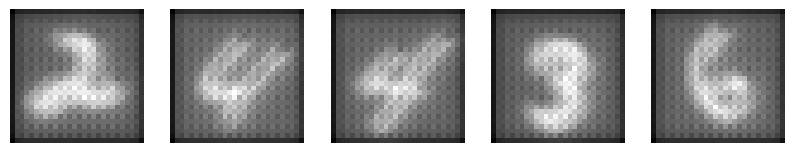

tensor([[0.0239],
        [0.0469],
        [0.0433],
        [0.0287],
        [0.0400]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

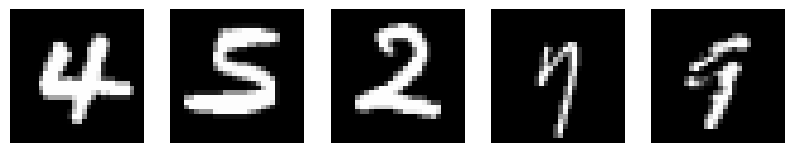

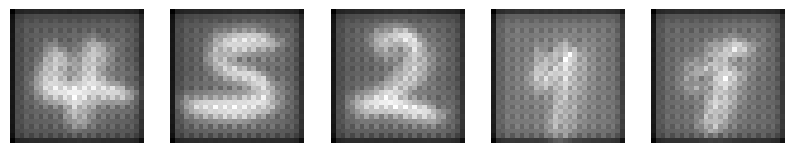

tensor([[0.0201],
        [0.0154],
        [0.0212],
        [0.0671],
        [0.0478]], device='cuda:0', grad_fn=<SigmoidBackward0>)

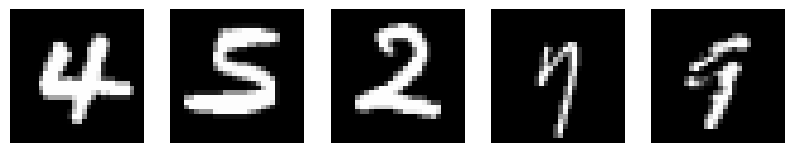

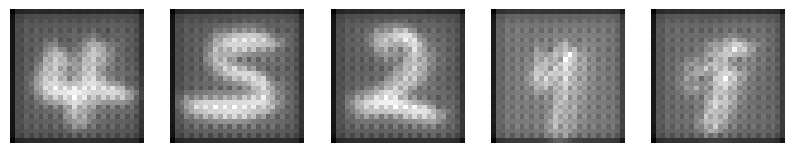

tensor([[0.0406],
        [0.0321],
        [0.0428],
        [0.1152],
        [0.0879]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

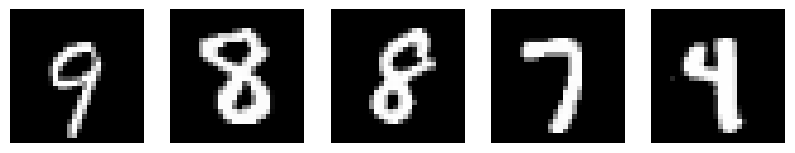

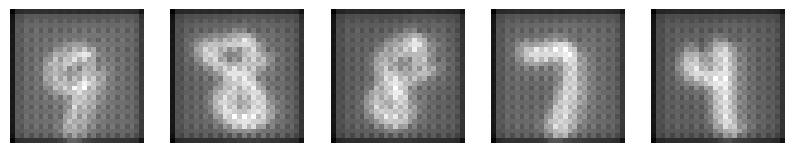

tensor([[0.0754],
        [0.0318],
        [0.0414],
        [0.0591],
        [0.0414]], device='cuda:0', grad_fn=<SigmoidBackward0>)

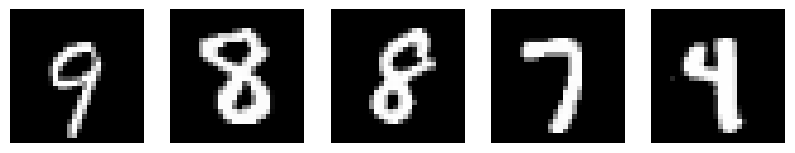

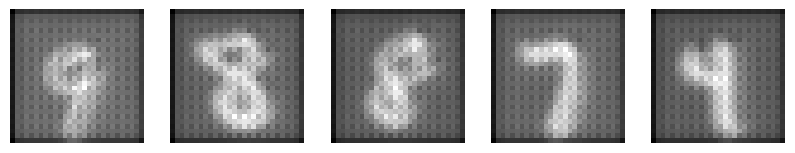

tensor([[0.1355],
        [0.0656],
        [0.0818],
        [0.1081],
        [0.0804]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

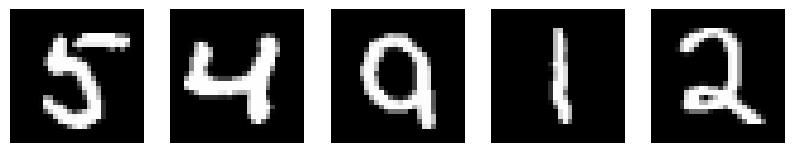

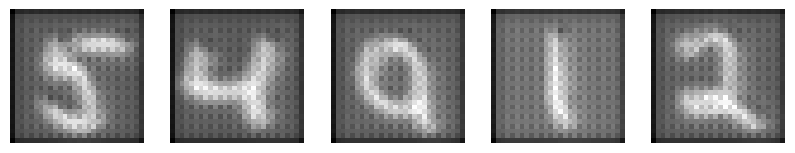

tensor([[0.0563],
        [0.0473],
        [0.0624],
        [0.1480],
        [0.0632]], device='cuda:0', grad_fn=<SigmoidBackward0>)

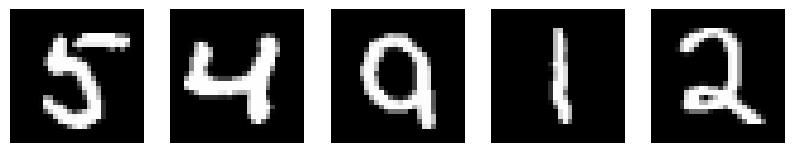

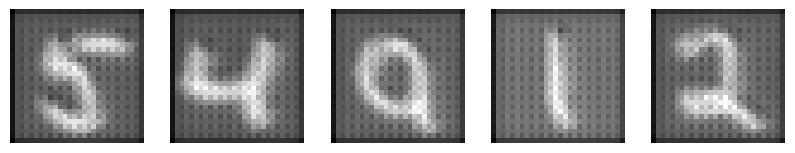

tensor([[0.1141],
        [0.0979],
        [0.1239],
        [0.2446],
        [0.1260]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

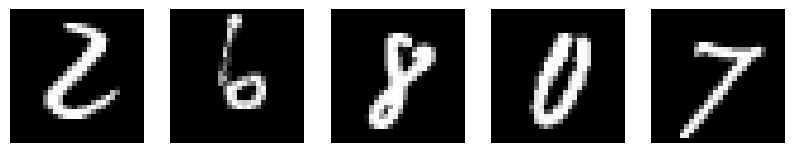

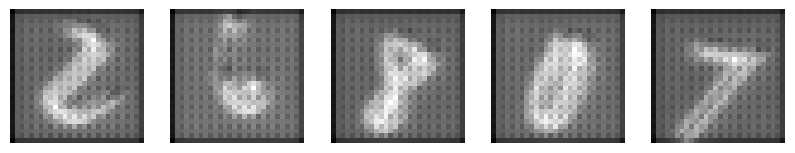

tensor([[0.1310],
        [0.2144],
        [0.1154],
        [0.1151],
        [0.1748]], device='cuda:0', grad_fn=<SigmoidBackward0>)

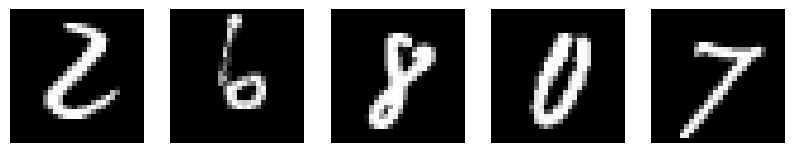

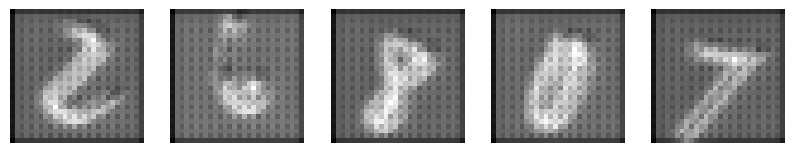

tensor([[0.2489],
        [0.3376],
        [0.2207],
        [0.2228],
        [0.3002]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

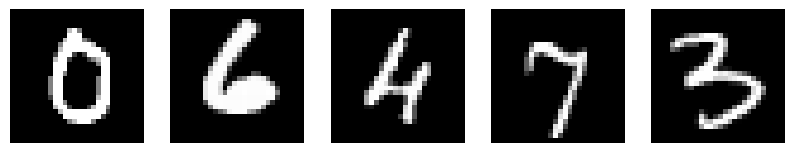

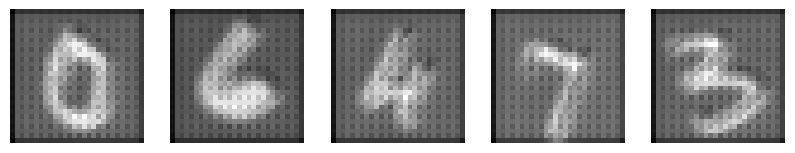

tensor([[0.1472],
        [0.0979],
        [0.1968],
        [0.2633],
        [0.1771]], device='cuda:0', grad_fn=<SigmoidBackward0>)

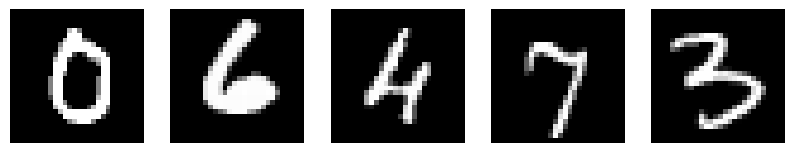

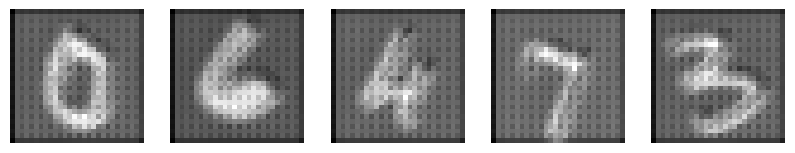

tensor([[0.2921],
        [0.2111],
        [0.3467],
        [0.4048],
        [0.3319]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

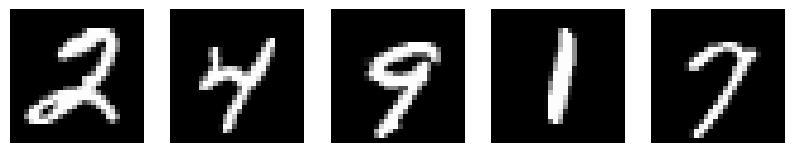

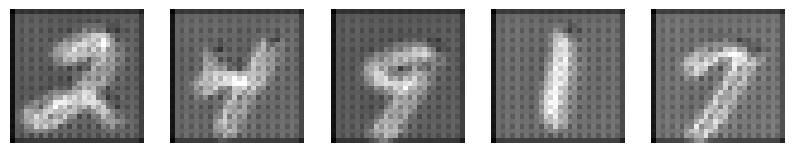

tensor([[0.1886],
        [0.2730],
        [0.2209],
        [0.2772],
        [0.3243]], device='cuda:0', grad_fn=<SigmoidBackward0>)

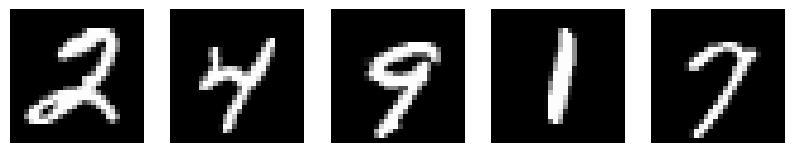

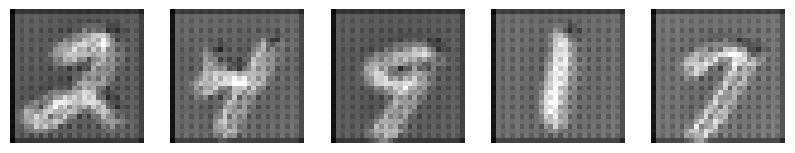

tensor([[0.3639],
        [0.4309],
        [0.3893],
        [0.4171],
        [0.4580]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

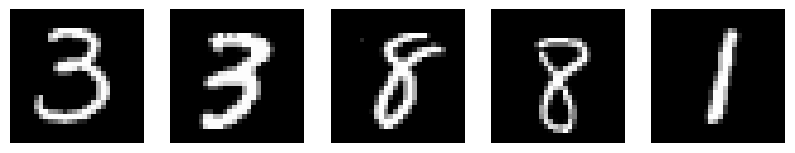

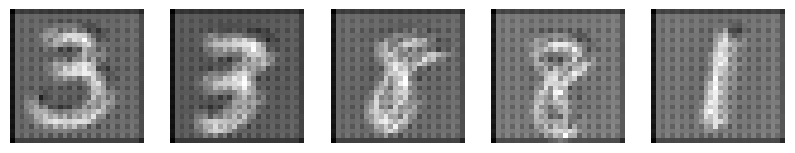

tensor([[0.3690],
        [0.2867],
        [0.3483],
        [0.4179],
        [0.4003]], device='cuda:0', grad_fn=<SigmoidBackward0>)

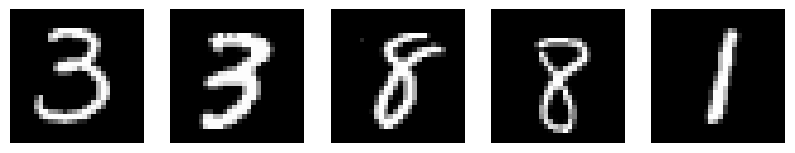

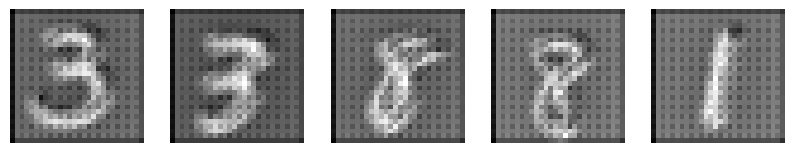

tensor([[0.4734],
        [0.4465],
        [0.4694],
        [0.4751],
        [0.4735]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

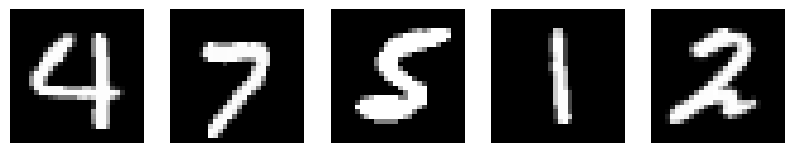

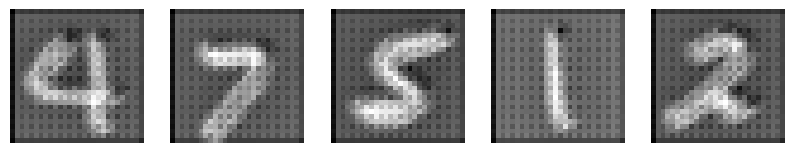

tensor([[0.4108],
        [0.4300],
        [0.3165],
        [0.4627],
        [0.3854]], device='cuda:0', grad_fn=<SigmoidBackward0>)

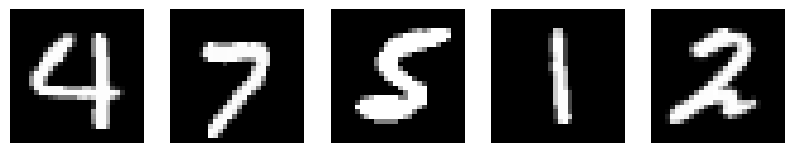

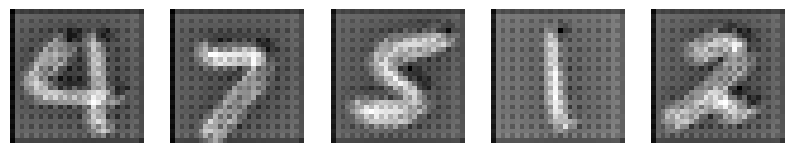

tensor([[0.4793],
        [0.4797],
        [0.4722],
        [0.4793],
        [0.4773]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

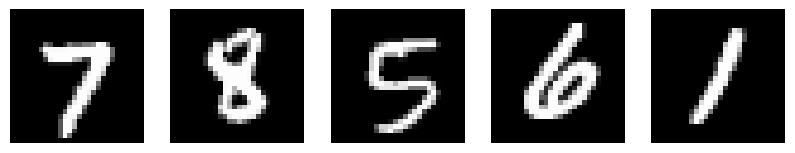

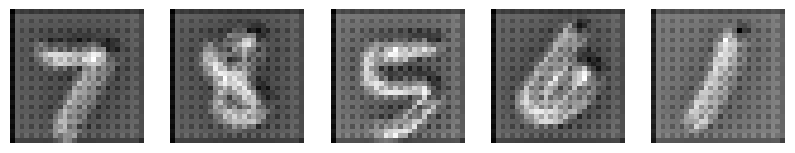

tensor([[0.4827],
        [0.4776],
        [0.4850],
        [0.4789],
        [0.4820]], device='cuda:0', grad_fn=<SigmoidBackward0>)

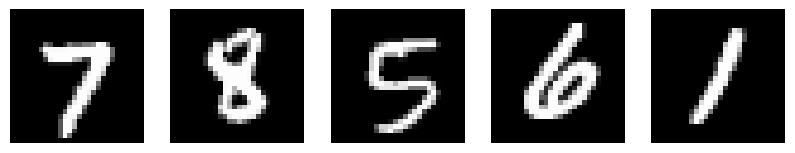

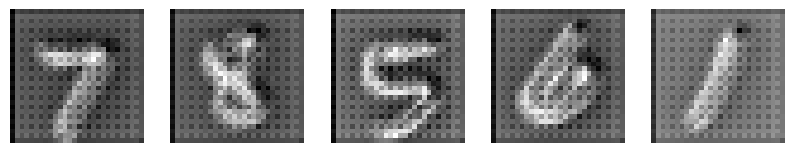

tensor([[0.4959],
        [0.4917],
        [0.5017],
        [0.4940],
        [0.4956]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

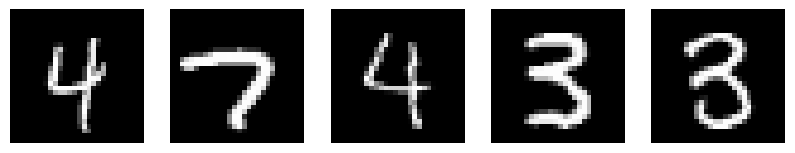

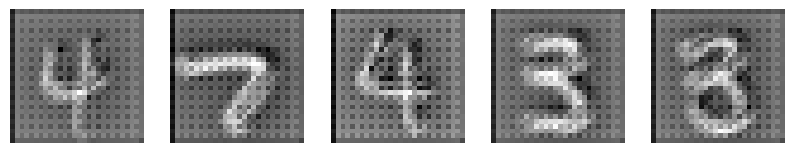

tensor([[0.5219],
        [0.5169],
        [0.5239],
        [0.5196],
        [0.5243]], device='cuda:0', grad_fn=<SigmoidBackward0>)

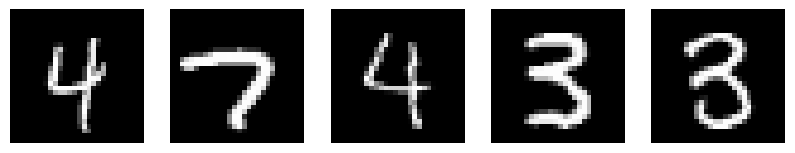

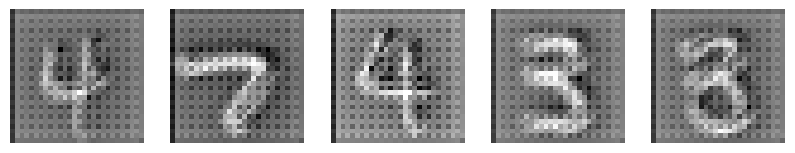

tensor([[0.5388],
        [0.5364],
        [0.5398],
        [0.5392],
        [0.5410]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

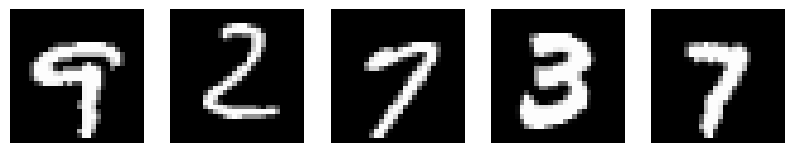

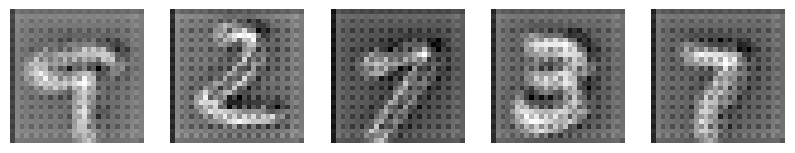

tensor([[0.5489],
        [0.5526],
        [0.5518],
        [0.5473],
        [0.5480]], device='cuda:0', grad_fn=<SigmoidBackward0>)

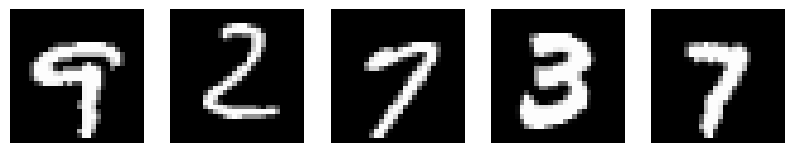

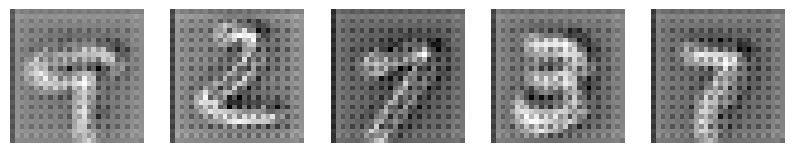

tensor([[0.5653],
        [0.5663],
        [0.5645],
        [0.5643],
        [0.5621]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

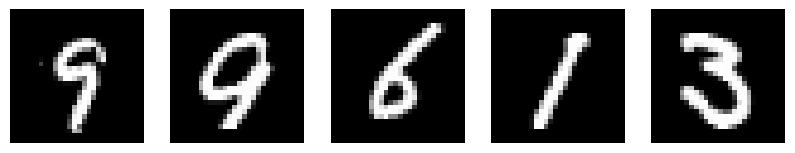

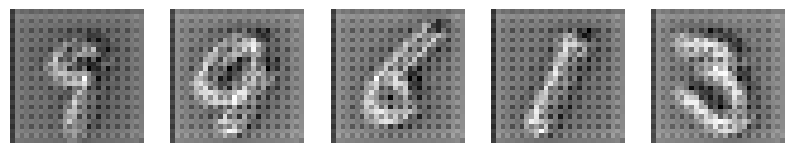

tensor([[0.5781],
        [0.5776],
        [0.5750],
        [0.5715],
        [0.5784]], device='cuda:0', grad_fn=<SigmoidBackward0>)

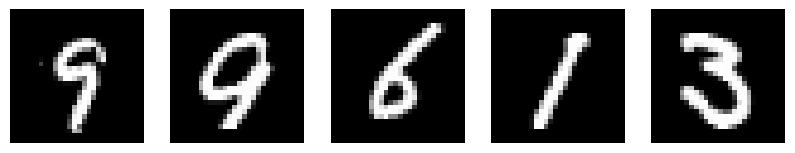

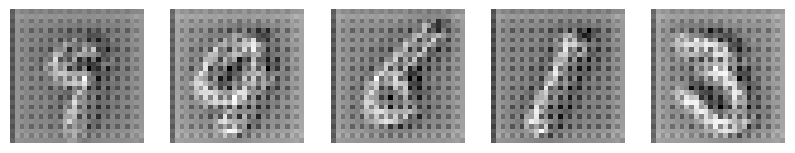

tensor([[0.5988],
        [0.6007],
        [0.5959],
        [0.5907],
        [0.5985]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

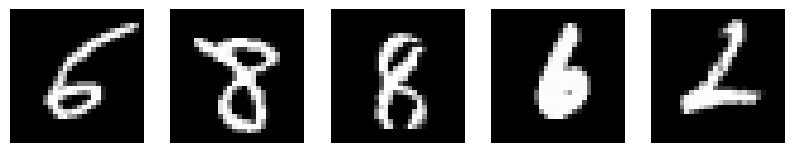

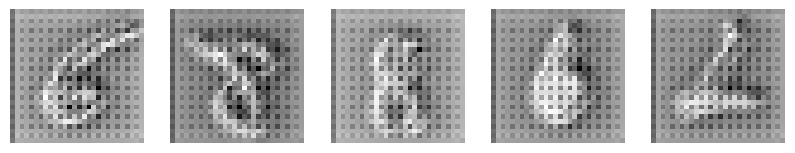

tensor([[0.6089],
        [0.6127],
        [0.6072],
        [0.5976],
        [0.6000]], device='cuda:0', grad_fn=<SigmoidBackward0>)

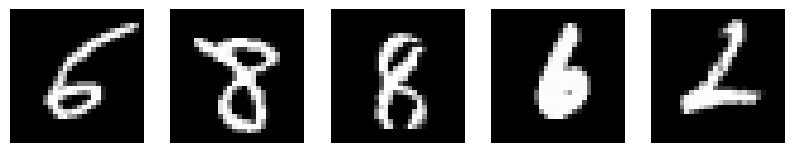

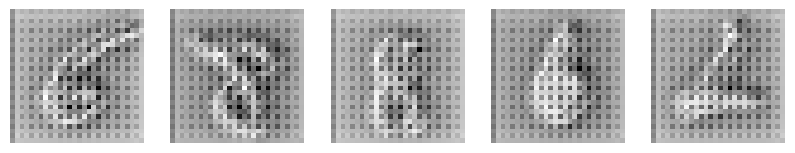

tensor([[0.6432],
        [0.6491],
        [0.6426],
        [0.6290],
        [0.6321]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

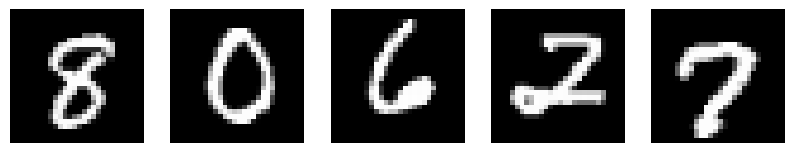

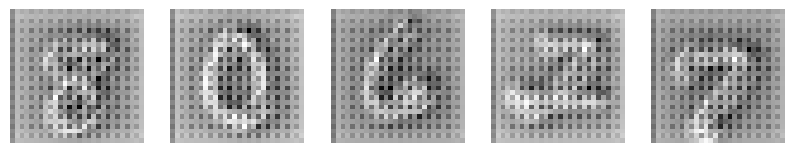

tensor([[0.6489],
        [0.6349],
        [0.6361],
        [0.6378],
        [0.6397]], device='cuda:0', grad_fn=<SigmoidBackward0>)

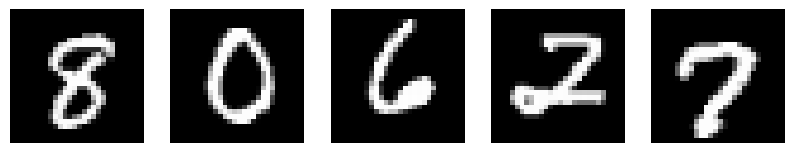

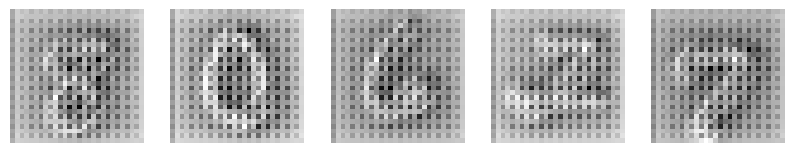

tensor([[0.7017],
        [0.6835],
        [0.6851],
        [0.6895],
        [0.6908]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

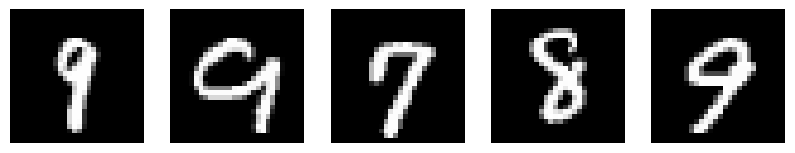

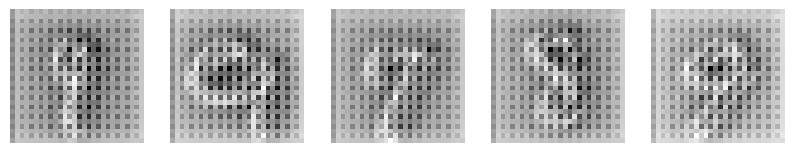

tensor([[0.6658],
        [0.6864],
        [0.6759],
        [0.6836],
        [0.6926]], device='cuda:0', grad_fn=<SigmoidBackward0>)

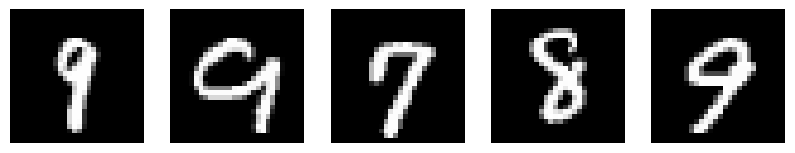

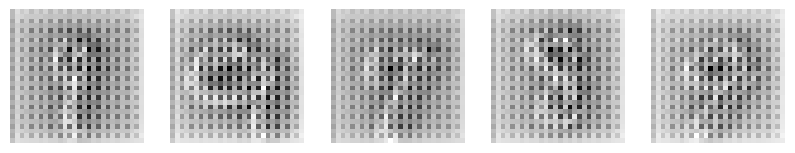

tensor([[0.7304],
        [0.7571],
        [0.7452],
        [0.7524],
        [0.7677]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

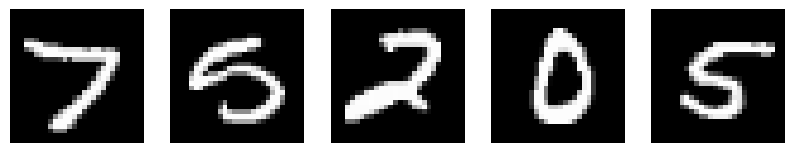

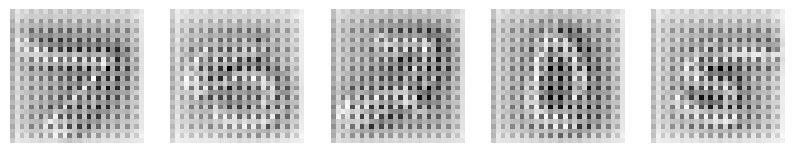

tensor([[0.7175],
        [0.7382],
        [0.7224],
        [0.7206],
        [0.7282]], device='cuda:0', grad_fn=<SigmoidBackward0>)

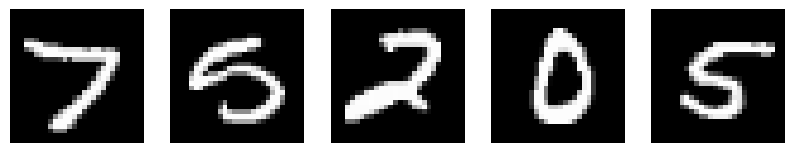

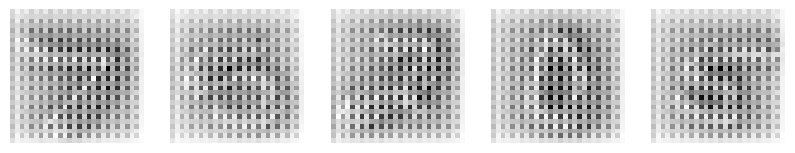

tensor([[0.7982],
        [0.8203],
        [0.8071],
        [0.8040],
        [0.8098]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

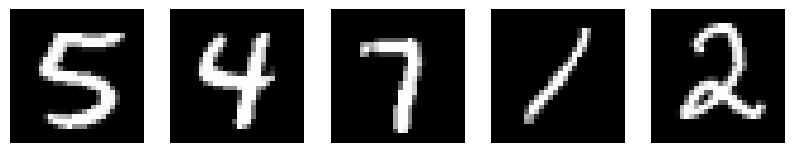

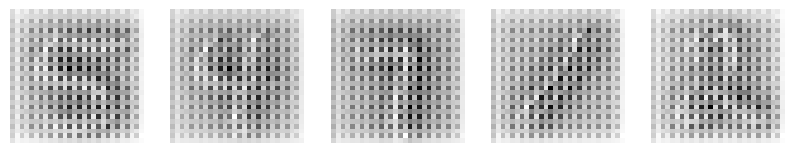

tensor([[0.7694],
        [0.7643],
        [0.7311],
        [0.7297],
        [0.7641]], device='cuda:0', grad_fn=<SigmoidBackward0>)

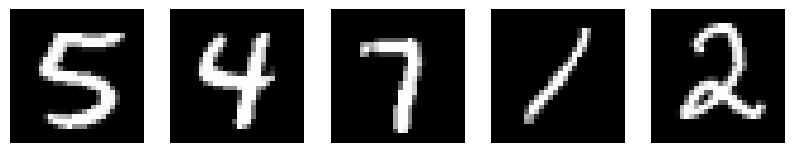

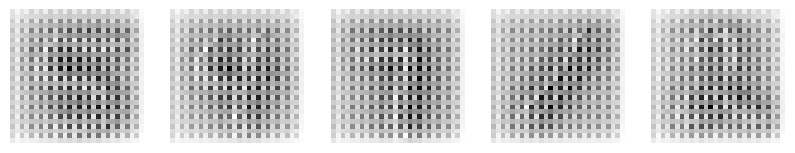

tensor([[0.8589],
        [0.8548],
        [0.8177],
        [0.8123],
        [0.8526]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

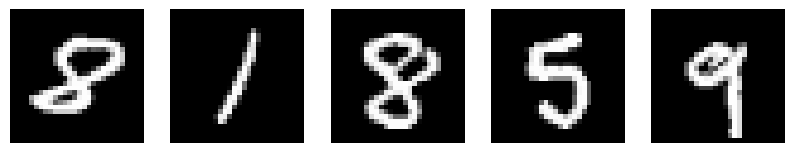

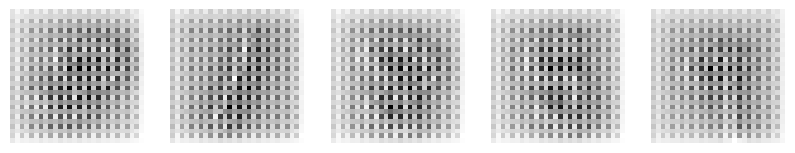

tensor([[0.8206],
        [0.7465],
        [0.8317],
        [0.8045],
        [0.7995]], device='cuda:0', grad_fn=<SigmoidBackward0>)

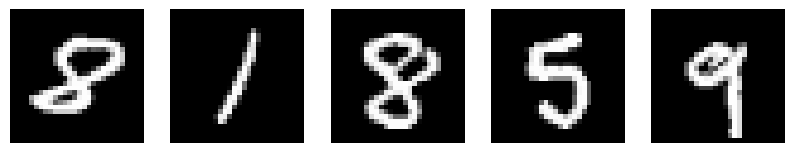

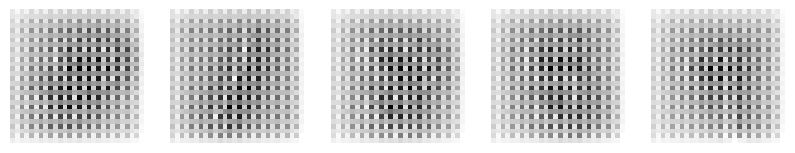

tensor([[0.9125],
        [0.8365],
        [0.9203],
        [0.8972],
        [0.8944]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

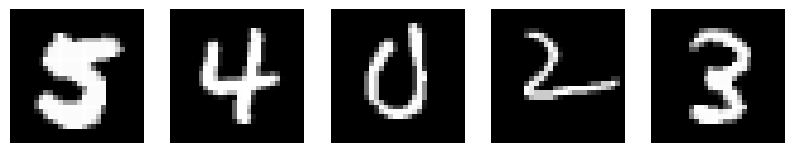

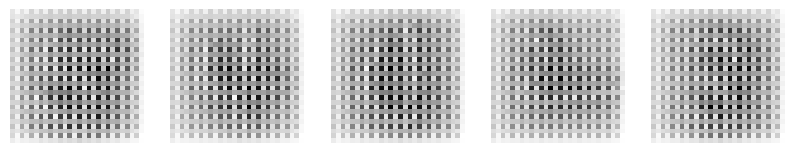

tensor([[0.8501],
        [0.8355],
        [0.8095],
        [0.8012],
        [0.8318]], device='cuda:0', grad_fn=<SigmoidBackward0>)

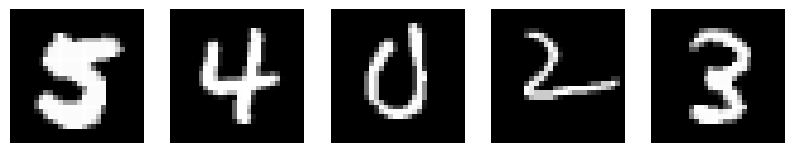

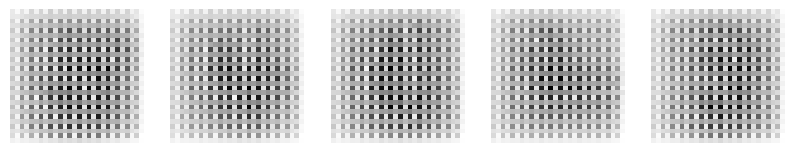

tensor([[0.9374],
        [0.9268],
        [0.9059],
        [0.8987],
        [0.9242]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

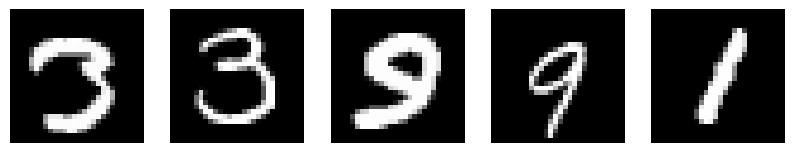

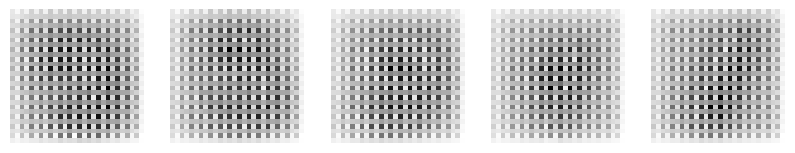

tensor([[0.8523],
        [0.8569],
        [0.8864],
        [0.8604],
        [0.8284]], device='cuda:0', grad_fn=<SigmoidBackward0>)

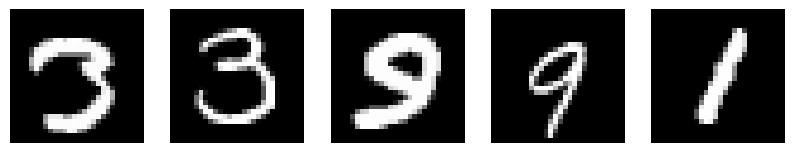

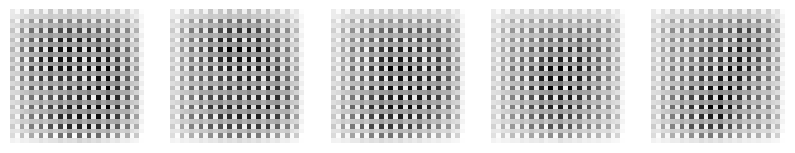

tensor([[0.9390],
        [0.9422],
        [0.9592],
        [0.9440],
        [0.9228]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

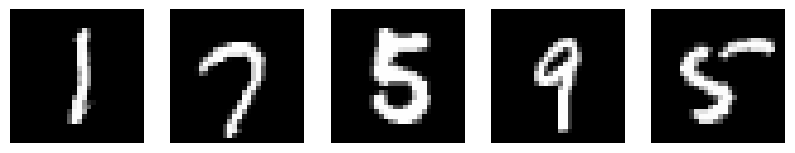

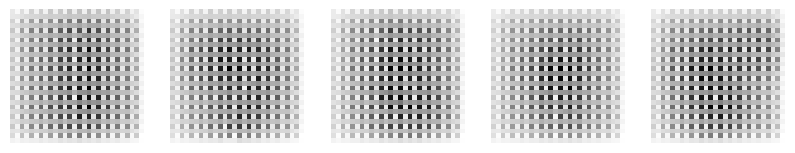

tensor([[0.8128],
        [0.8471],
        [0.8870],
        [0.8681],
        [0.8650]], device='cuda:0', grad_fn=<SigmoidBackward0>)

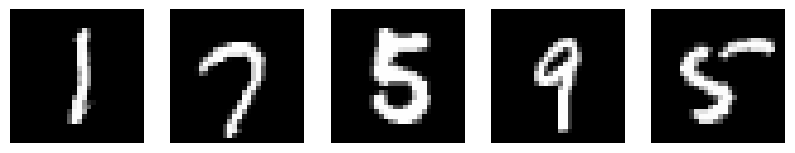

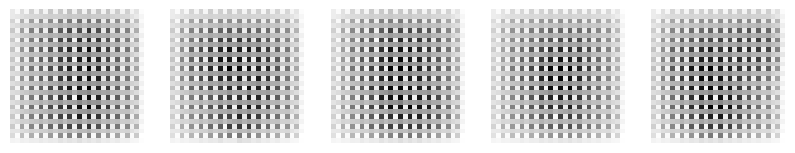

tensor([[0.9098],
        [0.9341],
        [0.9586],
        [0.9477],
        [0.9456]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

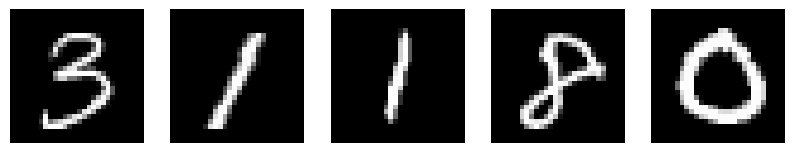

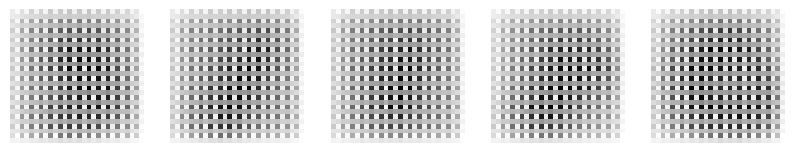

tensor([[0.8584],
        [0.8174],
        [0.8000],
        [0.8742],
        [0.8550]], device='cuda:0', grad_fn=<SigmoidBackward0>)

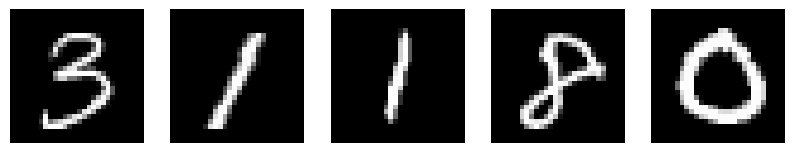

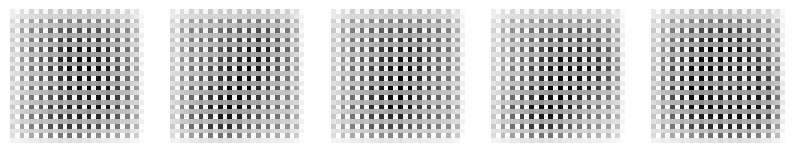

tensor([[0.9403],
        [0.9114],
        [0.8979],
        [0.9502],
        [0.9382]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

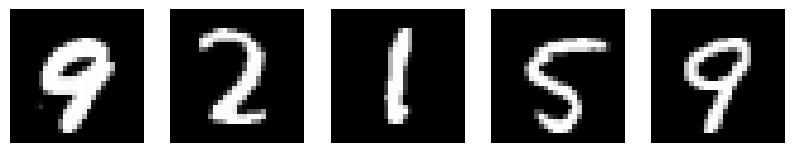

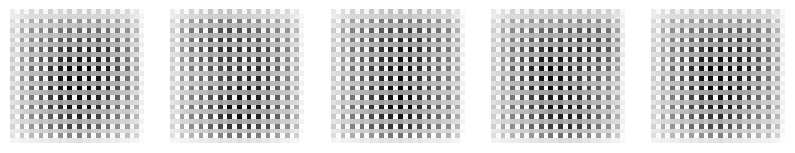

tensor([[0.8424],
        [0.7918],
        [0.7502],
        [0.7890],
        [0.8162]], device='cuda:0', grad_fn=<SigmoidBackward0>)

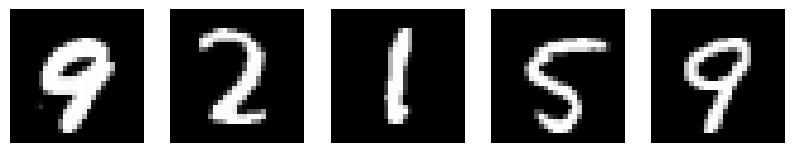

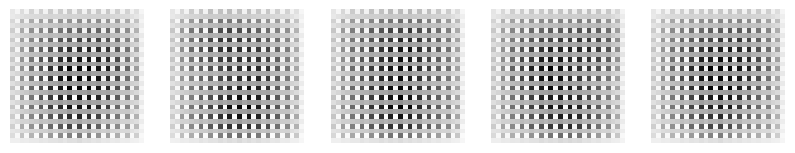

tensor([[0.9299],
        [0.8913],
        [0.8531],
        [0.8889],
        [0.9110]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

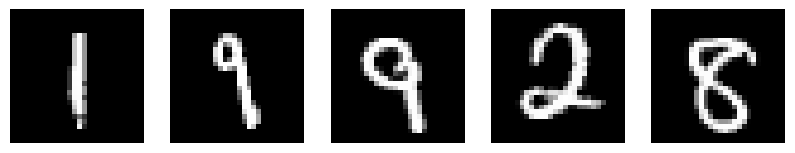

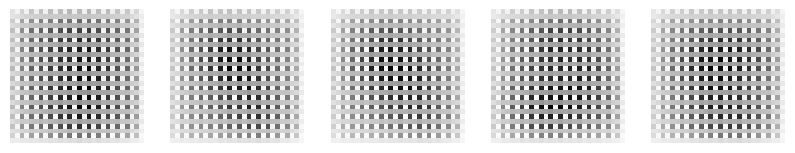

tensor([[0.6454],
        [0.6768],
        [0.7019],
        [0.7104],
        [0.7167]], device='cuda:0', grad_fn=<SigmoidBackward0>)

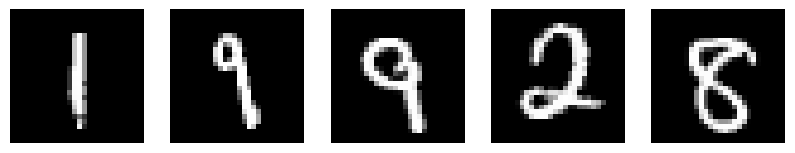

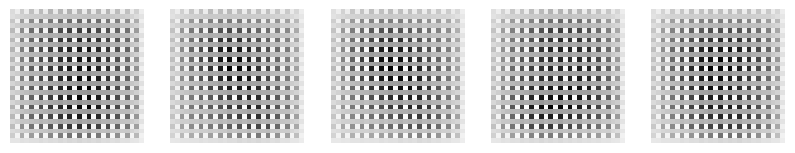

tensor([[0.7244],
        [0.7629],
        [0.7913],
        [0.8019],
        [0.8083]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

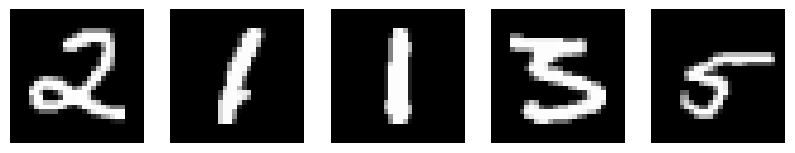

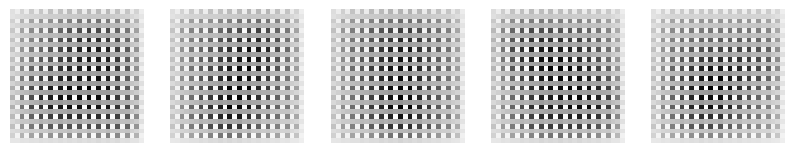

tensor([[0.6349],
        [0.6164],
        [0.6112],
        [0.6439],
        [0.6185]], device='cuda:0', grad_fn=<SigmoidBackward0>)

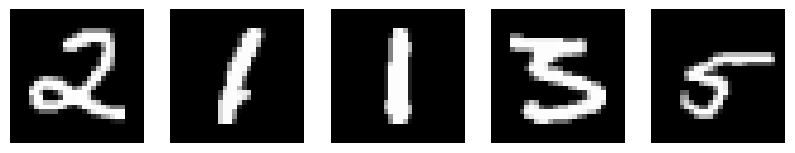

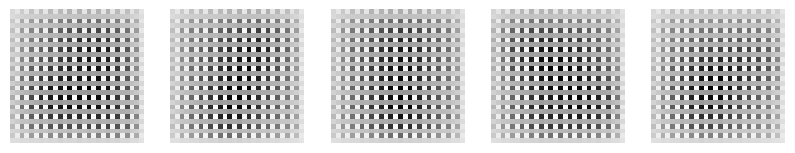

tensor([[0.6907],
        [0.6669],
        [0.6605],
        [0.7019],
        [0.6718]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

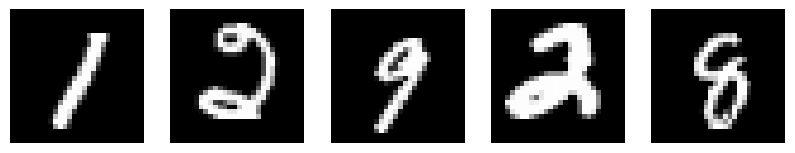

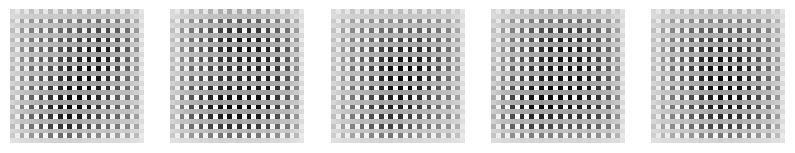

tensor([[0.5569],
        [0.5730],
        [0.5670],
        [0.5819],
        [0.5699]], device='cuda:0', grad_fn=<SigmoidBackward0>)

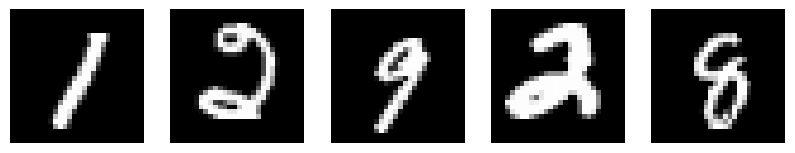

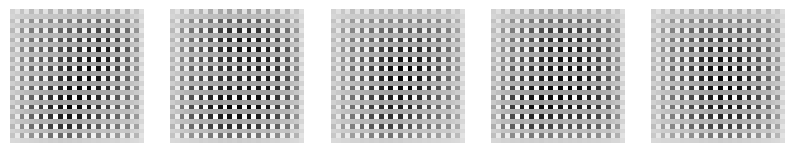

tensor([[0.5793],
        [0.5998],
        [0.5923],
        [0.6106],
        [0.5960]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

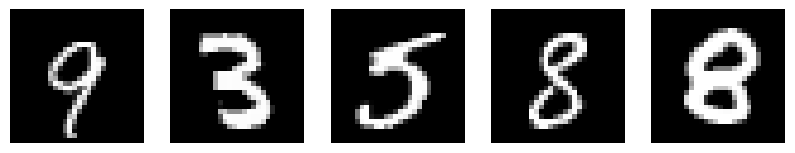

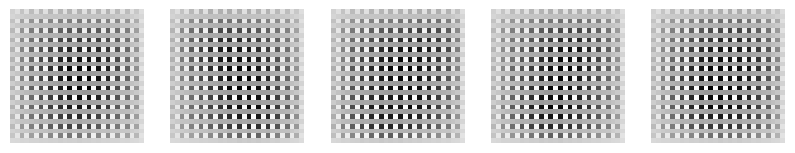

tensor([[0.4602],
        [0.4634],
        [0.4629],
        [0.4596],
        [0.4559]], device='cuda:0', grad_fn=<SigmoidBackward0>)

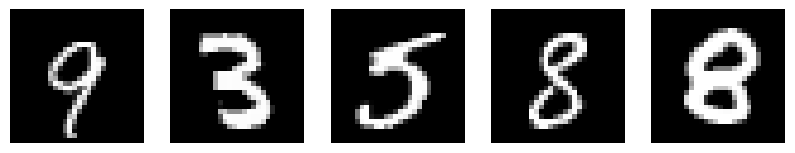

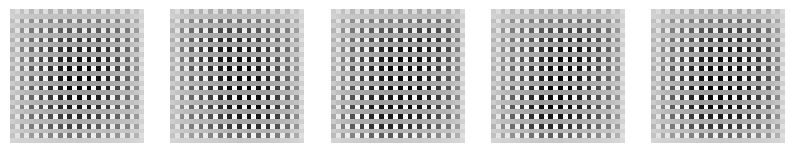

tensor([[0.4477],
        [0.4511],
        [0.4505],
        [0.4464],
        [0.4410]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

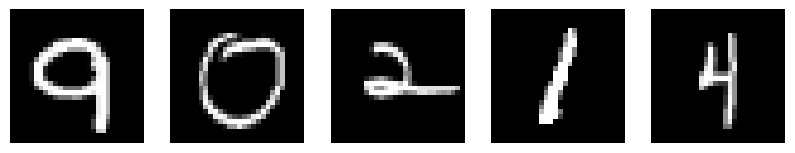

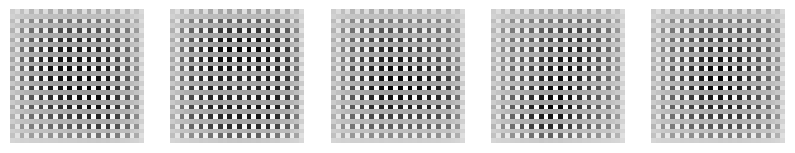

tensor([[0.2730],
        [0.3010],
        [0.2978],
        [0.2955],
        [0.3011]], device='cuda:0', grad_fn=<SigmoidBackward0>)

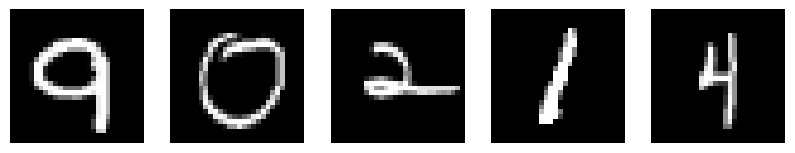

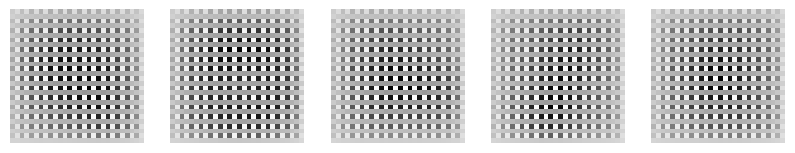

tensor([[0.2416],
        [0.2697],
        [0.2685],
        [0.2658],
        [0.2721]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

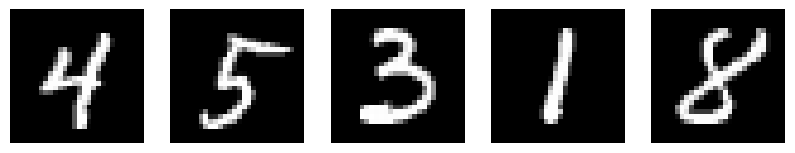

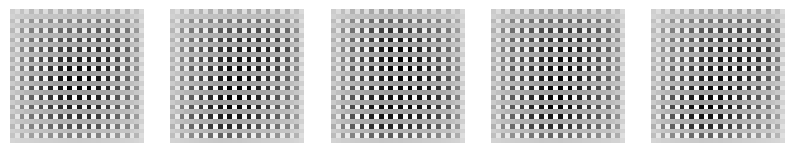

tensor([[0.1478],
        [0.1582],
        [0.1456],
        [0.1898],
        [0.1431]], device='cuda:0', grad_fn=<SigmoidBackward0>)

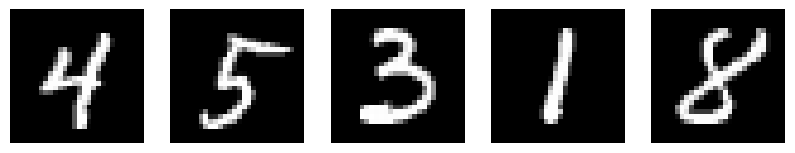

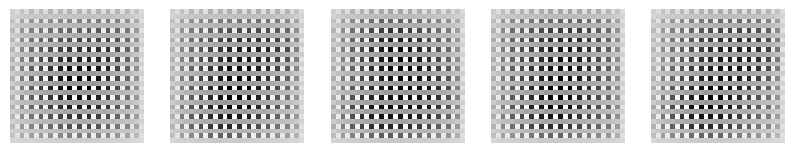

tensor([[0.1308],
        [0.1409],
        [0.1287],
        [0.1721],
        [0.1263]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

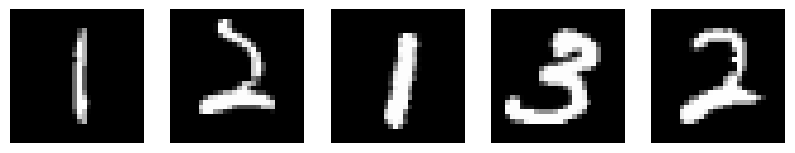

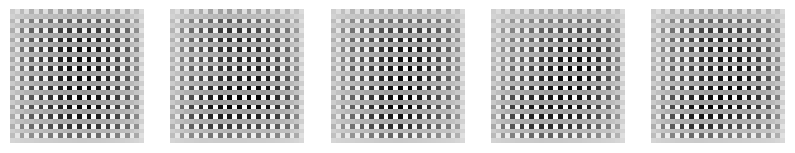

tensor([[0.1318],
        [0.0947],
        [0.1065],
        [0.0706],
        [0.0827]], device='cuda:0', grad_fn=<SigmoidBackward0>)

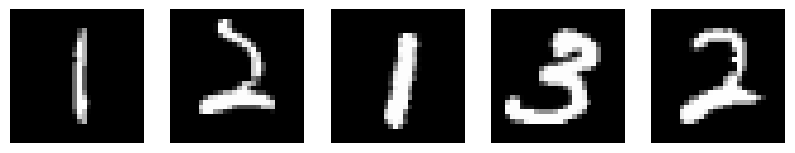

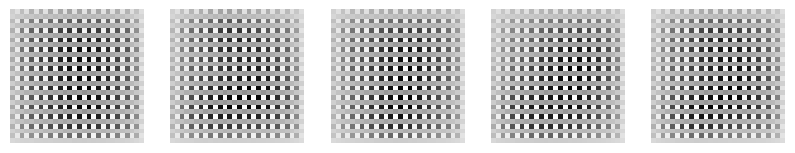

tensor([[0.1260],
        [0.0896],
        [0.1012],
        [0.0663],
        [0.0780]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

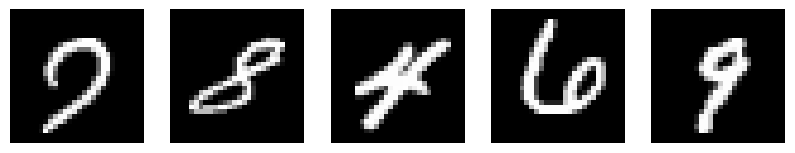

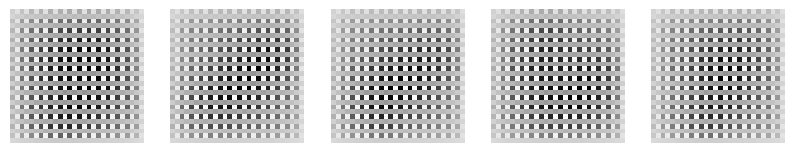

tensor([[0.0391],
        [0.0372],
        [0.0337],
        [0.0343],
        [0.0366]], device='cuda:0', grad_fn=<SigmoidBackward0>)

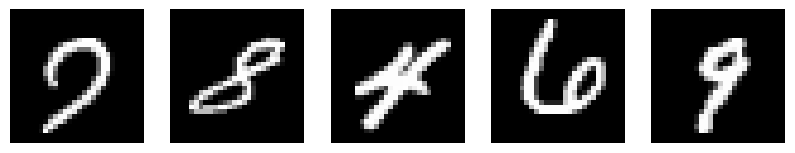

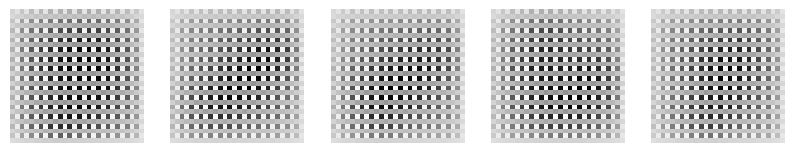

tensor([[0.0421],
        [0.0387],
        [0.0351],
        [0.0357],
        [0.0380]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

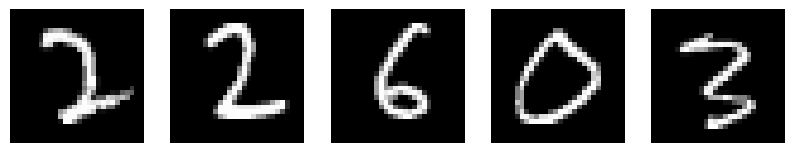

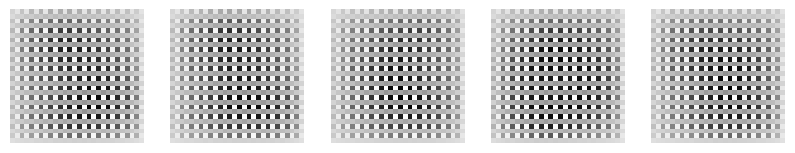

tensor([[0.0177],
        [0.0152],
        [0.0160],
        [0.0144],
        [0.0142]], device='cuda:0', grad_fn=<SigmoidBackward0>)

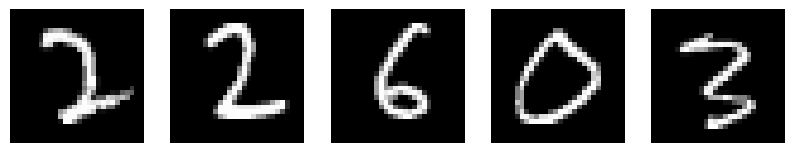

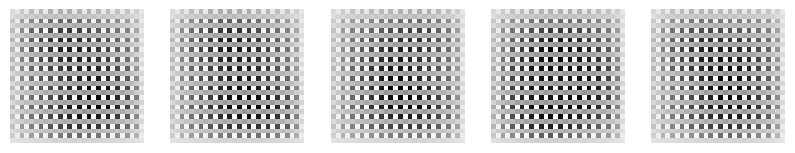

tensor([[0.0196],
        [0.0170],
        [0.0178],
        [0.0161],
        [0.0159]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

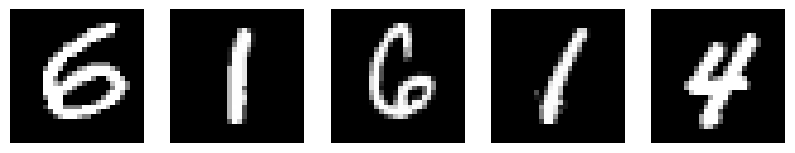

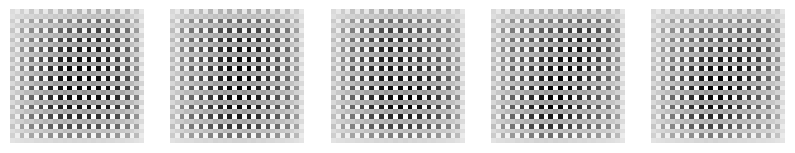

tensor([[0.0028],
        [0.0108],
        [0.0053],
        [0.0105],
        [0.0045]], device='cuda:0', grad_fn=<SigmoidBackward0>)

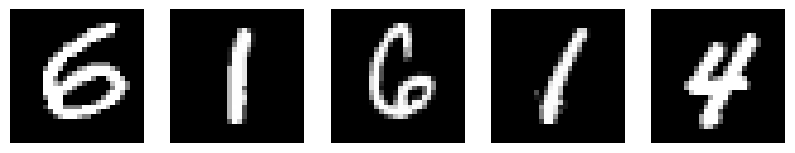

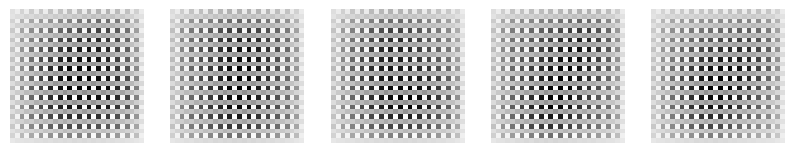

tensor([[0.0029],
        [0.0111],
        [0.0055],
        [0.0107],
        [0.0047]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

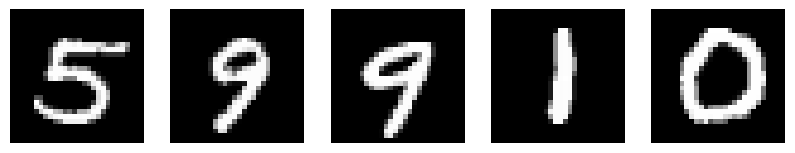

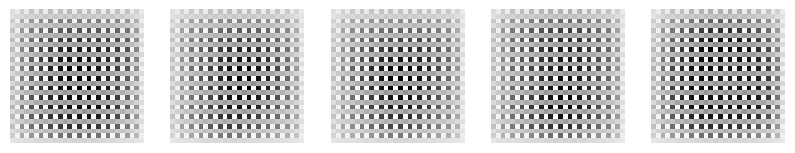

tensor([[0.0035],
        [0.0036],
        [0.0030],
        [0.0084],
        [0.0024]], device='cuda:0', grad_fn=<SigmoidBackward0>)

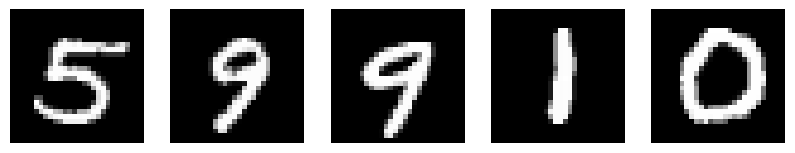

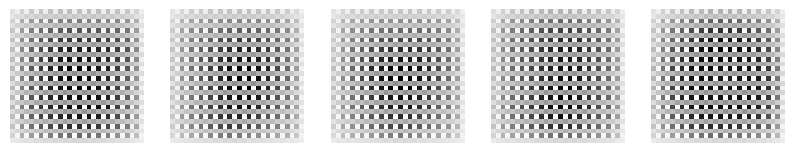

tensor([[0.0037],
        [0.0038],
        [0.0032],
        [0.0087],
        [0.0025]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

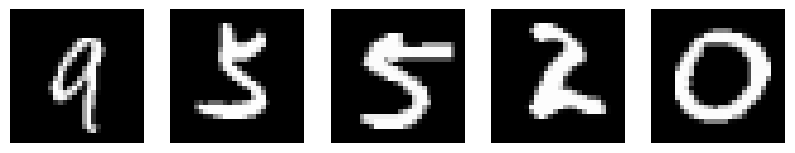

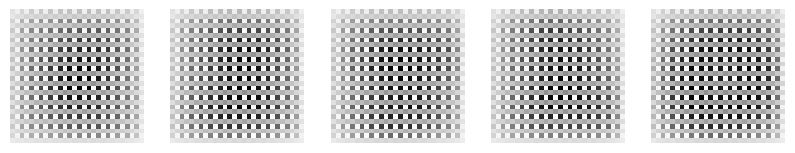

tensor([[0.0066],
        [0.0049],
        [0.0036],
        [0.0043],
        [0.0030]], device='cuda:0', grad_fn=<SigmoidBackward0>)

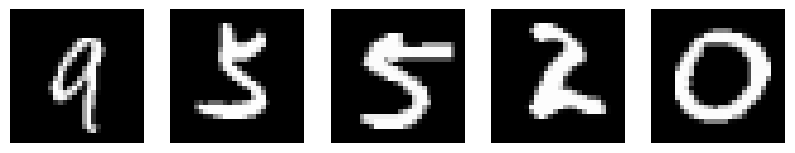

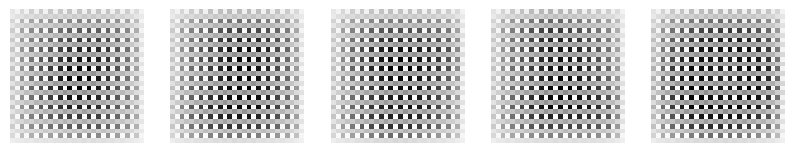

tensor([[0.0060],
        [0.0045],
        [0.0033],
        [0.0040],
        [0.0027]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

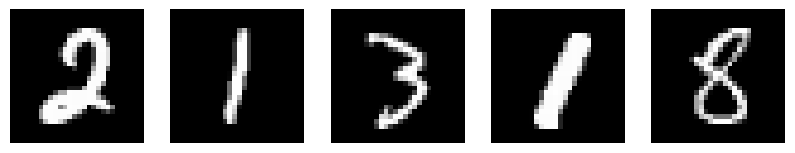

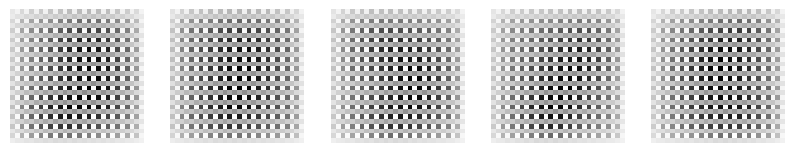

tensor([[0.0114],
        [0.0136],
        [0.0129],
        [0.0177],
        [0.0106]], device='cuda:0', grad_fn=<SigmoidBackward0>)

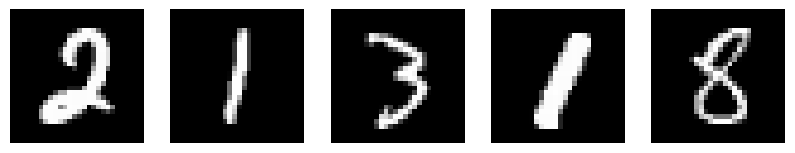

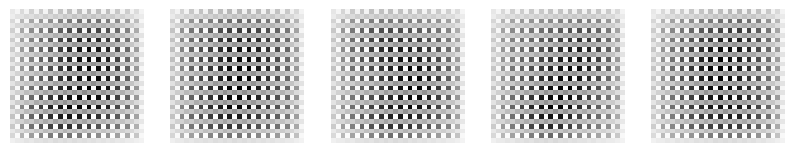

tensor([[0.0097],
        [0.0125],
        [0.0113],
        [0.0154],
        [0.0091]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

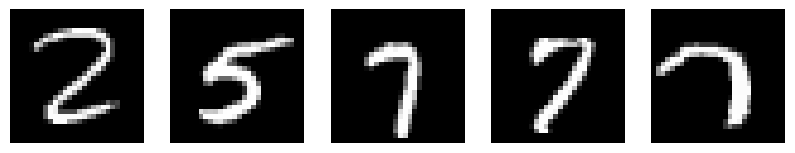

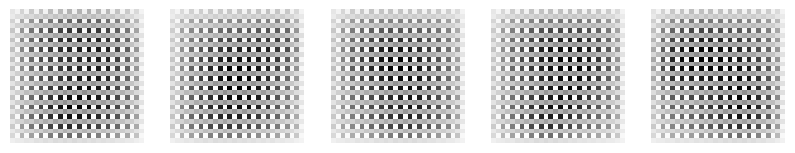

tensor([[0.0033],
        [0.0054],
        [0.0065],
        [0.0056],
        [0.0029]], device='cuda:0', grad_fn=<SigmoidBackward0>)

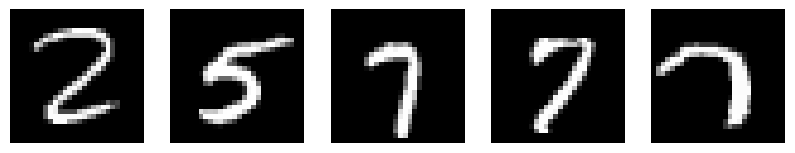

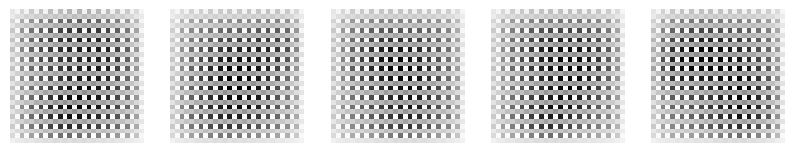

tensor([[0.0030],
        [0.0049],
        [0.0061],
        [0.0051],
        [0.0028]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

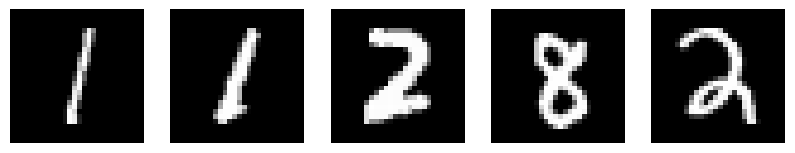

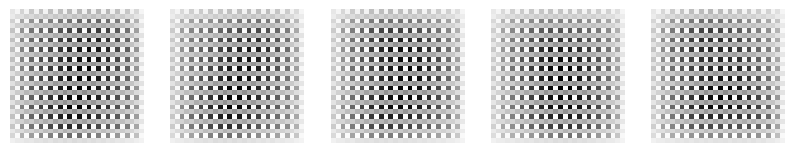

tensor([[0.0038],
        [0.0034],
        [0.0013],
        [0.0025],
        [0.0011]], device='cuda:0', grad_fn=<SigmoidBackward0>)

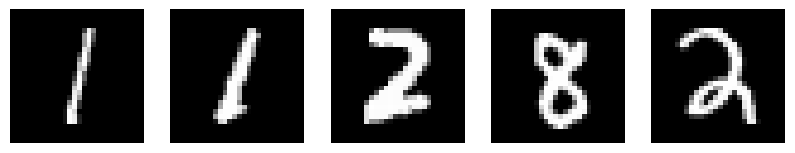

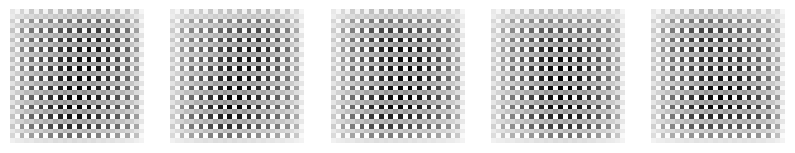

tensor([[0.0039],
        [0.0033],
        [0.0013],
        [0.0024],
        [0.0011]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

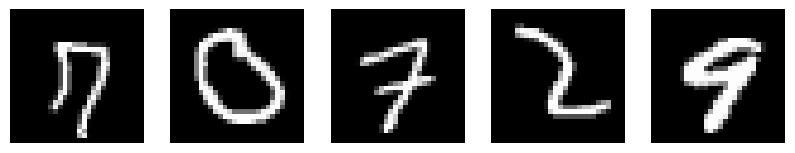

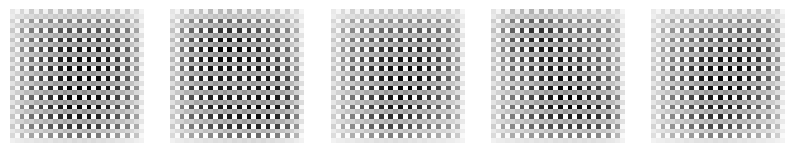

tensor([[0.0007],
        [0.0002],
        [0.0006],
        [0.0005],
        [0.0006]], device='cuda:0', grad_fn=<SigmoidBackward0>)

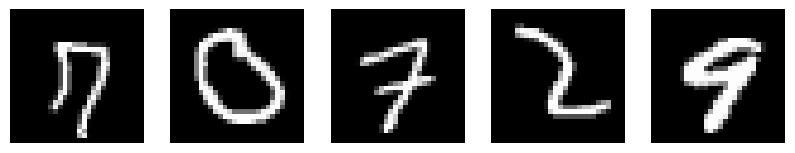

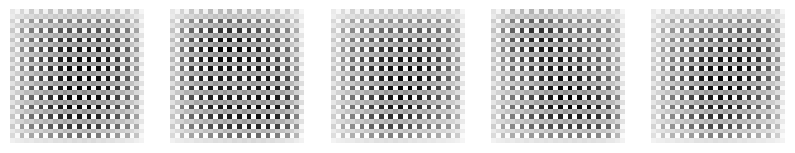

tensor([[0.0007],
        [0.0002],
        [0.0006],
        [0.0006],
        [0.0006]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

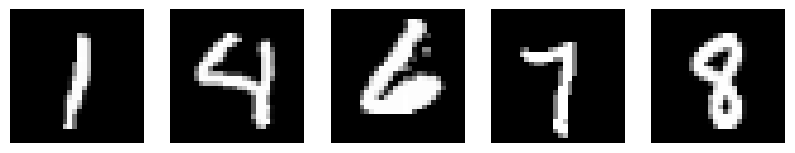

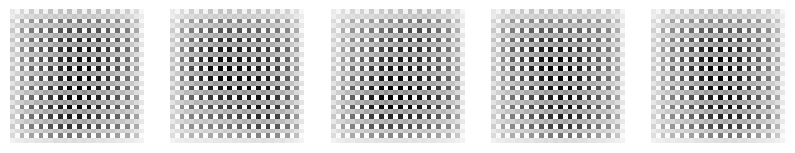

tensor([[5.0641e-04],
        [9.7980e-05],
        [1.1988e-04],
        [2.5568e-04],
        [1.6381e-04]], device='cuda:0', grad_fn=<SigmoidBackward0>)

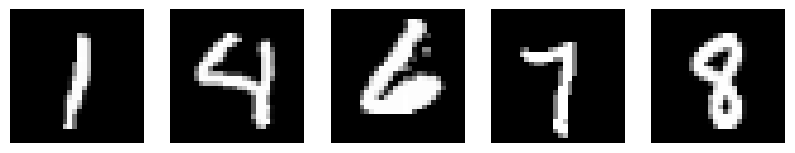

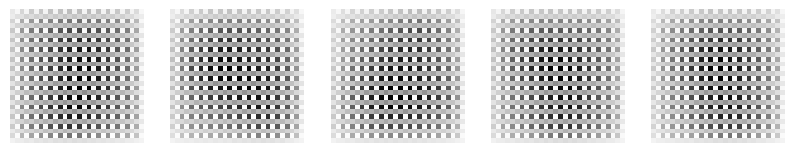

tensor([[0.0005],
        [0.0001],
        [0.0001],
        [0.0003],
        [0.0002]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

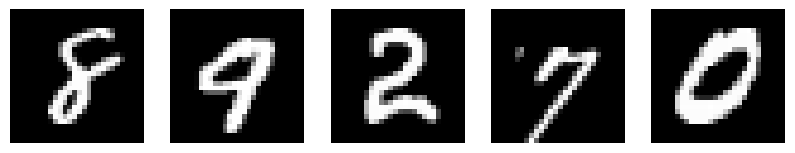

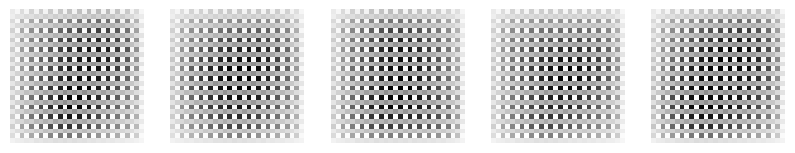

tensor([[4.7581e-05],
        [3.0876e-05],
        [2.9229e-05],
        [9.7940e-05],
        [1.6164e-05]], device='cuda:0', grad_fn=<SigmoidBackward0>)

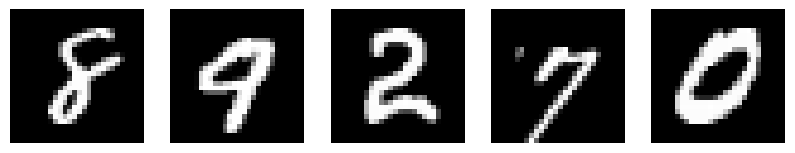

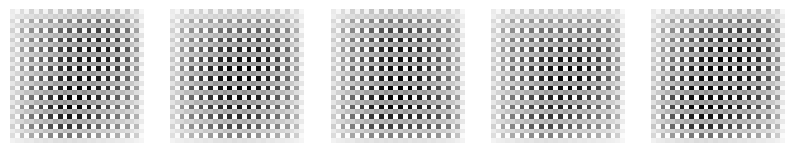

tensor([[4.9132e-05],
        [3.1904e-05],
        [3.0683e-05],
        [1.0107e-04],
        [1.7031e-05]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

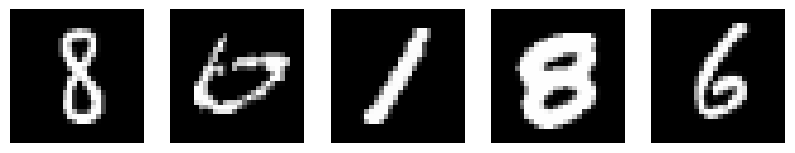

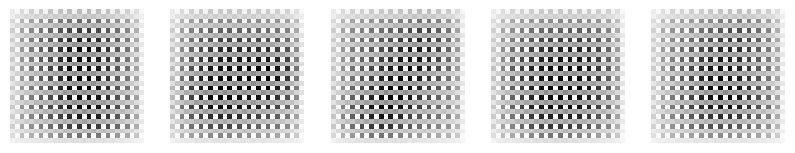

tensor([[3.2853e-05],
        [1.4616e-05],
        [4.2333e-05],
        [4.5529e-06],
        [2.7873e-05]], device='cuda:0', grad_fn=<SigmoidBackward0>)

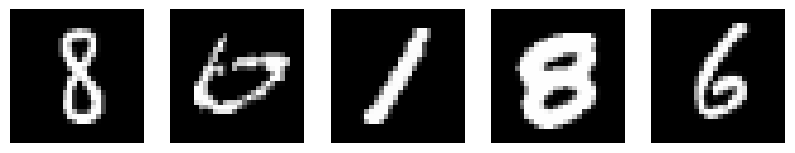

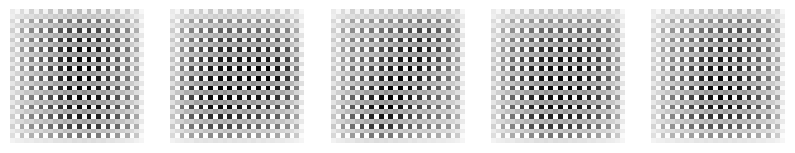

tensor([[3.3937e-05],
        [1.5347e-05],
        [4.4266e-05],
        [4.6927e-06],
        [2.8640e-05]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

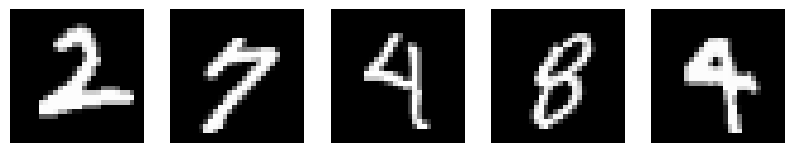

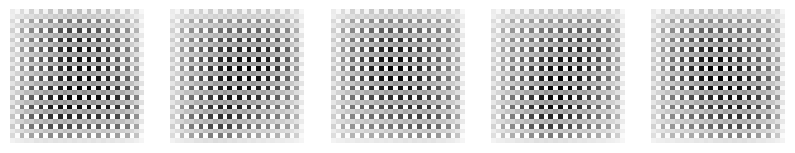

tensor([[5.0382e-06],
        [5.9968e-06],
        [1.1594e-05],
        [8.1294e-06],
        [8.5888e-06]], device='cuda:0', grad_fn=<SigmoidBackward0>)

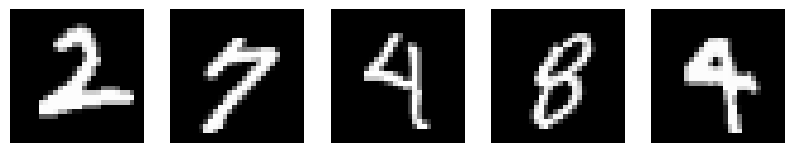

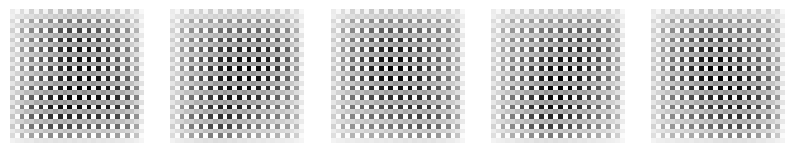

tensor([[5.2809e-06],
        [6.1926e-06],
        [1.2169e-05],
        [8.3745e-06],
        [8.8568e-06]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

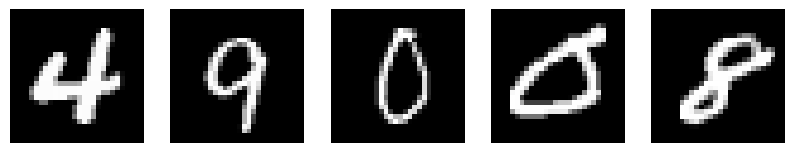

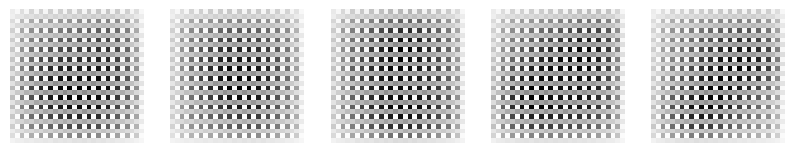

tensor([[1.7992e-06],
        [3.4611e-06],
        [6.8014e-06],
        [9.8636e-07],
        [2.4754e-06]], device='cuda:0', grad_fn=<SigmoidBackward0>)

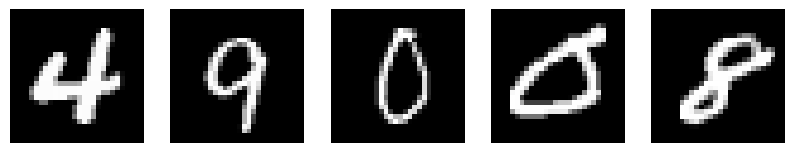

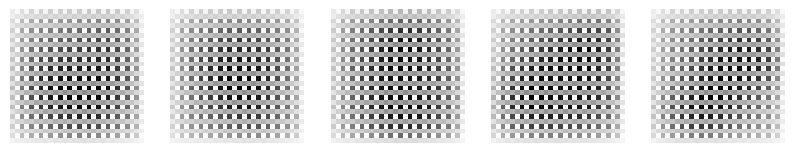

tensor([[1.8891e-06],
        [3.6217e-06],
        [7.1244e-06],
        [1.0374e-06],
        [2.5496e-06]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

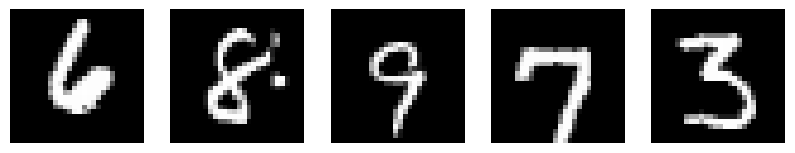

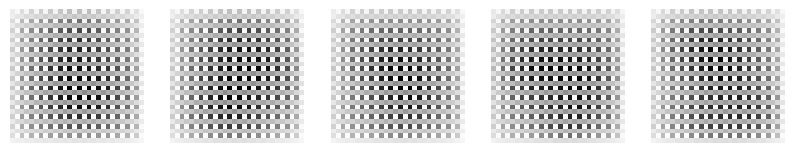

tensor([[1.3775e-06],
        [6.9932e-07],
        [3.1334e-06],
        [1.6195e-06],
        [8.3137e-07]], device='cuda:0', grad_fn=<SigmoidBackward0>)

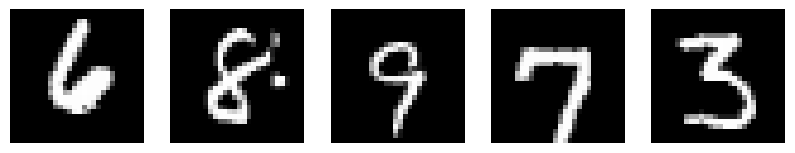

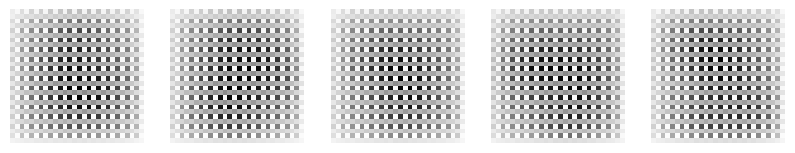

tensor([[1.4374e-06],
        [7.3293e-07],
        [3.2689e-06],
        [1.6951e-06],
        [8.7038e-07]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

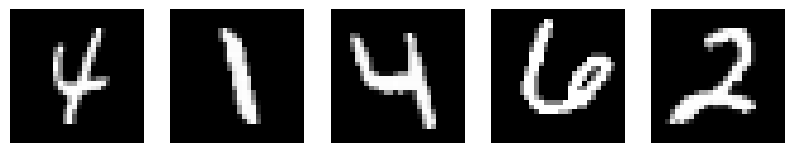

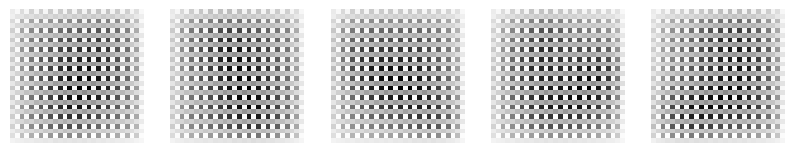

tensor([[2.1876e-06],
        [4.5662e-06],
        [7.6122e-07],
        [2.5014e-07],
        [6.7893e-07]], device='cuda:0', grad_fn=<SigmoidBackward0>)

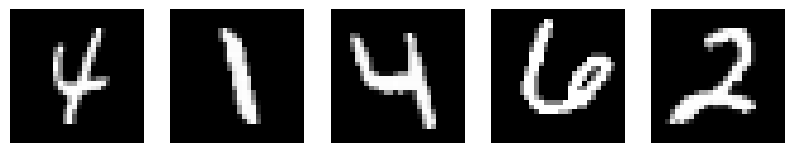

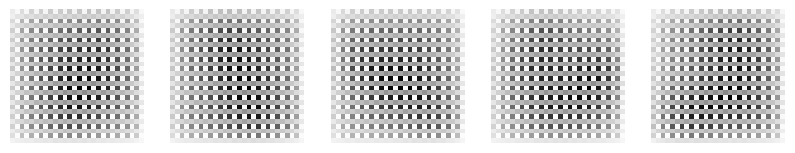

tensor([[2.2794e-06],
        [4.7568e-06],
        [7.9674e-07],
        [2.6207e-07],
        [7.0692e-07]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

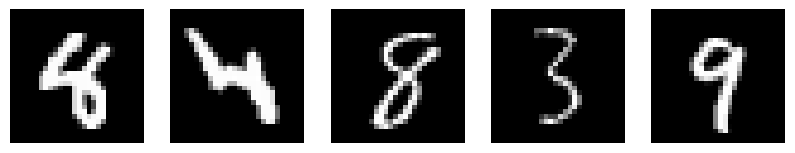

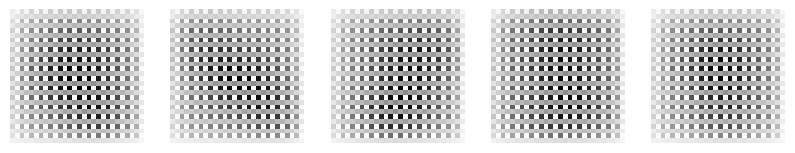

tensor([[1.3673e-07],
        [3.1500e-07],
        [7.2398e-07],
        [3.5428e-06],
        [5.2257e-07]], device='cuda:0', grad_fn=<SigmoidBackward0>)

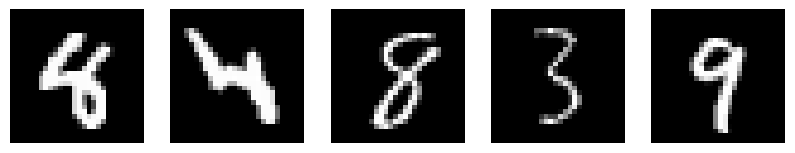

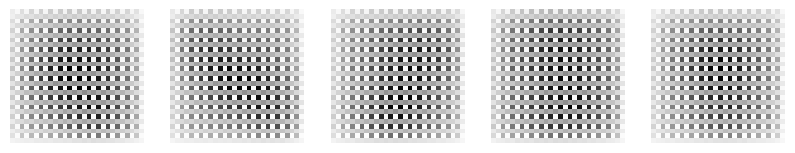

tensor([[1.4282e-07],
        [3.2883e-07],
        [7.4628e-07],
        [3.6892e-06],
        [5.4369e-07]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

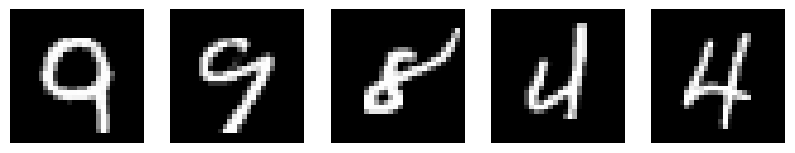

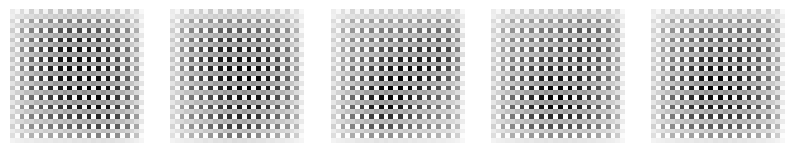

tensor([[1.4847e-07],
        [1.0716e-07],
        [2.8783e-07],
        [4.7543e-07],
        [2.8980e-07]], device='cuda:0', grad_fn=<SigmoidBackward0>)

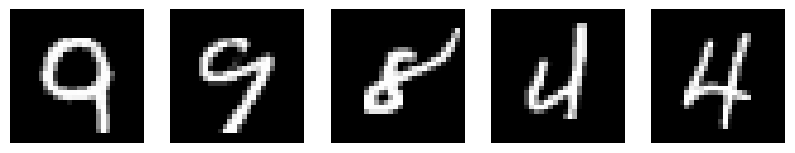

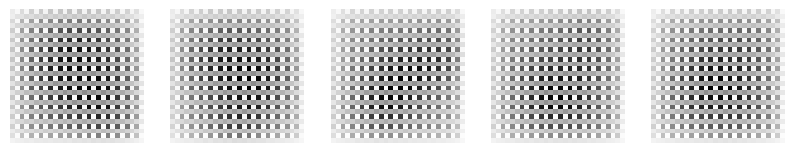

tensor([[1.5393e-07],
        [1.1160e-07],
        [2.9577e-07],
        [4.9427e-07],
        [3.0117e-07]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

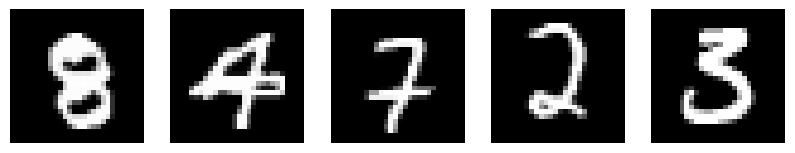

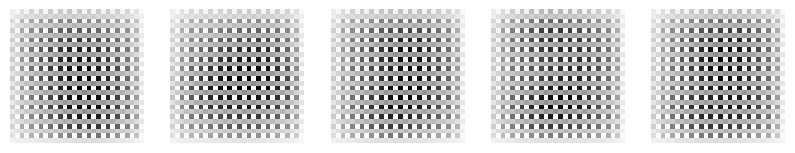

tensor([[7.5935e-08],
        [3.3353e-08],
        [2.0884e-07],
        [2.3672e-07],
        [3.8760e-08]], device='cuda:0', grad_fn=<SigmoidBackward0>)

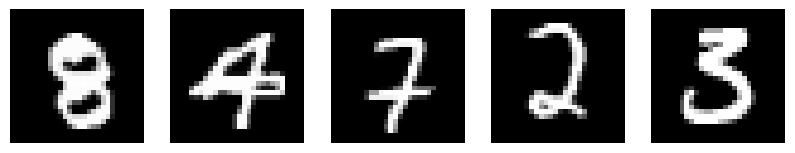

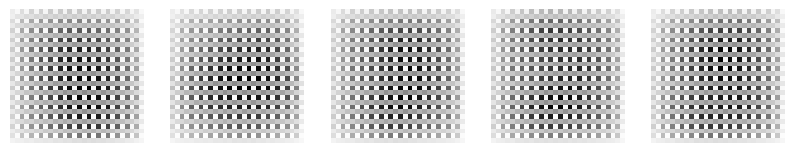

tensor([[7.7856e-08],
        [3.4239e-08],
        [2.1682e-07],
        [2.4476e-07],
        [4.0158e-08]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

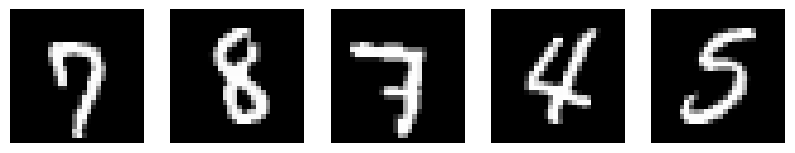

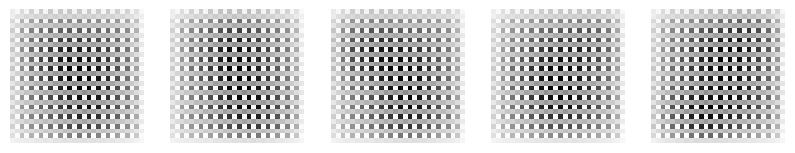

tensor([[1.4697e-07],
        [6.4191e-08],
        [7.4696e-08],
        [5.3710e-08],
        [7.6733e-08]], device='cuda:0', grad_fn=<SigmoidBackward0>)

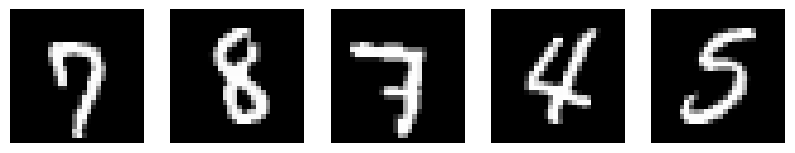

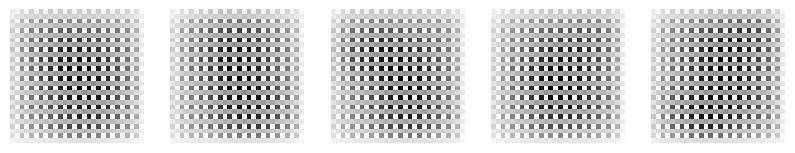

tensor([[1.5157e-07],
        [6.5539e-08],
        [7.7117e-08],
        [5.4849e-08],
        [7.9258e-08]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

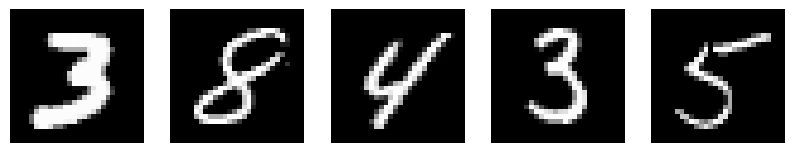

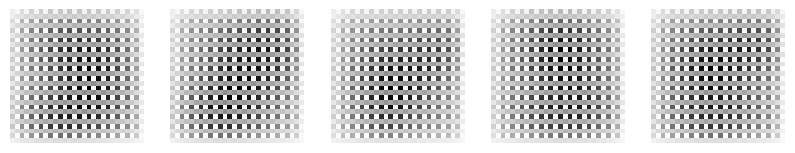

tensor([[2.1884e-08],
        [1.9505e-08],
        [3.8053e-08],
        [6.7976e-08],
        [7.7601e-08]], device='cuda:0', grad_fn=<SigmoidBackward0>)

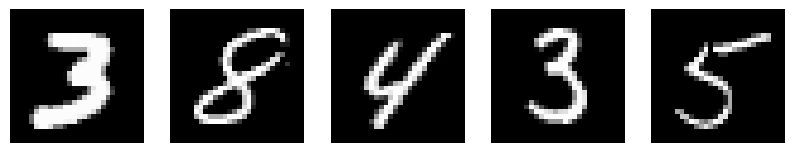

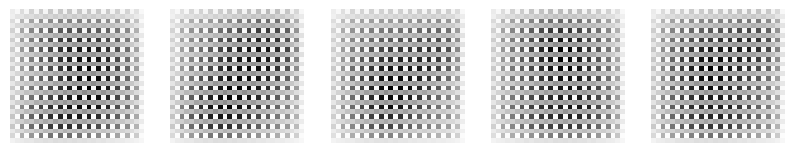

tensor([[2.2334e-08],
        [2.0108e-08],
        [3.9182e-08],
        [7.0020e-08],
        [8.0378e-08]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

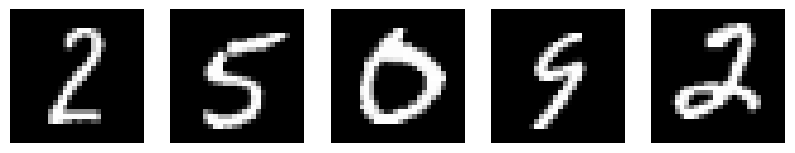

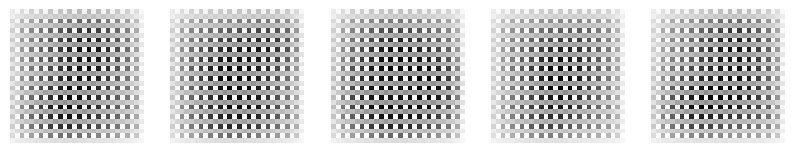

tensor([[8.3928e-08],
        [3.2729e-08],
        [1.1774e-08],
        [4.2672e-08],
        [1.4137e-08]], device='cuda:0', grad_fn=<SigmoidBackward0>)

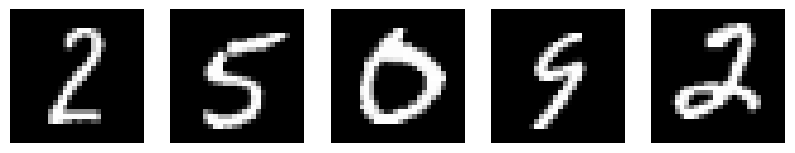

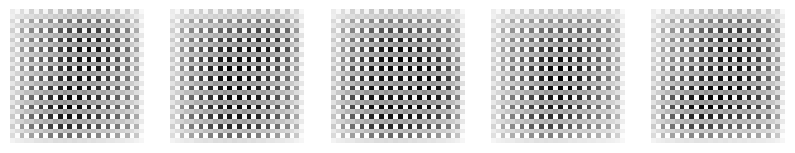

tensor([[8.6215e-08],
        [3.3675e-08],
        [1.2127e-08],
        [4.3429e-08],
        [1.4530e-08]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

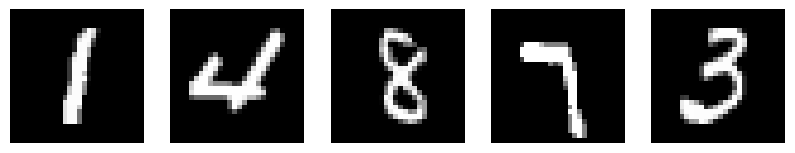

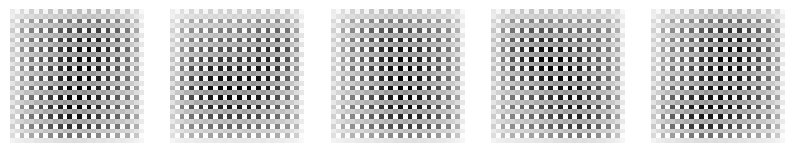

tensor([[2.0426e-07],
        [1.7372e-08],
        [5.8917e-08],
        [6.7576e-08],
        [2.8619e-08]], device='cuda:0', grad_fn=<SigmoidBackward0>)

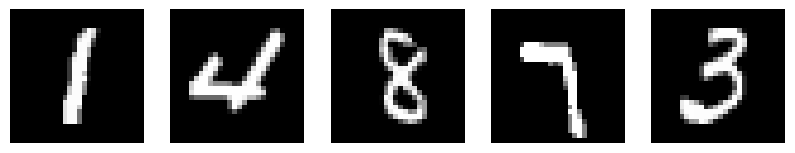

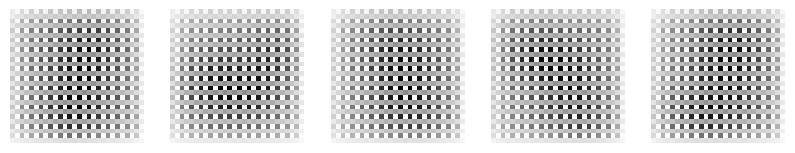

tensor([[2.0910e-07],
        [1.7829e-08],
        [5.9900e-08],
        [6.9530e-08],
        [2.9340e-08]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

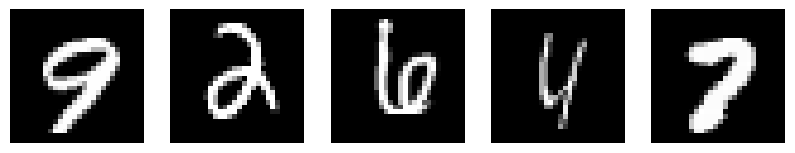

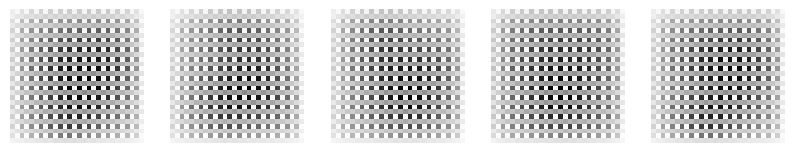

tensor([[4.5644e-09],
        [8.6251e-09],
        [1.3647e-08],
        [2.0169e-07],
        [1.1793e-08]], device='cuda:0', grad_fn=<SigmoidBackward0>)

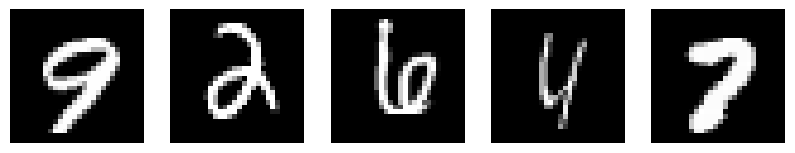

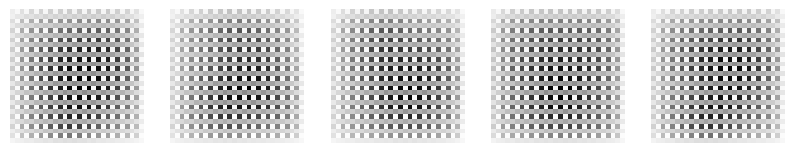

tensor([[4.6347e-09],
        [8.7529e-09],
        [1.3854e-08],
        [2.0614e-07],
        [1.1976e-08]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

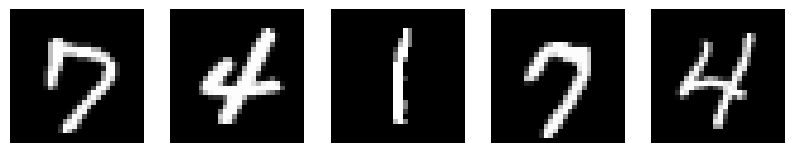

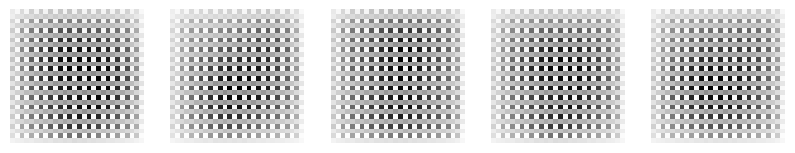

tensor([[1.5081e-08],
        [8.3437e-09],
        [2.8906e-07],
        [1.9698e-08],
        [1.6560e-08]], device='cuda:0', grad_fn=<SigmoidBackward0>)

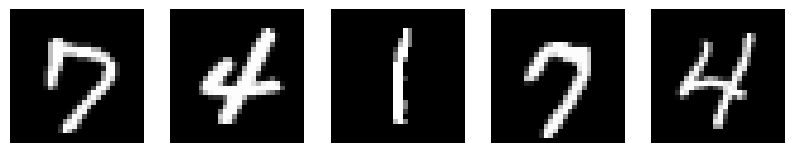

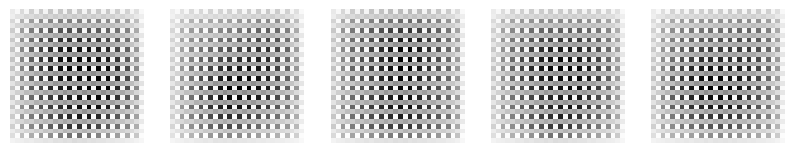

tensor([[1.5408e-08],
        [8.4473e-09],
        [2.9472e-07],
        [2.0107e-08],
        [1.6907e-08]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

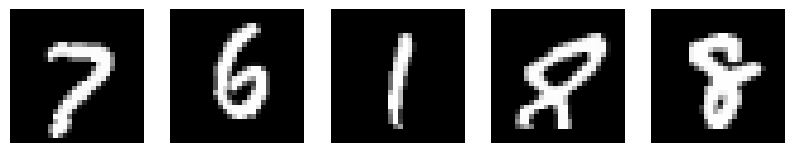

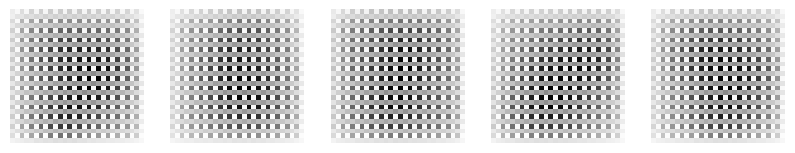

tensor([[1.3265e-08],
        [9.2228e-09],
        [1.6868e-07],
        [3.0352e-09],
        [5.8367e-09]], device='cuda:0', grad_fn=<SigmoidBackward0>)

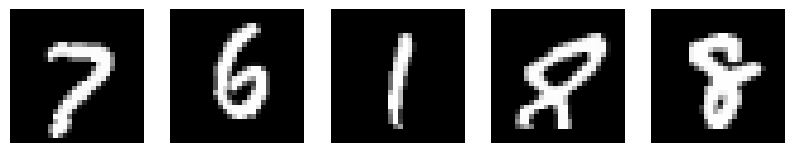

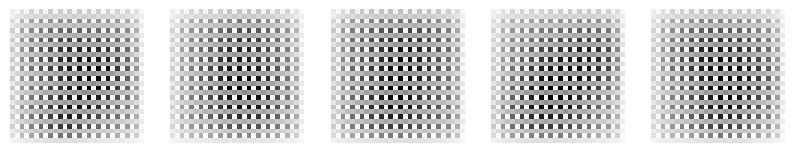

tensor([[1.3432e-08],
        [9.3349e-09],
        [1.7171e-07],
        [3.0750e-09],
        [5.9110e-09]], device='cuda:0', grad_fn=<SigmoidBackward0>)

epoch: 0

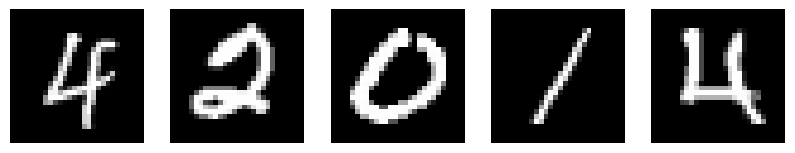

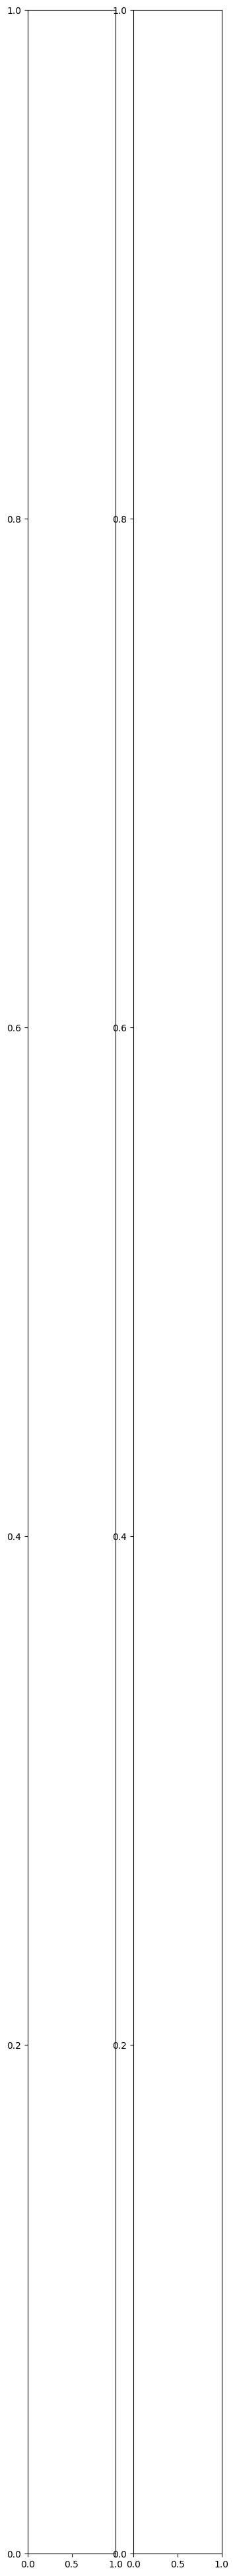

In [38]:
trainer = dl.Trainer(max_epochs=10)
trainer.fit(gan, train_loader)

In [35]:
test_output = gan.generator(list(test_loader)[100][0])

plt.imshow(tensor_to_image(list(test_loader)[100][0][0]),cmap="gray")
plt.show()
plt.imshow(tensor_to_image(test_output[0]),cmap="gray")
plt.show()

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
trainer.history.history()